# Comparison with Variance-reduced Zeroth order
In this notebook, we propose some experiments in order to compare SSZD with its variance-reduced variant.

## Imports

In [1]:
import os
import numpy as np
from sszd import SSZD, SSVRZD
import matplotlib
import matplotlib.pyplot as plt
from experiments_utils.synthetic_functions import BenchmarkFunction

out_dir = "./results/variance_reduced"

os.makedirs(out_dir, exist_ok=True)

## Auxiliary functions and variables

In [2]:
class StronglyConvexFunction(BenchmarkFunction):
    
    def __init__(self, d, seed =12):
        super().__init__("StronglyConvex", d)
        self.rnd_state = np.random.RandomState(seed = seed)
        self.A = self.rnd_state.rand(d, d)
        
    def __call__(self, x, z = None):
        if z is None:
            return 1/self.d * (np.linalg.norm(self.A.dot(x))**2)
        row = self.A[z, :]
        return (np.linalg.norm(row.dot(x))**2)

In [3]:
d = 100 # dimensions
rnd_state = np.random.RandomState(seed=1212)
strong_conv_target = StronglyConvexFunction(d, seed=12)

In [4]:
import time

def execute_experiment(alg, target, budget, x, z = None, deterministic=False):
    y_fun = [target(x)]
    ctime = []
    for k in range(1, budget):
        it_time = time.time()
        x = alg.step(target, x, z)
        it_time = time.time() - it_time
        if not deterministic:
            z = rnd_state.randint(low=0, high=d)
        y_fun.append(target(x))
        ctime.append(it_time)
    ctime = np.cumsum(ctime)
    return y_fun, ctime

## Experiment with $\alpha = 1/\sqrt{k}$

In [2]:
# Parameters
A = strong_conv_target.A
w, _ = np.linalg.eigh(A.T.dot(A))

L = w[-1] / A.shape[0]
reps = 10

l = d//2

alpha = lambda k : 0.2 * l/(d * L) * 1/np.sqrt(k) #np.sqrt(k) # Step-size
alpha_det = lambda k : 0.1 * l/(d * L) #np.sqrt(k) # Step-size

h = lambda k : 1/k # Discretization parameter

y_ssvrzd_sph, ctime_ssvrzd_sph = [], []
y_sszd_sph, ctime_sszd_sph = [], []
y_szd_sph, ctime_szd_sph = [], []

sszd_sph = SSZD('spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)
szd_sph = SSZD('spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)
ssvrzd_sph = SSVRZD(5, False, 'spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)


for i in range(reps):
    x = np.asarray([10.0 for _ in range(d)])
    z = 0
    budget = 500 #5000
    print("[--] Episode: {}/{}".format(i, reps))
    sszd_y, sszd_time = execute_experiment(sszd_sph, strong_conv_target, budget, x, z)
    szd_y, szd_time = execute_experiment(szd_sph, strong_conv_target, budget, x, None, True)
    vr_y, vr_time = execute_experiment(ssvrzd_sph, strong_conv_target, budget, x, z)
    
    y_ssvrzd_sph.append(vr_y)
    ctime_ssvrzd_sph.append(vr_time)
    y_sszd_sph.append(sszd_y)
    ctime_sszd_sph.append(sszd_time)
    y_szd_sph.append(szd_y)
    ctime_szd_sph.append(szd_time)
    sszd_sph.reset()
    szd_sph.reset()
    ssvrzd_sph.reset()
print("[--] Done!")

NameError: name 'strong_conv_target' is not defined

In [168]:
# Collect y results
sph_mean, sph_std = np.mean(y_sszd_sph, axis=0), np.std(y_sszd_sph, axis=0)
sph_det_mean, sph_det_std = np.mean(y_szd_sph, axis=0), np.std(y_szd_sph, axis=0)
sph_vr_mean, sph_vr_std = np.mean(y_ssvrzd_sph, axis=0), np.std(y_ssvrzd_sph, axis=0)

# Collect y results
sph_mean_tm, sph_std_tm = np.mean(ctime_sszd_sph, axis=0), np.std(ctime_sszd_sph, axis=0)
sph_det_mean_tm, sph_det_std_tm = np.mean(ctime_szd_sph, axis=0), np.std(ctime_szd_sph, axis=0)
sph_vr_mean_tm, sph_vr_std_tm = np.mean(ctime_ssvrzd_sph, axis=0), np.std(ctime_ssvrzd_sph, axis=0)



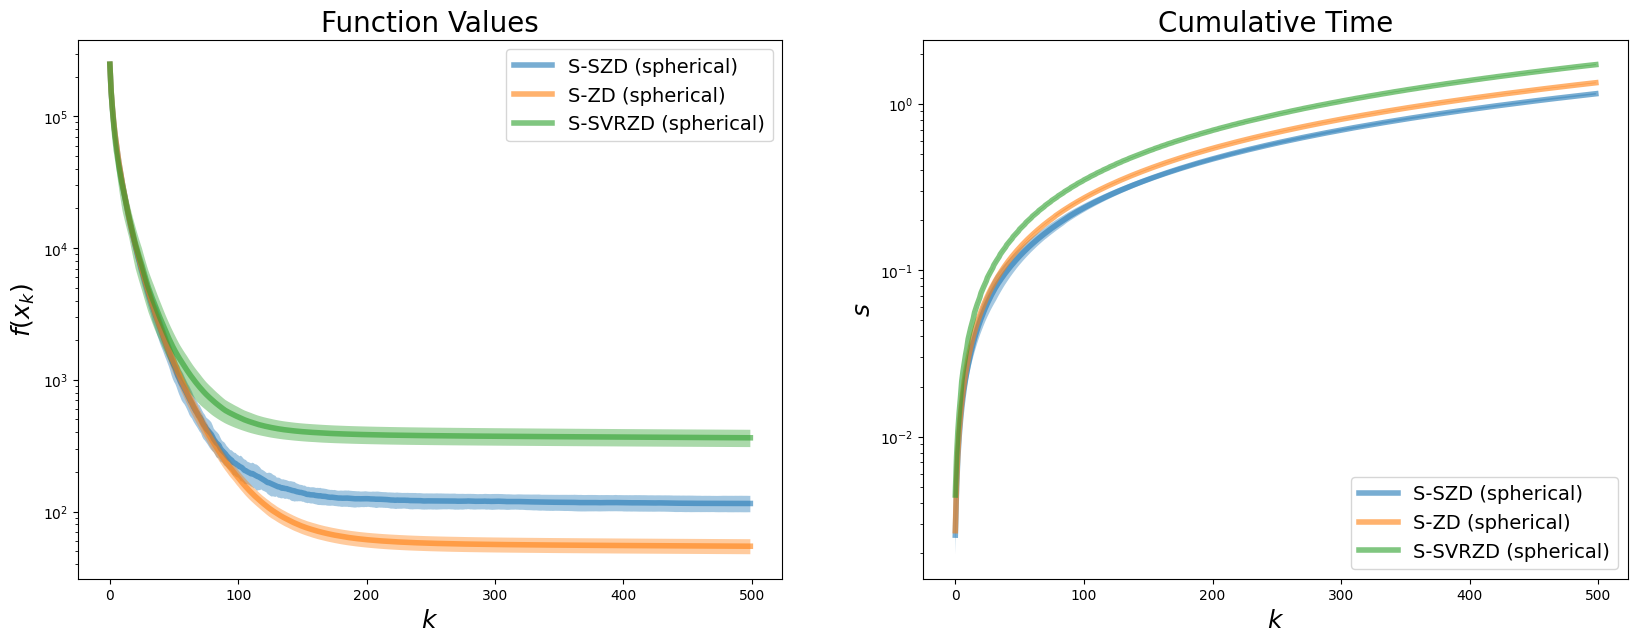

In [169]:

def plot_mean_std(ax, mean, std, label):
    ax.plot(range(len(mean)),   mean, '-', lw=4, alpha=0.6, label=label)
    ax.fill_between(range(len(mean)),  mean + std, mean - std, alpha=0.4)
   

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.set_title("Function Values", fontsize=20)
ax2.set_title("Cumulative Time", fontsize=20)

plot_mean_std(ax1, sph_mean, sph_std, label="S-SZD (spherical)")
plot_mean_std(ax1, sph_det_mean, sph_det_std, label="S-ZD (spherical)")
plot_mean_std(ax1, sph_vr_mean, sph_vr_std, label="S-SVRZD (spherical)")


plot_mean_std(ax2, sph_mean_tm, sph_std_tm, label="S-SZD (spherical)")
plot_mean_std(ax2, sph_det_mean_tm, sph_det_std_tm, label="S-ZD (spherical)")
plot_mean_std(ax2, sph_vr_mean_tm, sph_vr_std_tm, label="S-SVRZD (spherical)")




ax1.set_xlabel("$k$", fontsize=18)
ax1.set_ylabel("$f(x_k)$", fontsize=18)
ax2.set_xlabel("$k$", fontsize=18)
ax2.set_ylabel("$s$", fontsize=18)

ax1.legend(loc="upper right", fontsize=14)
ax1.set_yscale("log")
ax2.legend(loc="lower right", fontsize=14)
ax2.set_yscale("log")


In [162]:
def change_num_iters(num_iter, reps, budget):
    ssvrzd_sph = SSVRZD(num_iter, 'spherical', d, l,  alpha, h,  dtype = np.float64, seed = it)

    y_values = np.zeros((reps, budget))
    ctime = np.zeros((reps, budget-1))
    
    for i in range(reps):
        x = np.asarray([10.0 for _ in range(d)])
        z = 0
        print("[NI={}] Episode: {}/{}".format(num_iter, i, reps))
        vr_y, vr_time = execute_experiment(ssvrzd_sph, strong_conv_target, budget, x, z)
        y_values[i] = vr_y
        ctime[i] = vr_time
    ctime = np.cumsum(ctime, axis=1)
    return y_values.mean(axis=0), y_values.std(axis=0), ctime.mean(axis=0), ctime.std(axis=0)

reps = 10
budget = 500

iters = [1, 5, 10, 20]    

results = []
for it in iters:
    results.append(change_num_iters(it, reps, budget))

    
    

[NI=1] Episode: 0/10
[NI=1] Episode: 1/10
[NI=1] Episode: 2/10
[NI=1] Episode: 3/10
[NI=1] Episode: 4/10
[NI=1] Episode: 5/10
[NI=1] Episode: 6/10
[NI=1] Episode: 7/10
[NI=1] Episode: 8/10
[NI=1] Episode: 9/10
[NI=5] Episode: 0/10
[NI=5] Episode: 1/10
[NI=5] Episode: 2/10
[NI=5] Episode: 3/10
[NI=5] Episode: 4/10
[NI=5] Episode: 5/10
[NI=5] Episode: 6/10
[NI=5] Episode: 7/10
[NI=5] Episode: 8/10
[NI=5] Episode: 9/10
[NI=10] Episode: 0/10
[NI=10] Episode: 1/10
[NI=10] Episode: 2/10
[NI=10] Episode: 3/10
[NI=10] Episode: 4/10
[NI=10] Episode: 5/10
[NI=10] Episode: 6/10
[NI=10] Episode: 7/10
[NI=10] Episode: 8/10
[NI=10] Episode: 9/10
[NI=20] Episode: 0/10
[NI=20] Episode: 1/10
[NI=20] Episode: 2/10
[NI=20] Episode: 3/10
[NI=20] Episode: 4/10
[NI=20] Episode: 5/10
[NI=20] Episode: 6/10
[NI=20] Episode: 7/10
[NI=20] Episode: 8/10
[NI=20] Episode: 9/10


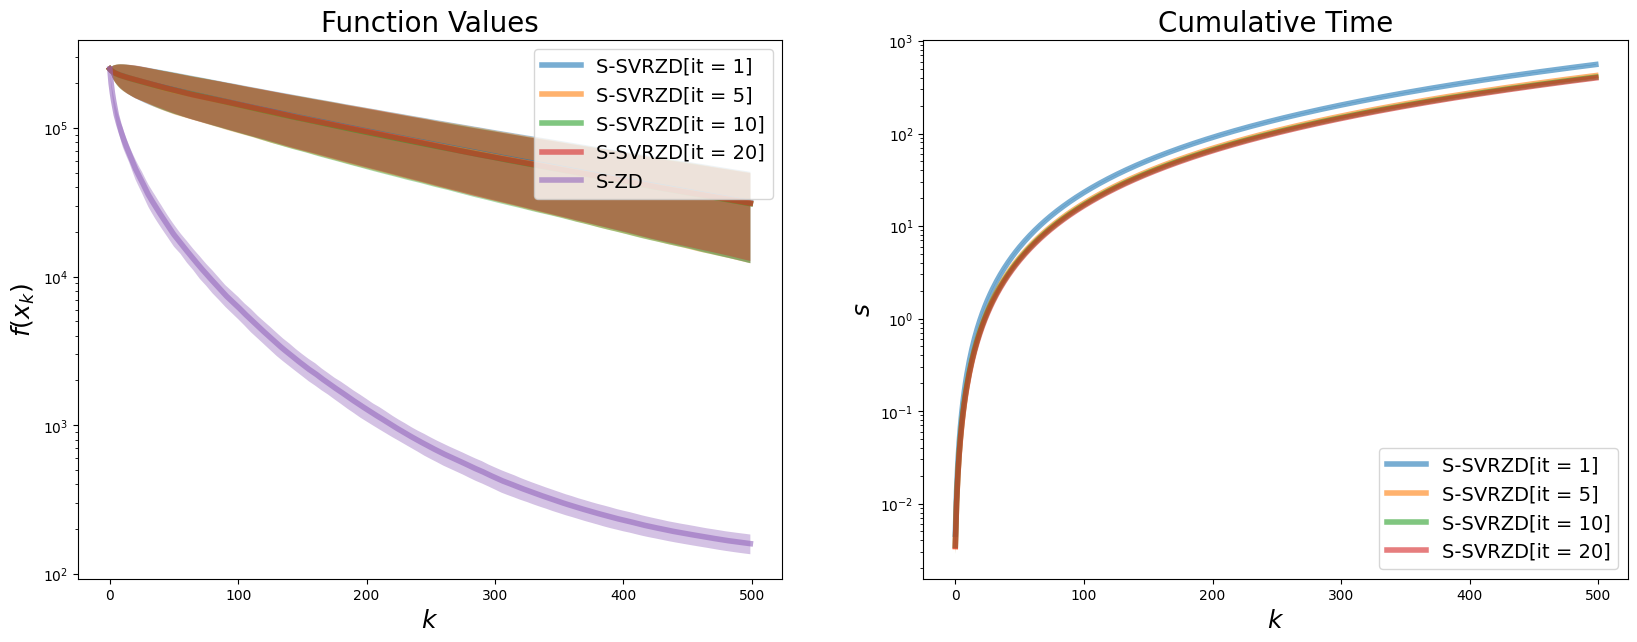

In [163]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.set_title("Function Values", fontsize=20)
ax2.set_title("Cumulative Time", fontsize=20)

for (it, ris) in zip(iters, results):
    y_mean, y_std, tm_mean, tm_std = ris
    
    plot_mean_std(ax1, y_mean , y_std, label="S-SVRZD[it = {}]".format(it))
    plot_mean_std(ax2, tm_mean, tm_std, label="S-SVRZD[it = {}]".format(it))

plot_mean_std(ax1, sph_vr_mean, sph_vr_std, label="S-ZD")



ax1.set_xlabel("$k$", fontsize=18)
ax1.set_ylabel("$f(x_k)$", fontsize=18)
ax2.set_xlabel("$k$", fontsize=18)
ax2.set_ylabel("$s$", fontsize=18)

ax1.legend(loc="upper right", fontsize=14)
ax1.set_yscale("log")
ax2.legend(loc="lower right", fontsize=14)
ax2.set_yscale("log")


In [73]:
d = 7
rnd_state = np.random.RandomState(12)

w = rnd_state.rand(d, 1)

def generate_data(n_points, w, rnd_state, sigma_noise=0.1):
    X = np.zeros((n_points, d))
    for i in range(d):
        X[:, i] = rnd_state.uniform(-1, 1, size=n_points)
    
    gauss_noise = rnd_state.normal(0, sigma_noise, size=(n_points, 1))

    y = np.dot(X, w) + gauss_noise
    
    return X, y    

n_points = 1000
    
X, y = generate_data(n_points, w, rnd_state, sigma_noise=0.1)
    
    
#_, ax = plt.subplots()
#ax.plot(X, y, 'o')

    
    

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)


print(w)

[[0.15416284]
 [0.7400497 ]
 [0.26331502]
 [0.53373939]
 [0.01457496]
 [0.91874701]
 [0.90071485]]


In [75]:
def mse(y, y_pred):
    return ((y - y_pred)**2).mean()

def target(w, z = None):
    w = w.reshape(-1, 1)
    if z is None:
        X, y = X_train, y_train
    else:
        X, y = z
    y_pred = X.dot(w)
    return mse(y, y_pred)



l = d

L =  np.max(np.linalg.eigvals(X_train.T.dot(X_train)))

alpha = lambda k : 0.001* 1/np.sqrt(k)
h = lambda k : 5 * 1/k

rnd_state = np.random.RandomState(12)
T = 10000

reps = 5
num_iters = 1000

results = {
    'szd' : [[] for _ in range(reps)],
    'sszd' : [[] for _ in range(reps)],
    'ssvrzd_full_iter' : [[] for _ in range(reps)],
    'ssvrzd_only_iter' : [[] for _ in range(reps)],
}

def update_results(name, w, r):
    results[name][r].append(target(w, (X_train, y_train)))


szd = SSZD('coordinate', d, l,  alpha, h,  dtype = np.float64, seed = 12)
sszd = SSZD('coordinate', d, l,  alpha, h,  dtype = np.float64, seed = 12)
ssvrzd = SSVRZD(num_iters, False, 'coordinate', d, l,  alpha, h,  dtype = np.float64, seed = 12)
ssvrzd_2 = SSVRZD(num_iters, True, 'coordinate', d, l,  alpha, h,  dtype = np.float64, seed = 12)


for r in range(reps):
    w_k_szd = np.zeros(d) + 20
    w_k_sszd = np.zeros(d) + 20
    w_k_ssvrzd = np.zeros(d) + 20
    w_k_ssvrzd_2 = np.zeros(d) + 20


    update_results("szd", w_k_szd, r)
    update_results("sszd", w_k_sszd, r)
    update_results("ssvrzd_full_iter", w_k_ssvrzd, r)
    update_results("ssvrzd_only_iter", w_k_ssvrzd_2, r)

    for t in range(T):
        z = rnd_state.randint(low=0, high=X_train.shape[0])
        w_k_sszd = szd.step(target, w_k_sszd, (X_train[z,:], y_train[z]))
        w_k_szd = sszd.step(target, w_k_szd, (X_train, y_train))
        w_k_ssvrzd = ssvrzd.step(target, w_k_ssvrzd, (X_train[z,:], y_train[z]))
        w_k_ssvrzd_2 = ssvrzd_2.step(target, w_k_ssvrzd_2, (X_train[z,:], y_train[z]))

        update_results("szd", w_k_szd, r)
        update_results("sszd", w_k_sszd, r)
        update_results("ssvrzd_full_iter", w_k_ssvrzd, r)
        update_results("ssvrzd_only_iter", w_k_ssvrzd_2, r)

    szd.reset()
    sszd.reset()
    ssvrzd.reset()
    ssvrzd_2.reset()
#print(w_k_sszd, w_k_szd)


[--] Old diff: 137.02405489841473
[--] Old diff: 137.02405489841473
[--] Old diff: 160.12891022387822
[--] Old diff: 160.12891022387822
[--] Old diff: 58.24704333267342
[--] Old diff: 58.24704333267342
[--] Old diff: 48.072743828106425
[--] Old diff: 48.072743828106425
[--] Old diff: 71.84762012401534
[--] Old diff: 71.84762012401534
[--] Old diff: 92.8256064746246
[--] Old diff: 92.8256064746246
[--] Old diff: 62.926230396072285
[--] Old diff: 62.926230396072285
[--] Old diff: 70.69151023487566
[--] Old diff: 70.69151023487566
[--] Old diff: 43.1001470047756
[--] Old diff: 43.1001470047756
[--] Old diff: 71.75961055592096
[--] Old diff: 71.75961055592096
[--] Old diff: 199.06023243622278
[--] Old diff: 199.06023243622278
[--] Old diff: 49.361906043375086
[--] Old diff: 49.361906043375086
[--] Old diff: 35.68472279678819
[--] Old diff: 35.68472279678819
[--] Old diff: 74.73737606751402
[--] Old diff: 74.73737606751402
[--] Old diff: 43.086631988253835
[--] Old diff: 43.086631988253835


[--] Old diff: 36.256979849844306
[--] Old diff: 36.256979849844306
[--] Old diff: 43.818142260142494
[--] Old diff: 43.818142260142494
[--] Old diff: 35.78428703946574
[--] Old diff: 35.78428703946574
[--] Old diff: 110.06638225547145
[--] Old diff: 110.06638225547145
[--] Old diff: 135.7112439220403
[--] Old diff: 135.7112439220403
[--] Old diff: 41.83894946455692
[--] Old diff: 41.83894946455692
[--] Old diff: 128.05406399545026
[--] Old diff: 128.05406399545026
[--] Old diff: 32.40375939729097
[--] Old diff: 32.40375939729097
[--] Old diff: 105.41141294679718
[--] Old diff: 105.41141294679718
[--] Old diff: 87.38752503552256
[--] Old diff: 87.38752503552256
[--] Old diff: 36.307003916576946
[--] Old diff: 36.307003916576946
[--] Old diff: 72.78436433341419
[--] Old diff: 72.78436433341419
[--] Old diff: 31.534013484765904
[--] Old diff: 31.534013484765904
[--] Old diff: 56.38584386423547
[--] Old diff: 56.38584386423547
[--] Old diff: 129.3731404621987
[--] Old diff: 129.3731404621

[--] Old diff: 123.48302469836867
[--] Old diff: 123.48302469836867
[--] Old diff: 31.534013484765904
[--] Old diff: 31.534013484765904
[--] Old diff: 32.86045450073061
[--] Old diff: 32.86045450073061
[--] Old diff: 40.52008592145269
[--] Old diff: 40.52008592145269
[--] Old diff: 39.49446564068136
[--] Old diff: 39.49446564068136
[--] Old diff: 33.1483791118101
[--] Old diff: 33.1483791118101
[--] Old diff: 66.39361120860825
[--] Old diff: 66.39361120860825
[--] Old diff: 36.307003916576946
[--] Old diff: 36.307003916576946
[--] Old diff: 94.6640158386418
[--] Old diff: 94.6640158386418
[--] Old diff: 254.97754282244085
[--] Old diff: 254.97754282244085
[--] Old diff: 56.376501919959225
[--] Old diff: 56.376501919959225
[--] Old diff: 59.53261028115943
[--] Old diff: 59.53261028115943
[--] Old diff: 143.20243124735163
[--] Old diff: 143.20243124735163
[--] Old diff: 63.66806353126932
[--] Old diff: 63.66806353126932
[--] Old diff: 68.14727329110123
[--] Old diff: 68.14727329110123
[-

[--] Old diff: 88.89531047328101
[--] Old diff: 88.89531047328101
[--] Old diff: 65.01758726334513
[--] Old diff: 65.01758726334513
[--] Old diff: 33.26916328193139
[--] Old diff: 33.26916328193139
[--] Old diff: 74.73737606751402
[--] Old diff: 74.73737606751402
[--] Old diff: 41.83894946455692
[--] Old diff: 41.83894946455692
[--] Old diff: 36.45462075562345
[--] Old diff: 36.45462075562345
[--] Old diff: 39.4014896878669
[--] Old diff: 39.4014896878669
[--] Old diff: 34.93886377707112
[--] Old diff: 34.93886377707112
[--] Old diff: 85.46190541787034
[--] Old diff: 85.46190541787034
[--] Old diff: 32.785974081677395
[--] Old diff: 32.785974081677395
[--] Old diff: 36.11027040325887
[--] Old diff: 36.11027040325887
[--] Old diff: 38.90694650529891
[--] Old diff: 38.90694650529891
[--] Old diff: 135.19687508266918
[--] Old diff: 135.19687508266918
[--] Old diff: 56.18962602098662
[--] Old diff: 56.18962602098662
[--] Old diff: 38.14563817564715
[--] Old diff: 38.14563817564715
[--] Old

[--] Old diff: 159.54433820383488
[--] Old diff: 159.54433820383488
[--] Old diff: 37.522883563979875
[--] Old diff: 37.522883563979875
[--] Old diff: 60.806076987091956
[--] Old diff: 60.806076987091956
[--] Old diff: 108.1342623894876
[--] Old diff: 108.1342623894876
[--] Old diff: 105.81979454746725
[--] Old diff: 105.81979454746725
[--] Old diff: 161.25210660972922
[--] Old diff: 161.25210660972922
[--] Old diff: 67.3810713584157
[--] Old diff: 67.3810713584157
[--] Old diff: 108.1342623894876
[--] Old diff: 108.1342623894876
[--] Old diff: 33.82116468449495
[--] Old diff: 33.82116468449495
[--] Old diff: 127.46200814962525
[--] Old diff: 127.46200814962525
[--] Old diff: 39.894128061794525
[--] Old diff: 39.894128061794525
[--] Old diff: 39.36066554493491
[--] Old diff: 39.36066554493491
[--] Old diff: 161.25210660972922
[--] Old diff: 161.25210660972922
[--] Old diff: 88.59364213488358
[--] Old diff: 88.59364213488358
[--] Old diff: 30.12243896147845
[--] Old diff: 30.12243896147

[--] Old diff: 62.98719231866906
[--] Old diff: 62.98719231866906
[--] Old diff: 44.37169348697087
[--] Old diff: 44.37169348697087
[--] Old diff: 109.2881610917284
[--] Old diff: 109.2881610917284
[--] Old diff: 74.77220298433866
[--] Old diff: 74.77220298433866
[--] Old diff: 98.69309411156273
[--] Old diff: 98.69309411156273
[--] Old diff: 32.88219906687264
[--] Old diff: 32.88219906687264
[--] Old diff: 33.77596791151254
[--] Old diff: 33.77596791151254
[--] Old diff: 38.66690104548944
[--] Old diff: 38.66690104548944
[--] Old diff: 34.93886377707112
[--] Old diff: 34.93886377707112
[--] Old diff: 113.77369987579942
[--] Old diff: 113.77369987579942
[--] Old diff: 112.23881490889563
[--] Old diff: 112.23881490889563
[--] Old diff: 42.74293552072592
[--] Old diff: 42.74293552072592
[--] Old diff: 85.30456175337157
[--] Old diff: 85.30456175337157
[--] Old diff: 73.55631727230276
[--] Old diff: 73.55631727230276
[--] Old diff: 40.190723402491095
[--] Old diff: 40.190723402491095
[--]

[--] Old diff: 42.52586743853503
[--] Old diff: 42.47509990257004
[--] Old diff: 54.54529392518088
[--] Old diff: 54.55969561178022
[--] Old diff: 57.42990164442615
[--] Old diff: 57.63529514662099
[--] Old diff: 103.16429911745779
[--] Old diff: 103.20436401144535
[--] Old diff: 80.33926283270573
[--] Old diff: 80.76079817860972
[--] Old diff: 66.97073420588332
[--] Old diff: 66.83711259768769
[--] Old diff: 109.04419755650677
[--] Old diff: 109.38047152066821
[--] Old diff: 36.221886140510094
[--] Old diff: 35.99971135370441
[--] Old diff: 42.72759775262092
[--] Old diff: 42.797572391874155
[--] Old diff: 114.29209656695706
[--] Old diff: 114.43929466956985
[--] Old diff: 35.91264172036403
[--] Old diff: 36.25505182096616
[--] Old diff: 74.5228832938156
[--] Old diff: 74.54699179388386
[--] Old diff: 78.22774217899759
[--] Old diff: 78.60978250565896
[--] Old diff: 31.519135227184677
[--] Old diff: 31.498506833614602
[--] Old diff: 58.73799583878017
[--] Old diff: 58.59018223450105
[

[--] Old diff: 39.973141054716095
[--] Old diff: 40.021374070072284
[--] Old diff: 45.94323463279747
[--] Old diff: 46.05311090242777
[--] Old diff: 84.00048766231178
[--] Old diff: 84.32379591695614
[--] Old diff: 31.20791545464671
[--] Old diff: 31.240880084450822
[--] Old diff: 29.198758851645266
[--] Old diff: 29.227019809793877
[--] Old diff: 48.392354595129355
[--] Old diff: 48.33605557617159
[--] Old diff: 34.40396265223807
[--] Old diff: 34.548424707232805
[--] Old diff: 74.2133529862057
[--] Old diff: 74.39426001280513
[--] Old diff: 32.09984945401305
[--] Old diff: 32.057609590142164
[--] Old diff: 135.71389871840006
[--] Old diff: 135.93608704044232
[--] Old diff: 73.52472616671581
[--] Old diff: 73.12335372898308
[--] Old diff: 60.38450318077347
[--] Old diff: 60.04575795647425
[--] Old diff: 64.45403629428614
[--] Old diff: 64.44273123411897
[--] Old diff: 102.49774855055692
[--] Old diff: 102.91137591202924
[--] Old diff: 127.3669705738045
[--] Old diff: 127.9065150276271

[--] Old diff: 37.43827789155812
[--] Old diff: 37.63739088943677
[--] Old diff: 35.44214273698857
[--] Old diff: 35.537802800111855
[--] Old diff: 47.82919960939007
[--] Old diff: 47.95734986208426
[--] Old diff: 113.15389239347752
[--] Old diff: 113.00529425887939
[--] Old diff: 67.49994921511174
[--] Old diff: 67.06740679998404
[--] Old diff: 37.29240335714811
[--] Old diff: 37.29952139307366
[--] Old diff: 114.69003280530015
[--] Old diff: 114.9472442811363
[--] Old diff: 68.10065664441008
[--] Old diff: 68.3175145359295
[--] Old diff: 45.79283873490747
[--] Old diff: 45.48136043199531
[--] Old diff: 33.51665985800073
[--] Old diff: 33.55053544702503
[--] Old diff: 125.57499797681054
[--] Old diff: 125.67977285453303
[--] Old diff: 33.8407609128126
[--] Old diff: 33.883428141361485
[--] Old diff: 67.49994921511174
[--] Old diff: 67.06740679998404
[--] Old diff: 70.35048628224965
[--] Old diff: 70.43565370320077
[--] Old diff: 43.46492002997825
[--] Old diff: 43.47691643816874
[--] 

[--] Old diff: 121.90343330082052
[--] Old diff: 122.03738064743047
[--] Old diff: 39.72473900793871
[--] Old diff: 39.67230460078915
[--] Old diff: 42.29912495695013
[--] Old diff: 42.62733581978506
[--] Old diff: 43.46492002997825
[--] Old diff: 43.47691643816874
[--] Old diff: 50.33859086554466
[--] Old diff: 50.47841392655918
[--] Old diff: 51.05258952053594
[--] Old diff: 51.40080528253195
[--] Old diff: 47.89133341333948
[--] Old diff: 48.12302695666992
[--] Old diff: 31.552327747850253
[--] Old diff: 31.574657567043047
[--] Old diff: 116.80962837827855
[--] Old diff: 117.18412000064745
[--] Old diff: 96.02682270406417
[--] Old diff: 96.29551075220968
[--] Old diff: 81.54235426956187
[--] Old diff: 81.53012774017967
[--] Old diff: 58.331667383196354
[--] Old diff: 59.05719546823781
[--] Old diff: 143.95399979198413
[--] Old diff: 144.41820104649972
[--] Old diff: 46.62506928998541
[--] Old diff: 46.59906091920099
[--] Old diff: 38.24636194638554
[--] Old diff: 38.34978929887068
[

[--] Old diff: 83.42798794518103
[--] Old diff: 83.55524888479049
[--] Old diff: 40.80038314855469
[--] Old diff: 40.870543351216
[--] Old diff: 68.10065664441008
[--] Old diff: 68.3175145359295
[--] Old diff: 101.05266459422901
[--] Old diff: 101.35479842666811
[--] Old diff: 37.14926145872979
[--] Old diff: 36.96668673132506
[--] Old diff: 32.24620750184091
[--] Old diff: 32.200703629759445
[--] Old diff: 35.814211627773524
[--] Old diff: 35.96352478991554
[--] Old diff: 42.937893417763654
[--] Old diff: 43.12046074969768
[--] Old diff: 149.26718869005742
[--] Old diff: 149.30958948391267
[--] Old diff: 104.87828156690611
[--] Old diff: 104.71793898445873
[--] Old diff: 37.685766441452984
[--] Old diff: 37.772393259314114
[--] Old diff: 51.590450322717295
[--] Old diff: 51.59643355679366
[--] Old diff: 31.51089434407099
[--] Old diff: 31.59836650290581
[--] Old diff: 31.552327747850253
[--] Old diff: 31.574657567043047
[--] Old diff: 66.54410616007341
[--] Old diff: 66.90028895914297

[--] Old diff: 32.37479078430332
[--] Old diff: 32.462821095853926
[--] Old diff: 30.691107664688182
[--] Old diff: 30.751367197565894
[--] Old diff: 160.39074821036044
[--] Old diff: 160.89633350709332
[--] Old diff: 45.40035292295898
[--] Old diff: 45.707948037556505
[--] Old diff: 43.60955954233634
[--] Old diff: 43.547173316047505
[--] Old diff: 51.68089302863768
[--] Old diff: 51.76014368821467
[--] Old diff: 69.01505098169969
[--] Old diff: 69.45868738268787
[--] Old diff: 31.19054334396854
[--] Old diff: 31.270887626712437
[--] Old diff: 30.709538070086555
[--] Old diff: 30.81036349853055
[--] Old diff: 80.08922821969011
[--] Old diff: 80.29639718938533
[--] Old diff: 44.91598825640227
[--] Old diff: 44.6661036834466
[--] Old diff: 196.17450373962583
[--] Old diff: 197.09549227446797
[--] Old diff: 128.4459414411275
[--] Old diff: 128.42769004637594
[--] Old diff: 55.01678620449959
[--] Old diff: 55.06446757084758
[--] Old diff: 43.88463069800623
[--] Old diff: 44.05651384931826

[--] Old diff: 55.72271656880208
[--] Old diff: 55.9377352972668
[--] Old diff: 123.85132640716981
[--] Old diff: 124.43531775656079
[--] Old diff: 50.803237409523675
[--] Old diff: 50.90855076883551
[--] Old diff: 39.52465108680891
[--] Old diff: 39.82075207808997
[--] Old diff: 28.71796438064586
[--] Old diff: 28.778898661567656
[--] Old diff: 51.20511099207977
[--] Old diff: 51.54223132911747
[--] Old diff: 82.73579316047058
[--] Old diff: 83.05899188155503
[--] Old diff: 39.43446566177484
[--] Old diff: 39.67438836103712
[--] Old diff: 30.71921980367081
[--] Old diff: 30.77945180914052
[--] Old diff: 51.20511099207977
[--] Old diff: 51.54223132911747
[--] Old diff: 34.0213025911658
[--] Old diff: 34.04263214138854
[--] Old diff: 122.07752339596372
[--] Old diff: 121.60067103527305
[--] Old diff: 54.84655527799383
[--] Old diff: 55.10874515957009
[--] Old diff: 50.029648292923156
[--] Old diff: 50.15994577323067
[--] Old diff: 89.69559112760783
[--] Old diff: 89.73088666244509
[--] 

[--] Old diff: 39.093078886208104
[--] Old diff: 39.05742297080259
[--] Old diff: 47.985378352375506
[--] Old diff: 47.80234504671968
[--] Old diff: 42.31110305136413
[--] Old diff: 42.52366352866086
[--] Old diff: 195.26357333351643
[--] Old diff: 195.61359044913647
[--] Old diff: 85.68227182103425
[--] Old diff: 85.41596741594
[--] Old diff: 46.8679234882776
[--] Old diff: 46.90564349045684
[--] Old diff: 53.7354903813405
[--] Old diff: 53.681195804608485
[--] Old diff: 100.0125852574349
[--] Old diff: 100.24656761613814
[--] Old diff: 33.51779018990317
[--] Old diff: 33.58812071219373
[--] Old diff: 105.54847661854168
[--] Old diff: 105.94362726207832
[--] Old diff: 84.52776017334769
[--] Old diff: 84.72717835206322
[--] Old diff: 33.1323153608371
[--] Old diff: 33.16982773332639
[--] Old diff: 30.711969194220522
[--] Old diff: 30.772093578683766
[--] Old diff: 42.563928705370216
[--] Old diff: 42.512389438908855
[--] Old diff: 46.7474899971683
[--] Old diff: 46.98695579118481
[--] 

[--] Old diff: 69.01505098169969
[--] Old diff: 69.45868738268787
[--] Old diff: 47.81180993374412
[--] Old diff: 47.780841238269325
[--] Old diff: 74.3752106859545
[--] Old diff: 74.29424576352557
[--] Old diff: 82.73579316047058
[--] Old diff: 83.05899188155503
[--] Old diff: 66.72003001021925
[--] Old diff: 66.90704740167465
[--] Old diff: 121.89883078434761
[--] Old diff: 122.22328385213916
[--] Old diff: 33.46161535454421
[--] Old diff: 33.52761390809485
[--] Old diff: 64.82481079138562
[--] Old diff: 64.60383948769243
[--] Old diff: 40.58425266148591
[--] Old diff: 40.63322146806751
[--] Old diff: 107.21148893638697
[--] Old diff: 107.63441765866828
[--] Old diff: 47.81180993374412
[--] Old diff: 47.780841238269325
[--] Old diff: 196.17450373962583
[--] Old diff: 197.09549227446797
[--] Old diff: 40.13443336005936
[--] Old diff: 40.24386669928781
[--] Old diff: 56.971326694394214
[--] Old diff: 56.828447406565445
[--] Old diff: 79.08102043620246
[--] Old diff: 79.1394623380197
[-

[--] Old diff: 117.49167967385381
[--] Old diff: 117.44214032313565
[--] Old diff: 49.2284143842995
[--] Old diff: 49.26662201258236
[--] Old diff: 49.31885914270442
[--] Old diff: 49.72698171062933
[--] Old diff: 81.12174886067412
[--] Old diff: 81.28249411766421
[--] Old diff: 62.465644036529504
[--] Old diff: 62.693917177545664
[--] Old diff: 38.98091566155223
[--] Old diff: 39.14178281227255
[--] Old diff: 50.94698250980289
[--] Old diff: 50.91334601345532
[--] Old diff: 67.07658929157671
[--] Old diff: 67.15832849431601
[--] Old diff: 39.33610069256855
[--] Old diff: 39.42186722893267
[--] Old diff: 55.07164592371507
[--] Old diff: 55.07986123216318
[--] Old diff: 110.85315310112813
[--] Old diff: 110.65382142726175
[--] Old diff: 32.28773425971942
[--] Old diff: 32.31483382038051
[--] Old diff: 29.57434642176582
[--] Old diff: 29.62756413619
[--] Old diff: 49.664445921063944
[--] Old diff: 49.63626724376234
[--] Old diff: 76.8303017670244
[--] Old diff: 77.29562474497625
[--] Old

[--] Old diff: 32.97341141589103
[--] Old diff: 32.937145454457436
[--] Old diff: 53.11787538177572
[--] Old diff: 53.11057678387128
[--] Old diff: 138.2895724080529
[--] Old diff: 138.5313821802335
[--] Old diff: 84.3651114247415
[--] Old diff: 84.41297825429739
[--] Old diff: 111.32797380521946
[--] Old diff: 111.60269411603296
[--] Old diff: 30.332722928319498
[--] Old diff: 30.35585329118322
[--] Old diff: 50.94698250980289
[--] Old diff: 50.91334601345532
[--] Old diff: 56.95375023373875
[--] Old diff: 56.979421029975754
[--] Old diff: 56.30497431544671
[--] Old diff: 56.14644460938015
[--] Old diff: 55.358892718370214
[--] Old diff: 55.42990427633042
[--] Old diff: 60.826239279132466
[--] Old diff: 60.96742997019522
[--] Old diff: 43.815717337621244
[--] Old diff: 43.94091794999221
[--] Old diff: 73.38296506527374
[--] Old diff: 73.70400624350913
[--] Old diff: 131.8927867891824
[--] Old diff: 132.2281613473174
[--] Old diff: 30.34093691693586
[--] Old diff: 30.38839022390827
[--

[--] Old diff: 131.3256655742484
[--] Old diff: 131.7477405013093
[--] Old diff: 120.36608451652299
[--] Old diff: 120.66484619035698
[--] Old diff: 61.501337710924595
[--] Old diff: 61.59190884500305
[--] Old diff: 30.34093691693586
[--] Old diff: 30.38839022390827
[--] Old diff: 85.66540923464565
[--] Old diff: 85.57660265928352
[--] Old diff: 31.173942480431492
[--] Old diff: 31.178394772519542
[--] Old diff: 32.24163223729782
[--] Old diff: 32.15190786098524
[--] Old diff: 60.031816860076695
[--] Old diff: 59.651276211152684
[--] Old diff: 46.242610901921545
[--] Old diff: 46.449967676988905
[--] Old diff: 49.31885914270442
[--] Old diff: 49.72698171062933
[--] Old diff: 30.238185732856014
[--] Old diff: 30.282035235274176
[--] Old diff: 50.09086950152452
[--] Old diff: 50.156413414408554
[--] Old diff: 30.268501049170474
[--] Old diff: 30.325038848431277
[--] Old diff: 73.18247816441121
[--] Old diff: 73.39041389973566
[--] Old diff: 66.0254162327712
[--] Old diff: 66.327682235212

[--] Old diff: 57.67474188193464
[--] Old diff: 57.603148245328676
[--] Old diff: 54.95425028394627
[--] Old diff: 55.27446392766562
[--] Old diff: 78.06724623777613
[--] Old diff: 78.13481779745243
[--] Old diff: 44.64623800155045
[--] Old diff: 44.78104858397891
[--] Old diff: 68.23701329932321
[--] Old diff: 68.60002342019695
[--] Old diff: 36.84288786770636
[--] Old diff: 36.827054730498574
[--] Old diff: 81.11321052513276
[--] Old diff: 80.65884778025236
[--] Old diff: 73.94349815813594
[--] Old diff: 74.13356155142706
[--] Old diff: 32.9069197069308
[--] Old diff: 33.010595232565976
[--] Old diff: 38.30163291256957
[--] Old diff: 38.32387054612551
[--] Old diff: 41.43069360094679
[--] Old diff: 41.54394215188244
[--] Old diff: 41.99496655264605
[--] Old diff: 42.04792086807984
[--] Old diff: 32.39215312805719
[--] Old diff: 32.38074194795671
[--] Old diff: 37.90674785648963
[--] Old diff: 37.68544742842767
[--] Old diff: 100.08613697343915
[--] Old diff: 100.20106764073238
[--] O

[--] Old diff: 117.49167967385381
[--] Old diff: 117.44214032313565
[--] Old diff: 37.08369379472747
[--] Old diff: 37.19746235199203
[--] Old diff: 84.3651114247415
[--] Old diff: 84.41297825429739
[--] Old diff: 88.51687430989914
[--] Old diff: 88.50333604209773
[--] Old diff: 37.29105659131413
[--] Old diff: 37.253301829085814
[--] Old diff: 108.57091484562524
[--] Old diff: 108.91566870852786
[--] Old diff: 33.60658974524065
[--] Old diff: 33.511586132147464
[--] Old diff: 57.0072663536758
[--] Old diff: 56.602233829080646
[--] Old diff: 54.16130841012788
[--] Old diff: 54.34218530540181
[--] Old diff: 139.22243820426004
[--] Old diff: 139.41386763424177
[--] Old diff: 39.12210955566113
[--] Old diff: 39.09177445586833
[--] Old diff: 32.24163223729782
[--] Old diff: 32.15190786098524
[--] Old diff: 49.664445921063944
[--] Old diff: 49.63626724376234
[--] Old diff: 58.31779079207033
[--] Old diff: 58.10334701966428
[--] Old diff: 65.00580735723149
[--] Old diff: 64.73219808385359
[-

[--] Old diff: 74.55772334700765
[--] Old diff: 74.77526408170735
[--] Old diff: 36.08875091515448
[--] Old diff: 36.13851725631664
[--] Old diff: 32.195147582651366
[--] Old diff: 32.25844603313223
[--] Old diff: 237.2754647148054
[--] Old diff: 237.87328905627717
[--] Old diff: 35.43164792701299
[--] Old diff: 35.5583120310653
[--] Old diff: 30.17512322981345
[--] Old diff: 30.326823942150394
[--] Old diff: 56.346842512455474
[--] Old diff: 56.36512611864998
[--] Old diff: 45.55650546127015
[--] Old diff: 45.55176737608143
[--] Old diff: 30.05910960558208
[--] Old diff: 30.10120253032984
[--] Old diff: 60.63984394797666
[--] Old diff: 60.687353200801326
[--] Old diff: 124.6706744092698
[--] Old diff: 124.24114692536664
[--] Old diff: 144.97121684732733
[--] Old diff: 145.4120620530424
[--] Old diff: 41.348603242438195
[--] Old diff: 41.33225216044035
[--] Old diff: 80.17421918735732
[--] Old diff: 79.90777365317615
[--] Old diff: 44.599936790252464
[--] Old diff: 44.836242513246226
[

[--] Old diff: 60.51717801223431
[--] Old diff: 60.89845276214405
[--] Old diff: 74.55772334700765
[--] Old diff: 74.77526408170735
[--] Old diff: 30.259565343533133
[--] Old diff: 30.28256411273312
[--] Old diff: 120.65810384657006
[--] Old diff: 120.60809292071839
[--] Old diff: 87.7104080505474
[--] Old diff: 87.79639324232294
[--] Old diff: 30.468048940100793
[--] Old diff: 30.50810471941912
[--] Old diff: 43.91756960649744
[--] Old diff: 43.953659762305875
[--] Old diff: 44.599936790252464
[--] Old diff: 44.836242513246226
[--] Old diff: 38.57791770063156
[--] Old diff: 38.662533984184456
[--] Old diff: 33.32836779568296
[--] Old diff: 33.297301473495686
[--] Old diff: 147.1915813050856
[--] Old diff: 147.87162738966944
[--] Old diff: 30.417460215628548
[--] Old diff: 30.44236323161794
[--] Old diff: 39.148054791488256
[--] Old diff: 39.22262691725847
[--] Old diff: 124.59380385249911
[--] Old diff: 125.2848218699227
[--] Old diff: 68.56660904917818
[--] Old diff: 68.8956424479973

[--] Old diff: 30.026189637129512
[--] Old diff: 30.032362223873704
[--] Old diff: 100.98157033262899
[--] Old diff: 100.79977427790811
[--] Old diff: 183.16728153915912
[--] Old diff: 183.3774409382785
[--] Old diff: 36.2632841742653
[--] Old diff: 36.43724815038662
[--] Old diff: 167.22721055454514
[--] Old diff: 167.1397218219179
[--] Old diff: 109.87311127071514
[--] Old diff: 110.0327444608726
[--] Old diff: 93.04639565323741
[--] Old diff: 93.71827520695474
[--] Old diff: 42.91358986869234
[--] Old diff: 43.00986012728064
[--] Old diff: 120.65782291103748
[--] Old diff: 120.98795462254307
[--] Old diff: 98.58260900406862
[--] Old diff: 99.03413025471066
[--] Old diff: 40.6774783225105
[--] Old diff: 40.59901419779599
[--] Old diff: 99.83526474962636
[--] Old diff: 99.63992955308179
[--] Old diff: 54.14862828186003
[--] Old diff: 54.36457156269058
[--] Old diff: 44.24668597585147
[--] Old diff: 44.451302342740654
[--] Old diff: 45.55650546127015
[--] Old diff: 45.55176737608143
[-

[--] Old diff: 137.49942969324314
[--] Old diff: 137.42581048721354
[--] Old diff: 113.08750640029012
[--] Old diff: 113.608341662533
[--] Old diff: 85.30438658458881
[--] Old diff: 85.32235027702639
[--] Old diff: 90.07902031409031
[--] Old diff: 90.48981371252425
[--] Old diff: 30.17512322981345
[--] Old diff: 30.326823942150394
[--] Old diff: 83.45332843867897
[--] Old diff: 83.59707186918959
[--] Old diff: 31.204948757350905
[--] Old diff: 31.361481917668478
[--] Old diff: 81.69915799118455
[--] Old diff: 81.66280859622526
[--] Old diff: 50.75288943544004
[--] Old diff: 50.965152218507285
[--] Old diff: 30.02493896081771
[--] Old diff: 30.04842783108731
[--] Old diff: 40.02832090927232
[--] Old diff: 39.81593165407535
[--] Old diff: 30.259565343533133
[--] Old diff: 30.28256411273312
[--] Old diff: 36.08875091515448
[--] Old diff: 36.13851725631664
[--] Old diff: 112.2742846852367
[--] Old diff: 112.79637562464644
[--] Old diff: 32.78363480295511
[--] Old diff: 32.77024388755514
[-

[--] Old diff: 30.937136821985614
[--] Old diff: 31.1002685541629
[--] Old diff: 53.98357187123522
[--] Old diff: 53.91950028408903
[--] Old diff: 31.251919109413244
[--] Old diff: 31.267803957908647
[--] Old diff: 38.846921712347154
[--] Old diff: 38.933066693714764
[--] Old diff: 71.66120633605989
[--] Old diff: 71.90034950001126
[--] Old diff: 62.81428310807966
[--] Old diff: 62.727938409597925
[--] Old diff: 30.223032467590574
[--] Old diff: 30.335290799007065
[--] Old diff: 42.719722213617715
[--] Old diff: 42.83227863121669
[--] Old diff: 82.66210189310732
[--] Old diff: 82.81066550031683
[--] Old diff: 34.779705386517236
[--] Old diff: 35.17409973652144
[--] Old diff: 135.3552505504807
[--] Old diff: 135.36124210099578
[--] Old diff: 41.579706598956584
[--] Old diff: 41.69656792852679
[--] Old diff: 31.798072068594838
[--] Old diff: 31.859603690692936
[--] Old diff: 33.20999911618215
[--] Old diff: 33.32419578877784
[--] Old diff: 34.821177517086674
[--] Old diff: 34.78604518303

[--] Old diff: 168.23064741476435
[--] Old diff: 168.08430208595325
[--] Old diff: 29.79840230104213
[--] Old diff: 29.858393497373967
[--] Old diff: 83.920157402166
[--] Old diff: 83.76218564258215
[--] Old diff: 115.13059376914853
[--] Old diff: 114.96443400758437
[--] Old diff: 33.05710251412598
[--] Old diff: 33.36660888587717
[--] Old diff: 56.63525530180786
[--] Old diff: 56.49783963823224
[--] Old diff: 62.59082497441188
[--] Old diff: 62.52282243235746
[--] Old diff: 55.92562834841753
[--] Old diff: 56.576392169183556
[--] Old diff: 41.00265853531256
[--] Old diff: 40.91644127211396
[--] Old diff: 37.09092912781024
[--] Old diff: 36.89426120715916
[--] Old diff: 42.37549146883111
[--] Old diff: 42.28178497234388
[--] Old diff: 77.71911851965467
[--] Old diff: 77.85883161888555
[--] Old diff: 30.223032467590574
[--] Old diff: 30.335290799007065
[--] Old diff: 70.61016272639498
[--] Old diff: 70.80709719150484
[--] Old diff: 50.56749494211944
[--] Old diff: 50.761580351330096
[--

[--] Old diff: 85.33914217479784
[--] Old diff: 85.3594111703876
[--] Old diff: 79.57147068378647
[--] Old diff: 79.75857704619268
[--] Old diff: 58.800758713675165
[--] Old diff: 58.63307288637963
[--] Old diff: 29.708466650320517
[--] Old diff: 29.74687649086758
[--] Old diff: 188.54049008795798
[--] Old diff: 187.85043982380907
[--] Old diff: 48.77058112306657
[--] Old diff: 49.08131996412345
[--] Old diff: 51.77849655145121
[--] Old diff: 51.653320963023376
[--] Old diff: 29.500034613891366
[--] Old diff: 29.531567370075525
[--] Old diff: 35.087395313212234
[--] Old diff: 35.25381982237896
[--] Old diff: 80.90470674437366
[--] Old diff: 80.84134360759738
[--] Old diff: 70.82408804872549
[--] Old diff: 71.0075955559316
[--] Old diff: 31.58900891319165
[--] Old diff: 31.54643894079968
[--] Old diff: 29.838656124937515
[--] Old diff: 29.893895483961106
[--] Old diff: 48.76290869291205
[--] Old diff: 48.92236178824994
[--] Old diff: 59.1916931681249
[--] Old diff: 59.23608736307249
[--

[--] Old diff: 96.43185522407921
[--] Old diff: 96.8175202121237
[--] Old diff: 62.81428310807966
[--] Old diff: 62.727938409597925
[--] Old diff: 41.56884050167157
[--] Old diff: 41.51375122190308
[--] Old diff: 100.86045164001618
[--] Old diff: 101.22659748929664
[--] Old diff: 82.59572591744856
[--] Old diff: 83.40355798510345
[--] Old diff: 48.323522809706226
[--] Old diff: 48.800185520969656
[--] Old diff: 30.00768333443689
[--] Old diff: 30.047151115896927
[--] Old diff: 61.135689516336484
[--] Old diff: 60.96738060546992
[--] Old diff: 136.18419877471968
[--] Old diff: 136.15678054327327
[--] Old diff: 189.27153368329536
[--] Old diff: 189.44678056109274
[--] Old diff: 31.721840447112452
[--] Old diff: 31.692982170039084
[--] Old diff: 49.45095409231777
[--] Old diff: 49.758893744384906
[--] Old diff: 41.56884050167157
[--] Old diff: 41.51375122190308
[--] Old diff: 98.07652933296004
[--] Old diff: 97.92482447729918
[--] Old diff: 39.860811129050504
[--] Old diff: 40.14838689310

[--] Old diff: 58.800758713675165
[--] Old diff: 58.63307288637963
[--] Old diff: 34.09336487685247
[--] Old diff: 34.244089985679764
[--] Old diff: 62.90632183183893
[--] Old diff: 63.36334831668536
[--] Old diff: 83.95651271638235
[--] Old diff: 84.03226293785168
[--] Old diff: 137.3555673282119
[--] Old diff: 137.92453791748875
[--] Old diff: 30.842191425566423
[--] Old diff: 30.875303242251935
[--] Old diff: 77.16619124801637
[--] Old diff: 77.40297266938612
[--] Old diff: 35.34475776600048
[--] Old diff: 35.376194115981704
[--] Old diff: 87.1050527924406
[--] Old diff: 86.73747874374745
[--] Old diff: 29.836562883278656
[--] Old diff: 29.868825375022617
[--] Old diff: 51.14478060656823
[--] Old diff: 51.331113325652815
[--] Old diff: 76.48662540556728
[--] Old diff: 76.50951370977178
[--] Old diff: 41.7090991646846
[--] Old diff: 42.03351485393676
[--] Old diff: 112.67133458804051
[--] Old diff: 112.87446587124924
[--] Old diff: 32.3762351138889
[--] Old diff: 32.422766814226044
[

[--] Old diff: 121.63415261562596
[--] Old diff: 122.181150017736
[--] Old diff: 101.78935256267162
[--] Old diff: 101.79969853125259
[--] Old diff: 43.158659650034345
[--] Old diff: 43.50158782508609
[--] Old diff: 47.682588224143416
[--] Old diff: 47.72615497722747
[--] Old diff: 32.11353377174575
[--] Old diff: 32.05783846150541
[--] Old diff: 90.95606558916029
[--] Old diff: 91.27056094337684
[--] Old diff: 31.677617853685692
[--] Old diff: 31.5712910106265
[--] Old diff: 180.15781565080263
[--] Old diff: 180.42187658337042
[--] Old diff: 116.03737415317953
[--] Old diff: 116.53587875827606
[--] Old diff: 30.368540248807655
[--] Old diff: 30.442262877944582
[--] Old diff: 62.57054679369514
[--] Old diff: 62.349484065987625
[--] Old diff: 65.20732713161875
[--] Old diff: 65.24723078595405
[--] Old diff: 66.03989833605537
[--] Old diff: 66.07435174123859
[--] Old diff: 34.39617928081688
[--] Old diff: 34.705174165212526
[--] Old diff: 41.781972151105094
[--] Old diff: 41.608296431466

[--] Old diff: 77.33569753225139
[--] Old diff: 77.08224720094334
[--] Old diff: 68.13987300772753
[--] Old diff: 68.14650184963646
[--] Old diff: 84.87778489077343
[--] Old diff: 84.91524941976698
[--] Old diff: 85.17741516109547
[--] Old diff: 85.46279909749583
[--] Old diff: 100.90335469781998
[--] Old diff: 101.03518837427548
[--] Old diff: 116.73426475050107
[--] Old diff: 116.82294528891259
[--] Old diff: 54.53768951708064
[--] Old diff: 54.37926148283743
[--] Old diff: 97.9206526257172
[--] Old diff: 97.7918462005625
[--] Old diff: 79.04947350958786
[--] Old diff: 78.92443036779406
[--] Old diff: 30.042526219167982
[--] Old diff: 29.9136934395503
[--] Old diff: 29.547034706257186
[--] Old diff: 29.601405763062544
[--] Old diff: 68.02738284589695
[--] Old diff: 67.86234719651439
[--] Old diff: 82.05743639662336
[--] Old diff: 81.7004071836509
[--] Old diff: 97.70400266368863
[--] Old diff: 98.03986769290583
[--] Old diff: 33.80755395079569
[--] Old diff: 33.96927469021256
[--] Ol

[--] Old diff: 98.96411000229928
[--] Old diff: 99.36764981376835
[--] Old diff: 31.967262946141513
[--] Old diff: 32.050328222060266
[--] Old diff: 46.3410674214918
[--] Old diff: 46.472131714052026
[--] Old diff: 62.85734454497205
[--] Old diff: 62.462034951553555
[--] Old diff: 79.04947350958786
[--] Old diff: 78.92443036779406
[--] Old diff: 38.316992299799175
[--] Old diff: 38.27764048594438
[--] Old diff: 36.34632559674136
[--] Old diff: 36.38469608163694
[--] Old diff: 94.9236624025913
[--] Old diff: 95.05076429144007
[--] Old diff: 47.58000353288489
[--] Old diff: 47.243976311055164
[--] Old diff: 39.501700198432005
[--] Old diff: 39.182072340791656
[--] Old diff: 55.383725918607496
[--] Old diff: 55.25239962976853
[--] Old diff: 86.09669665344614
[--] Old diff: 86.12103015894319
[--] Old diff: 53.77554183248093
[--] Old diff: 53.80750772289451
[--] Old diff: 144.668070317531
[--] Old diff: 145.34170992813742
[--] Old diff: 116.03737415317953
[--] Old diff: 116.53587875827606
[

[--] Old diff: 63.943270291322236
[--] Old diff: 63.93374716876746
[--] Old diff: 30.383459976532237
[--] Old diff: 30.431096133905463
[--] Old diff: 102.07025378660416
[--] Old diff: 102.14788002724474
[--] Old diff: 31.677617853685692
[--] Old diff: 31.5712910106265
[--] Old diff: 82.86634647957185
[--] Old diff: 82.4665894761911
[--] Old diff: 145.15729226823365
[--] Old diff: 145.38695405513232
[--] Old diff: 30.383459976532237
[--] Old diff: 30.431096133905463
[--] Old diff: 58.260201884789446
[--] Old diff: 58.036964036239915
[--] Old diff: 41.33381481461772
[--] Old diff: 41.14997632566974
[--] Old diff: 31.765100496783816
[--] Old diff: 31.77765312367437
[--] Old diff: 101.51905324583352
[--] Old diff: 101.84346322942733
[--] Old diff: 90.71620901997328
[--] Old diff: 90.49125415858639
[--] Old diff: 58.260201884789446
[--] Old diff: 58.036964036239915
[--] Old diff: 187.57736579876422
[--] Old diff: 187.68967039684355
[--] Old diff: 58.06130149374088
[--] Old diff: 57.72372439

[--] Old diff: 61.368618541133
[--] Old diff: 61.15001759834264
[--] Old diff: 36.446659493149085
[--] Old diff: 36.38448835144183
[--] Old diff: 86.12754380342676
[--] Old diff: 86.31095814969136
[--] Old diff: 58.7272072658729
[--] Old diff: 58.82465378077322
[--] Old diff: 29.232559324651838
[--] Old diff: 29.261854391338225
[--] Old diff: 71.48883573054732
[--] Old diff: 71.50610105876409
[--] Old diff: 30.036481850623947
[--] Old diff: 30.03191749687542
[--] Old diff: 99.92254527163342
[--] Old diff: 100.27361546413137
[--] Old diff: 25.52069591896074
[--] Old diff: 25.56175153983533
[--] Old diff: 54.91130289875638
[--] Old diff: 54.89325046066768
[--] Old diff: 64.1046678162135
[--] Old diff: 64.32705921369927
[--] Old diff: 30.457714588232125
[--] Old diff: 30.483039840239048
[--] Old diff: 83.23462885370198
[--] Old diff: 83.88897145322967
[--] Old diff: 58.55776270175755
[--] Old diff: 58.72535177574386
[--] Old diff: 29.22441306246993
[--] Old diff: 29.253975559976585
[--] O

[--] Old diff: 121.40769957829009
[--] Old diff: 122.1192321923673
[--] Old diff: 62.087217310461774
[--] Old diff: 62.01055419458569
[--] Old diff: 69.61294813052739
[--] Old diff: 69.80025624862537
[--] Old diff: 38.07788453699241
[--] Old diff: 38.238470887274744
[--] Old diff: 53.85495899323274
[--] Old diff: 54.06010482151724
[--] Old diff: 25.52069591896074
[--] Old diff: 25.56175153983533
[--] Old diff: 53.12584281576711
[--] Old diff: 52.938957197196785
[--] Old diff: 50.469228917442905
[--] Old diff: 50.40290400930807
[--] Old diff: 34.04005373704124
[--] Old diff: 33.738905991069615
[--] Old diff: 29.22441306246993
[--] Old diff: 29.253975559976585
[--] Old diff: 30.049929160772567
[--] Old diff: 29.934083456266915
[--] Old diff: 30.350781462326434
[--] Old diff: 30.377070072360006
[--] Old diff: 50.98422939505894
[--] Old diff: 51.22073939940689
[--] Old diff: 46.60993000444449
[--] Old diff: 46.68486982772318
[--] Old diff: 34.898996069536494
[--] Old diff: 34.9105268204268

[--] Old diff: 115.46347866452865
[--] Old diff: 115.58263812930734
[--] Old diff: 45.231567538637975
[--] Old diff: 45.12883185118236
[--] Old diff: 119.98553005952512
[--] Old diff: 120.55129814800338
[--] Old diff: 74.71262246259394
[--] Old diff: 75.14995152491008
[--] Old diff: 49.22664787348522
[--] Old diff: 49.16166638070888
[--] Old diff: 49.86866105012971
[--] Old diff: 50.49346858919327
[--] Old diff: 30.463543122226284
[--] Old diff: 30.53149551390982
[--] Old diff: 70.1683782753734
[--] Old diff: 69.99190499506604
[--] Old diff: 58.7272072658729
[--] Old diff: 58.82465378077322
[--] Old diff: 36.45397092837323
[--] Old diff: 36.201131870252055
[--] Old diff: 53.85495899323274
[--] Old diff: 54.06010482151724
[--] Old diff: 90.29094552522581
[--] Old diff: 90.62560867554015
[--] Old diff: 27.33552439286348
[--] Old diff: 27.361189194472725
[--] Old diff: 133.4532619544465
[--] Old diff: 133.60058943905395
[--] Old diff: 30.842411826075857
[--] Old diff: 30.705710365477895
[

[--] Old diff: 51.063680549260454
[--] Old diff: 50.82025978368705
[--] Old diff: 30.722226878897853
[--] Old diff: 30.75433825882337
[--] Old diff: 98.24978231719112
[--] Old diff: 98.68553636459907
[--] Old diff: 39.668494853665095
[--] Old diff: 39.64038596614414
[--] Old diff: 36.417213144402375
[--] Old diff: 36.50291100170338
[--] Old diff: 47.73559311675393
[--] Old diff: 47.720990040912284
[--] Old diff: 70.46694574466582
[--] Old diff: 70.44866061933826
[--] Old diff: 105.68479100917523
[--] Old diff: 106.05961908352668
[--] Old diff: 93.19117546409807
[--] Old diff: 93.37714034598451
[--] Old diff: 30.34532875220797
[--] Old diff: 30.35212788248744
[--] Old diff: 90.53449722413947
[--] Old diff: 90.60590140008792
[--] Old diff: 29.50861103186574
[--] Old diff: 29.541381553236537
[--] Old diff: 32.8801317811606
[--] Old diff: 32.94728167575606
[--] Old diff: 65.24231388523602
[--] Old diff: 65.66811286511366
[--] Old diff: 134.51966731692477
[--] Old diff: 134.24322278556673
[

[--] Old diff: 35.21680500040317
[--] Old diff: 35.34556978552425
[--] Old diff: 67.4884951094508
[--] Old diff: 67.26957644314317
[--] Old diff: 34.62572711032219
[--] Old diff: 34.45138612492877
[--] Old diff: 44.989348711975516
[--] Old diff: 45.092084560305985
[--] Old diff: 62.253905019704895
[--] Old diff: 61.92443602490876
[--] Old diff: 77.40057715217279
[--] Old diff: 77.16228658093223
[--] Old diff: 74.93050775338368
[--] Old diff: 74.69645321894748
[--] Old diff: 66.87073669416439
[--] Old diff: 67.11036845119692
[--] Old diff: 36.778101399790486
[--] Old diff: 36.83839938715849
[--] Old diff: 37.84265503920917
[--] Old diff: 38.030151838839544
[--] Old diff: 40.66297542628668
[--] Old diff: 40.748130032260015
[--] Old diff: 126.75194091786585
[--] Old diff: 127.05892301893932
[--] Old diff: 30.277175111961384
[--] Old diff: 30.315435387881262
[--] Old diff: 77.67719970344858
[--] Old diff: 78.14209746713674
[--] Old diff: 94.2591130917603
[--] Old diff: 94.29998631520772
[-

[--] Old diff: 33.13343901347679
[--] Old diff: 33.21869627192804
[--] Old diff: 52.19689968310371
[--] Old diff: 52.32953923895736
[--] Old diff: 100.08306200165745
[--] Old diff: 100.48159408195157
[--] Old diff: 47.46527364589797
[--] Old diff: 47.45317183828052
[--] Old diff: 45.90399807671007
[--] Old diff: 45.92665428588884
[--] Old diff: 55.82535070121644
[--] Old diff: 55.9995356551496
[--] Old diff: 35.123450987762176
[--] Old diff: 35.270297710792114
[--] Old diff: 106.37563207331095
[--] Old diff: 106.35573140518584
[--] Old diff: 33.859547980540746
[--] Old diff: 33.972709248362136
[--] Old diff: 36.69814922003766
[--] Old diff: 36.76241147443228
[--] Old diff: 55.82535070121644
[--] Old diff: 55.9995356551496
[--] Old diff: 42.41184434047499
[--] Old diff: 42.66099019032479
[--] Old diff: 46.9572692961981
[--] Old diff: 46.99870467314174
[--] Old diff: 37.319634162361666
[--] Old diff: 37.4653970151289
[--] Old diff: 29.314561965746023
[--] Old diff: 29.41069084075543
[--]

[--] Old diff: 35.618318936807725
[--] Old diff: 35.534221959955985
[--] Old diff: 57.77586960759218
[--] Old diff: 57.8121247385177
[--] Old diff: 35.618318936807725
[--] Old diff: 35.534221959955985
[--] Old diff: 30.164991352345332
[--] Old diff: 30.242196394065086
[--] Old diff: 30.187874627237736
[--] Old diff: 30.22266606959487
[--] Old diff: 42.61133452057281
[--] Old diff: 42.59712002917126
[--] Old diff: 86.37727231852232
[--] Old diff: 86.50091622810962
[--] Old diff: 42.92375103844993
[--] Old diff: 42.79460141613805
[--] Old diff: 46.9463547724621
[--] Old diff: 47.073222356880045
[--] Old diff: 58.14991318651635
[--] Old diff: 58.291530969311076
[--] Old diff: 75.99884731887808
[--] Old diff: 76.0160628231095
[--] Old diff: 50.065344979795746
[--] Old diff: 50.06307263003868
[--] Old diff: 55.25913384032276
[--] Old diff: 55.50639471553258
[--] Old diff: 47.46527364589797
[--] Old diff: 47.45317183828052
[--] Old diff: 29.43986671193228
[--] Old diff: 29.46235152271919
[--

[--] Old diff: 42.92375103844993
[--] Old diff: 42.79460141613805
[--] Old diff: 41.99608908251723
[--] Old diff: 42.39644840351891
[--] Old diff: 110.23964587517688
[--] Old diff: 110.52524027907793
[--] Old diff: 29.906010652721285
[--] Old diff: 30.01401552200718
[--] Old diff: 33.859547980540746
[--] Old diff: 33.972709248362136
[--] Old diff: 58.48670217717527
[--] Old diff: 58.77119415157508
[--] Old diff: 84.56731932674526
[--] Old diff: 84.60533740951806
[--] Old diff: 116.9363396066778
[--] Old diff: 117.32313173167198
[--] Old diff: 31.639524032082225
[--] Old diff: 31.562226714493065
[--] Old diff: 116.9363396066778
[--] Old diff: 117.32313173167198
[--] Old diff: 51.44229018907735
[--] Old diff: 51.191512030577215
[--] Old diff: 112.41567860417489
[--] Old diff: 112.29757544596326
[--] Old diff: 106.39913979294242
[--] Old diff: 106.59825210632611
[--] Old diff: 30.495385509898224
[--] Old diff: 30.5315075550438
[--] Old diff: 97.09048377650734
[--] Old diff: 97.44001787356

[--] Old diff: 52.975189402795735
[--] Old diff: 52.97901572648982
[--] Old diff: 61.1612738289701
[--] Old diff: 61.074185227963326
[--] Old diff: 42.62501648759729
[--] Old diff: 42.724718904375464
[--] Old diff: 39.32551826950626
[--] Old diff: 39.344629003450244
[--] Old diff: 65.83808546941053
[--] Old diff: 65.8555019318008
[--] Old diff: 34.642880175082716
[--] Old diff: 34.677098372674486
[--] Old diff: 29.05765522523075
[--] Old diff: 29.086201391626506
[--] Old diff: 32.64590094377114
[--] Old diff: 32.71876827097132
[--] Old diff: 61.669654481232456
[--] Old diff: 62.105907008028296
[--] Old diff: 29.048791546996974
[--] Old diff: 29.123017804626457
[--] Old diff: 39.39360681079691
[--] Old diff: 39.35084684337166
[--] Old diff: 73.95135361527657
[--] Old diff: 74.47736200836738
[--] Old diff: 142.9457254273332
[--] Old diff: 143.25508841533824
[--] Old diff: 45.60953385117878
[--] Old diff: 45.739097465253295
[--] Old diff: 29.25828102323194
[--] Old diff: 29.41577284969828

[--] Old diff: 35.59074676809617
[--] Old diff: 35.386493558749194
[--] Old diff: 67.90123860999618
[--] Old diff: 67.49961133618928
[--] Old diff: 44.98307332037101
[--] Old diff: 44.80038036961523
[--] Old diff: 52.02041690104756
[--] Old diff: 52.19992558148219
[--] Old diff: 38.061237312681406
[--] Old diff: 38.126505125755195
[--] Old diff: 39.85935771970913
[--] Old diff: 39.97620111696256
[--] Old diff: 30.39254818343449
[--] Old diff: 30.46745670708908
[--] Old diff: 35.363564051868174
[--] Old diff: 35.30200216549283
[--] Old diff: 130.73235020950796
[--] Old diff: 130.9006985456807
[--] Old diff: 36.88329041167131
[--] Old diff: 36.802575125984525
[--] Old diff: 28.888792370255825
[--] Old diff: 28.91708628781995
[--] Old diff: 74.64225519351875
[--] Old diff: 74.57308618471544
[--] Old diff: 48.89434309272748
[--] Old diff: 49.197383948443964
[--] Old diff: 29.233629591917293
[--] Old diff: 29.253097036870056
[--] Old diff: 69.41679139217756
[--] Old diff: 69.67409240140151


[--] Old diff: 45.15249766922872
[--] Old diff: 45.387094962146264
[--] Old diff: 66.23960117132555
[--] Old diff: 66.26409511041928
[--] Old diff: 34.70706051867305
[--] Old diff: 34.82108379215578
[--] Old diff: 78.0560310480232
[--] Old diff: 78.37321037859716
[--] Old diff: 64.65565206161757
[--] Old diff: 64.55900880683276
[--] Old diff: 80.87365796200882
[--] Old diff: 80.95914747919657
[--] Old diff: 98.15307154813618
[--] Old diff: 98.23735765235503
[--] Old diff: 85.44671378906835
[--] Old diff: 85.58270801313147
[--] Old diff: 33.506725135529024
[--] Old diff: 33.54788149993729
[--] Old diff: 33.07589926036712
[--] Old diff: 33.18922494950027
[--] Old diff: 109.54610253957908
[--] Old diff: 109.74533299535263
[--] Old diff: 39.53682999140384
[--] Old diff: 39.73424122347701
[--] Old diff: 30.964148852389737
[--] Old diff: 31.056786102651216
[--] Old diff: 28.913596474568553
[--] Old diff: 28.950649381437216
[--] Old diff: 41.79572271220899
[--] Old diff: 42.01823029575366
[--

[--] Old diff: 116.17594892143124
[--] Old diff: 116.20769154551097
[--] Old diff: 68.4728376806826
[--] Old diff: 68.65651989952453
[--] Old diff: 69.72751618655842
[--] Old diff: 70.00982289525723
[--] Old diff: 113.59395895295592
[--] Old diff: 113.66269170681483
[--] Old diff: 33.571628243250444
[--] Old diff: 33.637635964972226
[--] Old diff: 103.40148605544034
[--] Old diff: 103.43911427021521
[--] Old diff: 38.15727055046847
[--] Old diff: 38.186554868907656
[--] Old diff: 39.85935771970913
[--] Old diff: 39.97620111696256
[--] Old diff: 45.15249766922872
[--] Old diff: 45.387094962146264
[--] Old diff: 35.363564051868174
[--] Old diff: 35.30200216549283
[--] Old diff: 114.43866355925834
[--] Old diff: 114.59385233867664
[--] Old diff: 28.809876425354705
[--] Old diff: 28.84306656715278
[--] Old diff: 28.90871636614902
[--] Old diff: 28.941048365709662
[--] Old diff: 91.90529130006495
[--] Old diff: 92.0946261649051
[--] Old diff: 37.113035015557266
[--] Old diff: 37.10972116924

[--] Old diff: 42.36287343137958
[--] Old diff: 56.592341641891174
[--] Old diff: 56.42690520406735
[--] Old diff: 84.21741250510553
[--] Old diff: 83.9359574314871
[--] Old diff: 45.8464641770211
[--] Old diff: 46.06926314177186
[--] Old diff: 89.15985669778426
[--] Old diff: 89.28433801359209
[--] Old diff: 112.03376552859538
[--] Old diff: 112.03837614998054
[--] Old diff: 133.60531046832781
[--] Old diff: 133.74714197612312
[--] Old diff: 66.54876040559569
[--] Old diff: 66.74819691295482
[--] Old diff: 211.93364744109812
[--] Old diff: 212.36789220062022
[--] Old diff: 81.88988016143158
[--] Old diff: 81.95584562611339
[--] Old diff: 80.35059563598683
[--] Old diff: 80.28866999335403
[--] Old diff: 160.22743066535185
[--] Old diff: 160.3282468934394
[--] Old diff: 54.79711322655294
[--] Old diff: 54.65820892287886
[--] Old diff: 31.264724164303416
[--] Old diff: 31.34235823435769
[--] Old diff: 42.19487931244241
[--] Old diff: 42.35671745155133
[--] Old diff: 73.81474969821517
[--

[--] Old diff: 76.5777665724528
[--] Old diff: 76.5777665724528
[--] Old diff: 59.808360703123135
[--] Old diff: 59.808360703123135
[--] Old diff: 54.66701830379134
[--] Old diff: 54.66701830379134
[--] Old diff: 32.200076023748586
[--] Old diff: 32.200076023748586
[--] Old diff: 54.01316873262698
[--] Old diff: 54.01316873262698
[--] Old diff: 34.704345984655916
[--] Old diff: 34.704345984655916
[--] Old diff: 49.99281091460403
[--] Old diff: 49.99281091460403
[--] Old diff: 31.092246632783514
[--] Old diff: 31.092246632783514
[--] Old diff: 278.23267675613926
[--] Old diff: 278.23267675613926
[--] Old diff: 202.97172383337644
[--] Old diff: 202.97172383337644
[--] Old diff: 39.42201588797818
[--] Old diff: 39.42201588797818
[--] Old diff: 103.88780353485456
[--] Old diff: 103.88780353485456
[--] Old diff: 30.990211027775853
[--] Old diff: 30.990211027775853
[--] Old diff: 104.66352372128604
[--] Old diff: 104.66352372128604
[--] Old diff: 82.0527777739162
[--] Old diff: 82.0527777739

[--] Old diff: 71.66799881121675
[--] Old diff: 71.66799881121675
[--] Old diff: 32.38186472386478
[--] Old diff: 32.38186472386478
[--] Old diff: 37.070094242321126
[--] Old diff: 37.070094242321126
[--] Old diff: 59.808360703123135
[--] Old diff: 59.808360703123135
[--] Old diff: 66.74106359440746
[--] Old diff: 66.74106359440746
[--] Old diff: 119.28338419988438
[--] Old diff: 119.28338419988438
[--] Old diff: 74.45570608184556
[--] Old diff: 74.45570608184556
[--] Old diff: 40.03008450050932
[--] Old diff: 40.03008450050932
[--] Old diff: 128.08102302107204
[--] Old diff: 128.08102302107204
[--] Old diff: 46.847853497698836
[--] Old diff: 46.847853497698836
[--] Old diff: 54.3354557061055
[--] Old diff: 54.3354557061055
[--] Old diff: 124.71872010302094
[--] Old diff: 124.71872010302094
[--] Old diff: 40.18399491088856
[--] Old diff: 40.18399491088856
[--] Old diff: 117.34870606460052
[--] Old diff: 117.34870606460052
[--] Old diff: 33.57362973916194
[--] Old diff: 33.5736297391619

[--] Old diff: 103.18668848597213
[--] Old diff: 122.26109838964392
[--] Old diff: 122.26109838964392
[--] Old diff: 35.158040180390785
[--] Old diff: 35.158040180390785
[--] Old diff: 47.88380622037445
[--] Old diff: 47.88380622037445
[--] Old diff: 48.58941579558619
[--] Old diff: 48.58941579558619
[--] Old diff: 31.600726016762852
[--] Old diff: 31.600726016762852
[--] Old diff: 89.08747724098006
[--] Old diff: 89.08747724098006
[--] Old diff: 67.30719211851958
[--] Old diff: 67.30719211851958
[--] Old diff: 30.13173522371812
[--] Old diff: 30.13173522371812
[--] Old diff: 36.74324803318003
[--] Old diff: 36.74324803318003
[--] Old diff: 33.648802995005376
[--] Old diff: 33.648802995005376
[--] Old diff: 43.39466355864383
[--] Old diff: 43.39466355864383
[--] Old diff: 75.04219768933106
[--] Old diff: 75.04219768933106
[--] Old diff: 65.73594253699824
[--] Old diff: 65.73594253699824
[--] Old diff: 33.53778066204252
[--] Old diff: 33.53778066204252
[--] Old diff: 138.48555272858945


[--] Old diff: 146.89887207441245
[--] Old diff: 146.89887207441245
[--] Old diff: 40.53724969846462
[--] Old diff: 40.53724969846462
[--] Old diff: 39.050918198711095
[--] Old diff: 39.050918198711095
[--] Old diff: 60.298864611321115
[--] Old diff: 60.298864611321115
[--] Old diff: 53.00016599791178
[--] Old diff: 53.00016599791178
[--] Old diff: 30.04518203885507
[--] Old diff: 30.04518203885507
[--] Old diff: 29.854307267733027
[--] Old diff: 29.854307267733027
[--] Old diff: 107.79524937511918
[--] Old diff: 107.79524937511918
[--] Old diff: 128.08102302107204
[--] Old diff: 128.08102302107204
[--] Old diff: 73.92079786656561
[--] Old diff: 73.92079786656561
[--] Old diff: 33.60737909444003
[--] Old diff: 33.60737909444003
[--] Old diff: 114.13128532274233
[--] Old diff: 114.13128532274233
[--] Old diff: 35.56458637949202
[--] Old diff: 35.56458637949202
[--] Old diff: 177.2344422150093
[--] Old diff: 177.2344422150093
[--] Old diff: 137.39312482095698
[--] Old diff: 137.393124820

[--] Old diff: 33.087985287582306
[--] Old diff: 90.37168026725816
[--] Old diff: 90.37168026725816
[--] Old diff: 36.46400978070205
[--] Old diff: 36.46400978070205
[--] Old diff: 47.4216078929593
[--] Old diff: 47.4216078929593
[--] Old diff: 120.71596065815254
[--] Old diff: 120.71596065815254
[--] Old diff: 39.156995906979
[--] Old diff: 39.156995906979
[--] Old diff: 53.548200340414475
[--] Old diff: 53.548200340414475
[--] Old diff: 29.854307267733027
[--] Old diff: 29.854307267733027
[--] Old diff: 120.01329675807388
[--] Old diff: 120.01329675807388
[--] Old diff: 43.39466355864383
[--] Old diff: 43.39466355864383
[--] Old diff: 86.56706298106799
[--] Old diff: 86.56706298106799
[--] Old diff: 36.98808040702599
[--] Old diff: 36.98808040702599
[--] Old diff: 56.391215569508006
[--] Old diff: 56.391215569508006
[--] Old diff: 73.92079786656561
[--] Old diff: 73.92079786656561
[--] Old diff: 50.26983213895764
[--] Old diff: 50.26983213895764
[--] Old diff: 62.10579617713422
[--] 

[--] Old diff: 139.79982958511036
[--] Old diff: 139.29504142963776
[--] Old diff: 37.55045663940322
[--] Old diff: 37.553696372291526
[--] Old diff: 51.92733299682195
[--] Old diff: 51.529898837171224
[--] Old diff: 245.5471907611904
[--] Old diff: 245.47449122940068
[--] Old diff: 39.97404392682664
[--] Old diff: 39.859708366193324
[--] Old diff: 46.57249581144449
[--] Old diff: 46.51211192335825
[--] Old diff: 101.6111018616484
[--] Old diff: 101.32469868135553
[--] Old diff: 62.660218489866004
[--] Old diff: 62.87735754135899
[--] Old diff: 164.30736192338458
[--] Old diff: 163.60103855128108
[--] Old diff: 99.66005904865742
[--] Old diff: 99.40623291616264
[--] Old diff: 72.17135556718576
[--] Old diff: 72.12224945561753
[--] Old diff: 62.275323106353575
[--] Old diff: 62.13715654536488
[--] Old diff: 32.36668116912307
[--] Old diff: 32.216950821832974
[--] Old diff: 32.30022197219807
[--] Old diff: 32.21187626428948
[--] Old diff: 127.62471677955637
[--] Old diff: 127.31598900080

[--] Old diff: 51.09166622113567
[--] Old diff: 51.20401896476879
[--] Old diff: 87.13274265494672
[--] Old diff: 86.59642176397033
[--] Old diff: 163.02311886965109
[--] Old diff: 162.42054919283424
[--] Old diff: 74.7291845433692
[--] Old diff: 74.47730127512807
[--] Old diff: 31.384438891808482
[--] Old diff: 31.29835250085185
[--] Old diff: 124.63831360820694
[--] Old diff: 124.67337335105307
[--] Old diff: 126.98421286830346
[--] Old diff: 126.46003126599791
[--] Old diff: 34.69449056214549
[--] Old diff: 34.647534076449915
[--] Old diff: 32.36668116912307
[--] Old diff: 32.216950821832974
[--] Old diff: 46.57249581144449
[--] Old diff: 46.51211192335825
[--] Old diff: 31.296896891114617
[--] Old diff: 31.215352355382407
[--] Old diff: 38.97397759286659
[--] Old diff: 38.927752258183105
[--] Old diff: 49.79523839867913
[--] Old diff: 49.84278305351014
[--] Old diff: 35.72795618597948
[--] Old diff: 35.77639980934975
[--] Old diff: 105.65929668079241
[--] Old diff: 105.190125158387

[--] Old diff: 55.73989577995071
[--] Old diff: 55.5438687788833
[--] Old diff: 47.079306123248344
[--] Old diff: 47.01406805833726
[--] Old diff: 35.12731538202205
[--] Old diff: 34.947108010067176
[--] Old diff: 37.29093962806745
[--] Old diff: 37.14480482320032
[--] Old diff: 96.6832597379898
[--] Old diff: 96.19174230148533
[--] Old diff: 70.03916103919721
[--] Old diff: 69.74064240520678
[--] Old diff: 31.61246290325398
[--] Old diff: 31.56686378997734
[--] Old diff: 48.3458796621181
[--] Old diff: 48.29792171881603
[--] Old diff: 80.43397637926527
[--] Old diff: 79.97011967953995
[--] Old diff: 32.876383005844005
[--] Old diff: 32.77055238313771
[--] Old diff: 114.65228974875873
[--] Old diff: 114.48874418878047
[--] Old diff: 35.63704257427914
[--] Old diff: 35.43731968933187
[--] Old diff: 46.9628319030792
[--] Old diff: 46.835879976734816
[--] Old diff: 92.02354678583545
[--] Old diff: 91.8169758705591
[--] Old diff: 66.97259903248585
[--] Old diff: 66.88033618220398
[--] Old 

[--] Old diff: 108.05567406502958
[--] Old diff: 107.783467518502
[--] Old diff: 56.61063929601208
[--] Old diff: 56.3974613294614
[--] Old diff: 103.70366645366732
[--] Old diff: 103.50078726369698
[--] Old diff: 199.13027359659628
[--] Old diff: 198.56210039132685
[--] Old diff: 72.0883331186132
[--] Old diff: 72.23685497079697
[--] Old diff: 78.22388792524501
[--] Old diff: 78.24597424627792
[--] Old diff: 32.30022197219807
[--] Old diff: 32.21187626428948
[--] Old diff: 94.23690715855318
[--] Old diff: 93.97838307896757
[--] Old diff: 47.70197205602454
[--] Old diff: 47.43726810761689
[--] Old diff: 34.67355175020225
[--] Old diff: 34.78713995318001
[--] Old diff: 35.67567164440541
[--] Old diff: 35.589341289245425
[--] Old diff: 31.748790711614955
[--] Old diff: 31.704073221756317
[--] Old diff: 31.337616728684264
[--] Old diff: 31.279632367289206
[--] Old diff: 99.66005904865742
[--] Old diff: 99.40623291616264
[--] Old diff: 58.65093482156972
[--] Old diff: 58.557628473249686
[-

[--] Old diff: 34.017804563233064
[--] Old diff: 33.945101549510376
[--] Old diff: 36.36670786820292
[--] Old diff: 36.24526701762737
[--] Old diff: 42.57194878151886
[--] Old diff: 42.64640054064735
[--] Old diff: 51.586775508997285
[--] Old diff: 51.55889896064535
[--] Old diff: 43.01618466580362
[--] Old diff: 43.30529766355754
[--] Old diff: 43.77312330021105
[--] Old diff: 43.6108394976545
[--] Old diff: 81.85610942983968
[--] Old diff: 81.93682617521925
[--] Old diff: 87.54855405648641
[--] Old diff: 87.42916649246835
[--] Old diff: 32.876383005844005
[--] Old diff: 32.77055238313771
[--] Old diff: 42.07963085927705
[--] Old diff: 41.92739491460685
[--] Old diff: 96.6832597379898
[--] Old diff: 96.19174230148533
[--] Old diff: 43.01618466580362
[--] Old diff: 43.30529766355754
[--] Old diff: 129.70693655568132
[--] Old diff: 129.64968539930564
[--] Old diff: 80.44230836642026
[--] Old diff: 80.12476555845812
[--] Old diff: 108.99637286573234
[--] Old diff: 108.89818074200393
[--]

[--] Old diff: 44.83453280712144
[--] Old diff: 45.158408164578006
[--] Old diff: 44.94132672175308
[--] Old diff: 31.739776683979297
[--] Old diff: 31.6859034526326
[--] Old diff: 87.13274265494672
[--] Old diff: 86.59642176397033
[--] Old diff: 40.667954320733216
[--] Old diff: 40.404008128046655
[--] Old diff: 66.27688906035381
[--] Old diff: 66.61256659658996
[--] Old diff: 108.33666969553929
[--] Old diff: 108.38422955922755
[--] Old diff: 35.12731538202205
[--] Old diff: 34.947108010067176
[--] Old diff: 131.57433247280528
[--] Old diff: 131.4012507028217
[--] Old diff: 42.97479225331244
[--] Old diff: 42.95303953685373
[--] Old diff: 62.59105982973143
[--] Old diff: 62.86624590373633
[--] Old diff: 82.54094724241256
[--] Old diff: 82.67445228162153
[--] Old diff: 32.495723188541035
[--] Old diff: 32.45811983608212
[--] Old diff: 79.91649540406944
[--] Old diff: 80.09983770696674
[--] Old diff: 31.31414799314347
[--] Old diff: 31.263899016011766
[--] Old diff: 39.95656203077856
[

[--] Old diff: 101.63744329896919
[--] Old diff: 96.15466411941291
[--] Old diff: 96.46043279219779
[--] Old diff: 51.677018176868415
[--] Old diff: 51.763262914996396
[--] Old diff: 56.49028085063456
[--] Old diff: 56.489934367962356
[--] Old diff: 112.52242996900326
[--] Old diff: 112.42266397108165
[--] Old diff: 38.54028396693973
[--] Old diff: 38.45828756328532
[--] Old diff: 34.12452008634596
[--] Old diff: 34.123434311410556
[--] Old diff: 79.08138357829691
[--] Old diff: 79.11146899397443
[--] Old diff: 142.12611559384646
[--] Old diff: 141.90066935767842
[--] Old diff: 33.576305933630756
[--] Old diff: 33.346946729405666
[--] Old diff: 56.025137104136526
[--] Old diff: 55.64951126375249
[--] Old diff: 195.5943815470615
[--] Old diff: 194.93769564602485
[--] Old diff: 43.88270387949304
[--] Old diff: 43.83296788445964
[--] Old diff: 34.50722384531645
[--] Old diff: 34.48631773294619
[--] Old diff: 30.811662583132755
[--] Old diff: 30.765481147754848
[--] Old diff: 100.013774406

[--] Old diff: 33.05000442529618
[--] Old diff: 32.90390946632345
[--] Old diff: 40.13565945313542
[--] Old diff: 40.027873175248494
[--] Old diff: 37.43558927723738
[--] Old diff: 37.086941339252576
[--] Old diff: 107.31965286552665
[--] Old diff: 106.56477383487635
[--] Old diff: 57.77415720538379
[--] Old diff: 57.57997188527972
[--] Old diff: 47.538215211462656
[--] Old diff: 47.53311213285683
[--] Old diff: 50.72074182506583
[--] Old diff: 50.71120856826182
[--] Old diff: 35.76074895276714
[--] Old diff: 35.582397858085564
[--] Old diff: 195.27956721765827
[--] Old diff: 194.84053521093225
[--] Old diff: 61.60043033778001
[--] Old diff: 61.9691420718919
[--] Old diff: 38.70932317986041
[--] Old diff: 38.669770000045894
[--] Old diff: 52.49959037422557
[--] Old diff: 52.31515743362114
[--] Old diff: 94.6602231601513
[--] Old diff: 94.36657866397468
[--] Old diff: 30.740679162685694
[--] Old diff: 30.691858935690437
[--] Old diff: 103.92778410310837
[--] Old diff: 103.93901496612148

[--] Old diff: 98.06223463530927
[--] Old diff: 97.88963893871671
[--] Old diff: 160.79293683956868
[--] Old diff: 160.23012458190922
[--] Old diff: 87.05271001261623
[--] Old diff: 87.28871653782632
[--] Old diff: 42.00341514278432
[--] Old diff: 41.91862049214842
[--] Old diff: 47.048720352315605
[--] Old diff: 47.273360408497865
[--] Old diff: 143.06091432671641
[--] Old diff: 143.06584372971872
[--] Old diff: 35.270637600076604
[--] Old diff: 35.08862088018043
[--] Old diff: 55.77445996783318
[--] Old diff: 55.47914316988771
[--] Old diff: 86.94956981494006
[--] Old diff: 86.91953379479466
[--] Old diff: 86.12519719531228
[--] Old diff: 86.10005532527612
[--] Old diff: 106.32385753927336
[--] Old diff: 105.5469877720706
[--] Old diff: 79.27799156185995
[--] Old diff: 79.25971944945412
[--] Old diff: 103.26096375698731
[--] Old diff: 103.07309012872061
[--] Old diff: 205.0699340579107
[--] Old diff: 204.37168839725868
[--] Old diff: 31.651145169191803
[--] Old diff: 31.6126878140554

[--] Old diff: 47.87335624605524
[--] Old diff: 47.722588021130974
[--] Old diff: 137.46549544276533
[--] Old diff: 136.96729238264368
[--] Old diff: 94.53083728492992
[--] Old diff: 94.18780184562235
[--] Old diff: 31.007427994106262
[--] Old diff: 31.008958166145028
[--] Old diff: 106.32933588146938
[--] Old diff: 106.09347971255313
[--] Old diff: 86.61629360121043
[--] Old diff: 86.54764123393873
[--] Old diff: 42.0694886193303
[--] Old diff: 42.343744335840874
[--] Old diff: 35.23526936581121
[--] Old diff: 35.4422321107776
[--] Old diff: 172.05003216274574
[--] Old diff: 172.74608304503633
[--] Old diff: 102.39332034282423
[--] Old diff: 102.21670823962472
[--] Old diff: 31.099431616518565
[--] Old diff: 31.083210631445347
[--] Old diff: 30.924959189388805
[--] Old diff: 30.874755740081643
[--] Old diff: 30.850514782754235
[--] Old diff: 30.842209216321038
[--] Old diff: 33.27568424463069
[--] Old diff: 33.26695386914434
[--] Old diff: 36.35108511671317
[--] Old diff: 36.362420389

[--] Old diff: 159.36669020342606
[--] Old diff: 158.83966974647367
[--] Old diff: 60.01030008622846
[--] Old diff: 59.85617476137866
[--] Old diff: 36.103376053378234
[--] Old diff: 36.08654782333074
[--] Old diff: 30.85575601010034
[--] Old diff: 30.83853366059349
[--] Old diff: 40.75700074027355
[--] Old diff: 40.61624527091945
[--] Old diff: 35.75731728491965
[--] Old diff: 35.65533806159705
[--] Old diff: 49.28948245725645
[--] Old diff: 49.764829616002906
[--] Old diff: 41.80910852804256
[--] Old diff: 41.625250916524884
[--] Old diff: 72.343428322579
[--] Old diff: 72.22774317315655
[--] Old diff: 66.03438115391553
[--] Old diff: 66.18624085615504
[--] Old diff: 66.24534206039327
[--] Old diff: 65.94714061929443
[--] Old diff: 38.54028396693973
[--] Old diff: 38.45828756328532
[--] Old diff: 31.960604235794484
[--] Old diff: 31.876819867871667
[--] Old diff: 119.87879193859919
[--] Old diff: 119.58236312943596
[--] Old diff: 70.235098992767
[--] Old diff: 70.49562692909537
[--] 

[--] Old diff: 44.67375526979971
[--] Old diff: 44.4241354298595
[--] Old diff: 86.82882146666012
[--] Old diff: 86.49185512814614
[--] Old diff: 86.94956981494006
[--] Old diff: 86.91953379479466
[--] Old diff: 79.75693442149883
[--] Old diff: 79.30580623358695
[--] Old diff: 82.59926243182589
[--] Old diff: 82.5563544209279
[--] Old diff: 55.004873095190945
[--] Old diff: 54.48483620533162
[--] Old diff: 70.96773453611804
[--] Old diff: 70.92548025460752
[--] Old diff: 31.960604235794484
[--] Old diff: 31.876819867871667
[--] Old diff: 97.0109730676333
[--] Old diff: 96.75703457554138
[--] Old diff: 113.77323750644815
[--] Old diff: 114.07839311197228
[--] Old diff: 43.05788549252489
[--] Old diff: 42.84844369239162
[--] Old diff: 90.65394525524101
[--] Old diff: 90.49024409269374
[--] Old diff: 119.02745542493341
[--] Old diff: 118.62863955241082
[--] Old diff: 193.4185047192374
[--] Old diff: 193.55810081864735
[--] Old diff: 141.69902230309415
[--] Old diff: 141.42219264558346
[--

[--] Old diff: 185.59638664095579
[--] Old diff: 109.4722441387195
[--] Old diff: 109.10640174997626
[--] Old diff: 56.95801019413535
[--] Old diff: 56.905001074116164
[--] Old diff: 59.23218037064445
[--] Old diff: 59.026477203017215
[--] Old diff: 43.35303470276929
[--] Old diff: 43.3089063110084
[--] Old diff: 33.70381152704917
[--] Old diff: 33.511748310011534
[--] Old diff: 36.57282188589598
[--] Old diff: 36.52638851752707
[--] Old diff: 135.7011172817949
[--] Old diff: 135.29387355613477
[--] Old diff: 62.19701285942139
[--] Old diff: 62.27087556003703
[--] Old diff: 50.88763163643457
[--] Old diff: 51.136704632644935
[--] Old diff: 30.459067990215477
[--] Old diff: 30.43638651164708
[--] Old diff: 64.75637909358963
[--] Old diff: 64.6730102002682
[--] Old diff: 109.4722441387195
[--] Old diff: 109.10640174997626
[--] Old diff: 102.0358344065926
[--] Old diff: 101.71985174612047
[--] Old diff: 62.482259609728736
[--] Old diff: 62.730915814098125
[--] Old diff: 36.19498228919842


[--] Old diff: 30.331875529416187
[--] Old diff: 30.276465431631053
[--] Old diff: 64.79225439787493
[--] Old diff: 64.51269138787524
[--] Old diff: 132.0382064995078
[--] Old diff: 131.83277259677968
[--] Old diff: 112.1358542978768
[--] Old diff: 112.0227328352735
[--] Old diff: 44.12960247534916
[--] Old diff: 43.936883630135426
[--] Old diff: 98.18410582037367
[--] Old diff: 97.99406021040731
[--] Old diff: 25.547602170745865
[--] Old diff: 25.514243317515373
[--] Old diff: 30.942872393750534
[--] Old diff: 30.836255449813095
[--] Old diff: 32.27179449330749
[--] Old diff: 32.32073134657308
[--] Old diff: 82.3107148937281
[--] Old diff: 82.06102391669933
[--] Old diff: 46.241372246728616
[--] Old diff: 46.41035238003671
[--] Old diff: 66.48536804094525
[--] Old diff: 66.54118677516225
[--] Old diff: 31.504847618216022
[--] Old diff: 31.377304018593957
[--] Old diff: 44.658287990441785
[--] Old diff: 44.63634865922482
[--] Old diff: 48.20995075556944
[--] Old diff: 48.29526716382718

[--] Old diff: 48.20995075556944
[--] Old diff: 48.29526716382718
[--] Old diff: 70.34814446957088
[--] Old diff: 70.42073172697252
[--] Old diff: 41.33744452910517
[--] Old diff: 41.48951148181128
[--] Old diff: 56.18465077738034
[--] Old diff: 55.883318264359986
[--] Old diff: 76.05350556663696
[--] Old diff: 76.21196181795878
[--] Old diff: 66.29229804904843
[--] Old diff: 66.23050961253104
[--] Old diff: 30.612573681268337
[--] Old diff: 30.582565159165473
[--] Old diff: 34.646800064225744
[--] Old diff: 34.58487723405402
[--] Old diff: 79.14426116533372
[--] Old diff: 78.91993260643568
[--] Old diff: 263.460250735015
[--] Old diff: 262.96952376200596
[--] Old diff: 121.95336484104153
[--] Old diff: 121.60658106411752
[--] Old diff: 41.44637927797208
[--] Old diff: 41.30543309400069
[--] Old diff: 117.51201763056953
[--] Old diff: 117.1572870991173
[--] Old diff: 42.32956448720178
[--] Old diff: 42.32037595001206
[--] Old diff: 36.607450669976494
[--] Old diff: 36.41895342012479
[-

[--] Old diff: 35.486064336985386
[--] Old diff: 35.14144703421074
[--] Old diff: 47.00400511209405
[--] Old diff: 46.92916831070295
[--] Old diff: 42.9511895023972
[--] Old diff: 43.00758030088496
[--] Old diff: 30.60171406568505
[--] Old diff: 30.601123922993988
[--] Old diff: 28.3578835321239
[--] Old diff: 28.318452070494452
[--] Old diff: 70.35741616796787
[--] Old diff: 70.37189489848355
[--] Old diff: 46.48761913409321
[--] Old diff: 46.28431537384537
[--] Old diff: 31.203840976171488
[--] Old diff: 31.028876086249785
[--] Old diff: 30.30632749592174
[--] Old diff: 30.250367644966058
[--] Old diff: 30.228316397456926
[--] Old diff: 30.186606552099438
[--] Old diff: 47.7728738435759
[--] Old diff: 47.62803370683591
[--] Old diff: 51.966182191968144
[--] Old diff: 51.831924686748934
[--] Old diff: 111.07110968589012
[--] Old diff: 110.68375974606688
[--] Old diff: 94.94987712084101
[--] Old diff: 95.25859475935907
[--] Old diff: 65.1240749240694
[--] Old diff: 64.59306127761387
[-

[--] Old diff: 25.547602170745865
[--] Old diff: 25.514243317515373
[--] Old diff: 109.64107909677001
[--] Old diff: 109.78819591378962
[--] Old diff: 58.400046469245176
[--] Old diff: 58.37275341966476
[--] Old diff: 31.790763609012913
[--] Old diff: 31.75485525207096
[--] Old diff: 30.45005034544019
[--] Old diff: 30.43634567326746
[--] Old diff: 32.426689797317586
[--] Old diff: 32.44051023635461
[--] Old diff: 37.0787230102249
[--] Old diff: 36.94385854305939
[--] Old diff: 170.42486613371423
[--] Old diff: 169.70994055645687
[--] Old diff: 47.3150544326502
[--] Old diff: 47.11012229584657
[--] Old diff: 32.294436553057466
[--] Old diff: 32.33566772297429
[--] Old diff: 111.36319911226782
[--] Old diff: 111.2724533839394
[--] Old diff: 36.901793169864554
[--] Old diff: 36.557137562264245
[--] Old diff: 47.7728738435759
[--] Old diff: 47.62803370683591
[--] Old diff: 42.9511895023972
[--] Old diff: 43.00758030088496
[--] Old diff: 102.0358344065926
[--] Old diff: 101.71985174612047


[--] Old diff: 56.86367360231348
[--] Old diff: 57.4695646110311
[--] Old diff: 54.04152406330244
[--] Old diff: 54.05032020747499
[--] Old diff: 30.44231044075206
[--] Old diff: 30.37310386139371
[--] Old diff: 41.08425004758624
[--] Old diff: 40.85783572349183
[--] Old diff: 32.610927902084406
[--] Old diff: 32.55233230104228
[--] Old diff: 36.29603564542275
[--] Old diff: 36.51343347840325
[--] Old diff: 85.67337837548848
[--] Old diff: 85.72181999166652
[--] Old diff: 185.8798444733303
[--] Old diff: 185.93644142355976
[--] Old diff: 98.4104368274049
[--] Old diff: 97.82373591504648
[--] Old diff: 79.38632778191231
[--] Old diff: 79.62227175630628
[--] Old diff: 84.36240575207005
[--] Old diff: 84.39479845645378
[--] Old diff: 72.46642964030204
[--] Old diff: 72.22711347277608
[--] Old diff: 73.30948453108181
[--] Old diff: 73.46176469660203
[--] Old diff: 90.95969839076719
[--] Old diff: 90.5739533288969
[--] Old diff: 33.820180651160726
[--] Old diff: 33.86238463260403
[--] Old d

[--] Old diff: 30.8127936812992
[--] Old diff: 30.75426405642539
[--] Old diff: 79.24749736242669
[--] Old diff: 79.25450802914384
[--] Old diff: 72.75773480878954
[--] Old diff: 72.59948443368604
[--] Old diff: 31.90708270785241
[--] Old diff: 31.815462108787667
[--] Old diff: 53.15401111678927
[--] Old diff: 53.49607055762778
[--] Old diff: 62.46778233220425
[--] Old diff: 62.384435950851945
[--] Old diff: 102.85569602589777
[--] Old diff: 102.37979549518361
[--] Old diff: 112.35630893214606
[--] Old diff: 112.62101422824513
[--] Old diff: 67.60531029985647
[--] Old diff: 67.37678123979707
[--] Old diff: 31.438963672431523
[--] Old diff: 31.25918544655152
[--] Old diff: 30.526610607961928
[--] Old diff: 30.472213882502935
[--] Old diff: 40.82221218442757
[--] Old diff: 40.706742081644926
[--] Old diff: 61.03202009247288
[--] Old diff: 61.26862117689355
[--] Old diff: 173.3243110776736
[--] Old diff: 172.92231883803188
[--] Old diff: 44.12960247534916
[--] Old diff: 43.936883630135426

[--] Old diff: 57.796425905913324
[--] Old diff: 57.766473918515565
[--] Old diff: 36.171751410824086
[--] Old diff: 36.15804110465679
[--] Old diff: 56.41586210642746
[--] Old diff: 56.23519830132758
[--] Old diff: 32.044191824339656
[--] Old diff: 31.922478201095295
[--] Old diff: 38.8808083250144
[--] Old diff: 38.77629311017023
[--] Old diff: 68.56466466008003
[--] Old diff: 68.76158616973851
[--] Old diff: 52.381927463833875
[--] Old diff: 52.113312864338845
[--] Old diff: 64.26921548337948
[--] Old diff: 63.92137711278553
[--] Old diff: 37.396398717511175
[--] Old diff: 37.50059515382656
[--] Old diff: 138.58276326893952
[--] Old diff: 138.41703980189396
[--] Old diff: 68.00995465091896
[--] Old diff: 67.70413433177924
[--] Old diff: 51.751984768492896
[--] Old diff: 51.3034594514603
[--] Old diff: 95.98730024196003
[--] Old diff: 95.56213736010717
[--] Old diff: 58.80194095161879
[--] Old diff: 58.69259861742867
[--] Old diff: 97.82356515457927
[--] Old diff: 97.62868938890352
[

[--] Old diff: 34.231389588383195
[--] Old diff: 34.28545269405917
[--] Old diff: 54.18625427431033
[--] Old diff: 54.144186621172366
[--] Old diff: 85.09453097041522
[--] Old diff: 85.40856334752151
[--] Old diff: 51.52232449721722
[--] Old diff: 51.39034644005715
[--] Old diff: 30.173181988978403
[--] Old diff: 30.154742674994147
[--] Old diff: 101.00667638938685
[--] Old diff: 100.63247089199868
[--] Old diff: 39.78529943455594
[--] Old diff: 39.68751182739343
[--] Old diff: 145.68462840735017
[--] Old diff: 146.0492699066391
[--] Old diff: 79.63204988544113
[--] Old diff: 79.40511695751023
[--] Old diff: 30.48692149665882
[--] Old diff: 30.486485980672352
[--] Old diff: 72.6996635551344
[--] Old diff: 72.63669334932237
[--] Old diff: 70.15222661360784
[--] Old diff: 70.36079469093039
[--] Old diff: 41.45785667736074
[--] Old diff: 41.3158753939682
[--] Old diff: 62.14888530602412
[--] Old diff: 61.78813258771937
[--] Old diff: 55.20892735391137
[--] Old diff: 55.33624913218085
[--]

[--] Old diff: 30.891997540670854
[--] Old diff: 30.718334010675452
[--] Old diff: 34.91584085940707
[--] Old diff: 34.821501300662575
[--] Old diff: 67.48244732091916
[--] Old diff: 67.14178384809186
[--] Old diff: 162.16710247756492
[--] Old diff: 162.00167820278583
[--] Old diff: 79.79576005330262
[--] Old diff: 79.94912093694421
[--] Old diff: 63.77066423357662
[--] Old diff: 63.86802986819673
[--] Old diff: 30.990607414809695
[--] Old diff: 30.93704929712669
[--] Old diff: 40.895364635159964
[--] Old diff: 41.046461747224505
[--] Old diff: 63.406667672181726
[--] Old diff: 62.9455774123757
[--] Old diff: 43.75915458293498
[--] Old diff: 43.62412361918859
[--] Old diff: 113.63719928633662
[--] Old diff: 113.13750882442336
[--] Old diff: 113.06000880492688
[--] Old diff: 112.93070843771899
[--] Old diff: 84.70921245094023
[--] Old diff: 84.87554520744904
[--] Old diff: 29.90338701563977
[--] Old diff: 29.873988447221517
[--] Old diff: 51.93495211886196
[--] Old diff: 51.418710957049

[--] Old diff: 56.34812030052704
[--] Old diff: 56.93350611821893
[--] Old diff: 46.496223018621755
[--] Old diff: 46.43543207360927
[--] Old diff: 42.07024388849972
[--] Old diff: 41.972920899738966
[--] Old diff: 41.95602187262644
[--] Old diff: 41.87305527213076
[--] Old diff: 80.15108571489252
[--] Old diff: 80.09458832131818
[--] Old diff: 42.07024388849972
[--] Old diff: 41.972920899738966
[--] Old diff: 86.47379222503052
[--] Old diff: 86.23589783482807
[--] Old diff: 130.5056766911759
[--] Old diff: 130.4724460290694
[--] Old diff: 88.69050990319629
[--] Old diff: 88.60067314142891
[--] Old diff: 44.83619429162107
[--] Old diff: 44.7047240611541
[--] Old diff: 99.89242483799552
[--] Old diff: 99.87534072771535
[--] Old diff: 32.620401547475204
[--] Old diff: 32.542436630449835
[--] Old diff: 144.0372298245636
[--] Old diff: 143.74937382797944
[--] Old diff: 50.18729273664237
[--] Old diff: 50.1014647416888
[--] Old diff: 50.95000779212495
[--] Old diff: 50.833535914679835
[--] 

[--] Old diff: 46.8720455795256
[--] Old diff: 46.744876999217816
[--] Old diff: 32.74297025150299
[--] Old diff: 32.55567039245987
[--] Old diff: 29.90338701563977
[--] Old diff: 29.873988447221517
[--] Old diff: 56.35121484714569
[--] Old diff: 56.32768325926811
[--] Old diff: 129.95643487242754
[--] Old diff: 130.18509877849797
[--] Old diff: 35.8181166572319
[--] Old diff: 35.726845325609574
[--] Old diff: 102.85687316099616
[--] Old diff: 103.15030726459659
[--] Old diff: 122.80828504606777
[--] Old diff: 122.41048977158187
[--] Old diff: 260.6452855728906
[--] Old diff: 260.35672039626155
[--] Old diff: 50.18729273664237
[--] Old diff: 50.1014647416888
[--] Old diff: 41.38252494085493
[--] Old diff: 41.40756232804422
[--] Old diff: 90.01672974993264
[--] Old diff: 89.77465732635952
[--] Old diff: 56.35121484714569
[--] Old diff: 56.32768325926811
[--] Old diff: 125.36468250405747
[--] Old diff: 125.26139586305443
[--] Old diff: 60.796787120198545
[--] Old diff: 60.86043964212983


[--] Old diff: 59.44839501381289
[--] Old diff: 59.33170440695651
[--] Old diff: 54.674382050484354
[--] Old diff: 54.55829639213241
[--] Old diff: 31.19562387620873
[--] Old diff: 31.11552333826209
[--] Old diff: 124.68643505655572
[--] Old diff: 124.36205757748216
[--] Old diff: 50.70870044321204
[--] Old diff: 50.68277190064823
[--] Old diff: 30.06248414235709
[--] Old diff: 30.04108920316624
[--] Old diff: 34.92783174651079
[--] Old diff: 34.91764592441621
[--] Old diff: 32.044191824339656
[--] Old diff: 31.922478201095295
[--] Old diff: 29.261009946083213
[--] Old diff: 29.238243270254543
[--] Old diff: 125.32489323558259
[--] Old diff: 125.22454180358456
[--] Old diff: 97.88577295946595
[--] Old diff: 97.5519322899348
[--] Old diff: 123.67185601872855
[--] Old diff: 123.45315528580927
[--] Old diff: 46.356939029783945
[--] Old diff: 46.072039965160556
[--] Old diff: 34.07108965058371
[--] Old diff: 34.08239891351045
[--] Old diff: 30.086509340483484
[--] Old diff: 30.070622239111

[--] Old diff: 36.83459584014637
[--] Old diff: 36.70575457852977
[--] Old diff: 95.0742687432868
[--] Old diff: 94.97840294531092
[--] Old diff: 30.193029589071127
[--] Old diff: 30.16963235098533
[--] Old diff: 95.0742687432868
[--] Old diff: 94.97840294531092
[--] Old diff: 31.20664104135972
[--] Old diff: 31.228637278782777
[--] Old diff: 157.13841611634876
[--] Old diff: 156.75132917965982
[--] Old diff: 53.60235960412151
[--] Old diff: 53.322021375444294
[--] Old diff: 51.83686544620784
[--] Old diff: 51.62590855429232
[--] Old diff: 40.797543343338354
[--] Old diff: 40.60470447687763
[--] Old diff: 99.78141011678733
[--] Old diff: 99.87790566312705
[--] Old diff: 69.63615870377213
[--] Old diff: 69.63116089130592
[--] Old diff: 32.044191824339656
[--] Old diff: 31.922478201095295
[--] Old diff: 76.6215070599908
[--] Old diff: 76.61691605368736
[--] Old diff: 33.05994532400842
[--] Old diff: 33.05373265157493
[--] Old diff: 66.75165592479642
[--] Old diff: 67.02869223904679
[--] 

[--] Old diff: 48.33715970343696
[--] Old diff: 48.402516566335294
[--] Old diff: 63.19479337796094
[--] Old diff: 63.42945455283258
[--] Old diff: 33.02399523926783
[--] Old diff: 33.03273616973263
[--] Old diff: 30.633518358597293
[--] Old diff: 30.511387361490183
[--] Old diff: 71.58167211265277
[--] Old diff: 71.90327364834232
[--] Old diff: 51.829384124084115
[--] Old diff: 51.61349425387505
[--] Old diff: 134.67187551526186
[--] Old diff: 134.51622298655914
[--] Old diff: 167.20127176056772
[--] Old diff: 166.97585743553512
[--] Old diff: 61.53441460773045
[--] Old diff: 61.39146457062257
[--] Old diff: 75.46668893421572
[--] Old diff: 75.41226211577684
[--] Old diff: 135.6043516779405
[--] Old diff: 135.46076621414227
[--] Old diff: 109.07799092961329
[--] Old diff: 109.17317275440546
[--] Old diff: 75.96672806279095
[--] Old diff: 76.45105152304443
[--] Old diff: 61.17893154254325
[--] Old diff: 61.491129457050114
[--] Old diff: 55.27838854008132
[--] Old diff: 55.0951181074967

[--] Old diff: 60.17006573873579
[--] Old diff: 60.29854356132093
[--] Old diff: 79.06853472100732
[--] Old diff: 79.22742883295416
[--] Old diff: 30.184100509870536
[--] Old diff: 30.215138343869146
[--] Old diff: 79.57376757013571
[--] Old diff: 79.13893870388955
[--] Old diff: 32.86822603684803
[--] Old diff: 32.67990928947093
[--] Old diff: 49.45381523871874
[--] Old diff: 49.74728893308335
[--] Old diff: 182.00318209531676
[--] Old diff: 181.95796000910195
[--] Old diff: 119.57254793547267
[--] Old diff: 119.372987118104
[--] Old diff: 35.16452990952315
[--] Old diff: 35.092795600547525
[--] Old diff: 69.94160258663092
[--] Old diff: 69.909066553593
[--] Old diff: 29.77873073190932
[--] Old diff: 29.766900763405776
[--] Old diff: 31.95304794511563
[--] Old diff: 32.010267125592826
[--] Old diff: 81.25762622414967
[--] Old diff: 81.17445133138143
[--] Old diff: 57.117091411046886
[--] Old diff: 57.04776709363081
[--] Old diff: 86.88081310804408
[--] Old diff: 87.23098563966533
[--]

[--] Old diff: 35.16452990952315
[--] Old diff: 35.092795600547525
[--] Old diff: 83.67361469379438
[--] Old diff: 83.5041639912165
[--] Old diff: 51.400000080079785
[--] Old diff: 50.92026649504643
[--] Old diff: 45.456867170483655
[--] Old diff: 45.55514215276712
[--] Old diff: 86.69005006754236
[--] Old diff: 86.60979623719201
[--] Old diff: 89.31321217531315
[--] Old diff: 89.2674824129564
[--] Old diff: 95.76200703384885
[--] Old diff: 95.55050549139642
[--] Old diff: 49.79804890324704
[--] Old diff: 50.08700041980326
[--] Old diff: 76.62077910985617
[--] Old diff: 76.61432344680536
[--] Old diff: 62.350851340056415
[--] Old diff: 62.4742332546671
[--] Old diff: 102.96212047096557
[--] Old diff: 103.13973675728296
[--] Old diff: 32.29943448585706
[--] Old diff: 32.235936459355365
[--] Old diff: 45.389536809137134
[--] Old diff: 45.60424657924623
[--] Old diff: 71.66613955838865
[--] Old diff: 71.79033179287445
[--] Old diff: 48.98994632488108
[--] Old diff: 49.09434034119905
[--] 

[--] Old diff: 47.4481331065326
[--] Old diff: 47.54388595332427
[--] Old diff: 95.09418135299579
[--] Old diff: 94.68410989441446
[--] Old diff: 32.805693361547426
[--] Old diff: 32.65174090372552
[--] Old diff: 99.33352771103984
[--] Old diff: 99.68616642750625
[--] Old diff: 36.51051434825785
[--] Old diff: 36.37561915882326
[--] Old diff: 142.7503539515714
[--] Old diff: 142.45849744272013
[--] Old diff: 32.01304850859231
[--] Old diff: 32.06720826534653
[--] Old diff: 55.49061515645256
[--] Old diff: 55.680647281146165
[--] Old diff: 34.71552914289889
[--] Old diff: 34.55579687119259
[--] Old diff: 145.8485342146839
[--] Old diff: 145.81764856824086
[--] Old diff: 67.01033214507589
[--] Old diff: 66.77190555359816
[--] Old diff: 31.596198332466795
[--] Old diff: 31.671147862797607
[--] Old diff: 32.85412815970626
[--] Old diff: 32.800830581620396
[--] Old diff: 52.83048107478765
[--] Old diff: 52.822735499918956
[--] Old diff: 41.67788411406713
[--] Old diff: 41.58547827201485
[--

[--] Old diff: 49.79804890324704
[--] Old diff: 50.08700041980326
[--] Old diff: 42.08584934310856
[--] Old diff: 42.064951130053615
[--] Old diff: 63.51902910021933
[--] Old diff: 63.24926214115277
[--] Old diff: 41.67788411406713
[--] Old diff: 41.58547827201485
[--] Old diff: 31.2401318848781
[--] Old diff: 31.19958205394354
[--] Old diff: 59.488599310418955
[--] Old diff: 59.58710369229104
[--] Old diff: 39.637107933579976
[--] Old diff: 39.519146932184285
[--] Old diff: 29.652007137949177
[--] Old diff: 29.618519797881248
[--] Old diff: 68.9783653371201
[--] Old diff: 68.85766814565162
[--] Old diff: 57.117091411046886
[--] Old diff: 57.04776709363081
[--] Old diff: 77.09397264474038
[--] Old diff: 77.1460132573385
[--] Old diff: 62.350851340056415
[--] Old diff: 62.4742332546671
[--] Old diff: 57.58562216117045
[--] Old diff: 58.026252775140414
[--] Old diff: 72.73658044946559
[--] Old diff: 72.96101547565198
[--] Old diff: 108.91588032160485
[--] Old diff: 108.57008769373172
[--

[--] Old diff: 39.85471720349787
[--] Old diff: 39.42863536722379
[--] Old diff: 33.815505954020374
[--] Old diff: 33.479361111692405
[--] Old diff: 81.91666482425691
[--] Old diff: 81.67948142968206
[--] Old diff: 166.5187892520958
[--] Old diff: 167.193805181089
[--] Old diff: 28.984870215174055
[--] Old diff: 28.970898848207046
[--] Old diff: 29.63297572085654
[--] Old diff: 29.61072004873673
[--] Old diff: 40.39625264102963
[--] Old diff: 40.21885338608846
[--] Old diff: 68.33629338634451
[--] Old diff: 68.37935768430891
[--] Old diff: 58.84350869412819
[--] Old diff: 58.770307321892304
[--] Old diff: 123.30930562933042
[--] Old diff: 123.2902709918787
[--] Old diff: 123.30930562933042
[--] Old diff: 123.2902709918787
[--] Old diff: 142.7503539515714
[--] Old diff: 142.45849744272013
[--] Old diff: 35.47874341856765
[--] Old diff: 35.39795015434601
[--] Old diff: 40.77920792453837
[--] Old diff: 40.977772086856234
[--] Old diff: 92.16297326033654
[--] Old diff: 91.94366093803711
[-

[--] Old diff: 44.42456203343571
[--] Old diff: 44.29027106214164
[--] Old diff: 51.29179540078184
[--] Old diff: 51.1574075641417
[--] Old diff: 31.45158209246118
[--] Old diff: 31.500882730285745
[--] Old diff: 83.68456573856753
[--] Old diff: 83.54126194743831
[--] Old diff: 43.05859705070073
[--] Old diff: 42.806301429270334
[--] Old diff: 29.721571508022357
[--] Old diff: 29.693524178829282
[--] Old diff: 78.08600840438264
[--] Old diff: 78.23150095339118
[--] Old diff: 79.06853472100732
[--] Old diff: 79.22742883295416
[--] Old diff: 55.27838854008132
[--] Old diff: 55.09511810749672
[--] Old diff: 38.521364577180115
[--] Old diff: 38.30926270120635
[--] Old diff: 29.74206308171298
[--] Old diff: 29.707334602080365
[--] Old diff: 189.856367106834
[--] Old diff: 189.80510897784234
[--] Old diff: 128.75250975477064
[--] Old diff: 129.0286296665381
[--] Old diff: 98.91536260813481
[--] Old diff: 98.99949469317937
[--] Old diff: 36.51882404160988
[--] Old diff: 36.46447737749674
[--]

[--] Old diff: 38.37396431133325
[--] Old diff: 38.01250488373143
[--] Old diff: 83.29869782451279
[--] Old diff: 83.17729157943302
[--] Old diff: 43.43635929304617
[--] Old diff: 43.235561541415606
[--] Old diff: 30.19566515249637
[--] Old diff: 30.205813252962546
[--] Old diff: 65.14143108051387
[--] Old diff: 65.22643766221177
[--] Old diff: 77.67265051671178
[--] Old diff: 77.4832932934645
[--] Old diff: 45.64568994339142
[--] Old diff: 46.11040825510511
[--] Old diff: 77.59509642213894
[--] Old diff: 77.16615232516213
[--] Old diff: 66.81505959234623
[--] Old diff: 66.49086416451688
[--] Old diff: 65.5998809711495
[--] Old diff: 65.66019306803875
[--] Old diff: 34.6000115397625
[--] Old diff: 34.758643635153106
[--] Old diff: 103.75135900263732
[--] Old diff: 103.90426292341762
[--] Old diff: 45.97528492742261
[--] Old diff: 46.05119202836747
[--] Old diff: 35.096020997789395
[--] Old diff: 35.22044928859528
[--] Old diff: 76.59952456029083
[--] Old diff: 76.23043551882938
[--] Ol

[--] Old diff: 128.22712966282936
[--] Old diff: 128.23301807759432
[--] Old diff: 39.73194900613167
[--] Old diff: 39.66981367765199
[--] Old diff: 111.12899759988801
[--] Old diff: 110.93573911571391
[--] Old diff: 180.4400883827917
[--] Old diff: 180.4312299500532
[--] Old diff: 51.33574847732021
[--] Old diff: 51.15189074786856
[--] Old diff: 48.54493709238794
[--] Old diff: 48.62807732507711
[--] Old diff: 35.67221345654135
[--] Old diff: 35.520853068030256
[--] Old diff: 35.04636306272992
[--] Old diff: 34.929079442087925
[--] Old diff: 143.12717413946524
[--] Old diff: 143.48166194765116
[--] Old diff: 36.92825692665383
[--] Old diff: 37.215445854692796
[--] Old diff: 67.41140079639747
[--] Old diff: 67.57078000243
[--] Old diff: 31.671044361663633
[--] Old diff: 31.64652804690073
[--] Old diff: 140.77459256162788
[--] Old diff: 140.71360621703727
[--] Old diff: 42.52087390633275
[--] Old diff: 42.771236661999225
[--] Old diff: 35.44014326336613
[--] Old diff: 35.5408860135348
[

[--] Old diff: 54.302947297479456
[--] Old diff: 54.2275165743366
[--] Old diff: 98.5267862599798
[--] Old diff: 98.84857109799013
[--] Old diff: 29.542600421347693
[--] Old diff: 29.531557069991266
[--] Old diff: 78.92582036621779
[--] Old diff: 78.52424500073262
[--] Old diff: 30.16986692020137
[--] Old diff: 30.23835905152426
[--] Old diff: 78.09380165720962
[--] Old diff: 77.98973161530472
[--] Old diff: 88.62987926949086
[--] Old diff: 88.5824863707036
[--] Old diff: 54.436037046580466
[--] Old diff: 54.074575523528914
[--] Old diff: 128.54280100748096
[--] Old diff: 128.40840211468188
[--] Old diff: 58.68908206776826
[--] Old diff: 58.644609479731805
[--] Old diff: 81.79872530446808
[--] Old diff: 81.75225358833853
[--] Old diff: 56.76856206584017
[--] Old diff: 56.60762583385252
[--] Old diff: 39.73194900613167
[--] Old diff: 39.66981367765199
[--] Old diff: 159.16923765391314
[--] Old diff: 159.13540499666848
[--] Old diff: 39.29371461658782
[--] Old diff: 39.187346184238244
[-

[--] Old diff: 30.644789568245894
[--] Old diff: 30.671351537516454
[--] Old diff: 60.592144324970725
[--] Old diff: 60.603132388067536
[--] Old diff: 50.80351072036825
[--] Old diff: 50.69629630835844
[--] Old diff: 82.09405820918987
[--] Old diff: 82.09344559655551
[--] Old diff: 34.24340178993305
[--] Old diff: 34.21444964320454
[--] Old diff: 40.40529881343549
[--] Old diff: 40.61054323386226
[--] Old diff: 136.2400005453973
[--] Old diff: 136.0129364775013
[--] Old diff: 29.439008188234162
[--] Old diff: 29.41972004810196
[--] Old diff: 49.00862843702295
[--] Old diff: 49.23943292899193
[--] Old diff: 101.4913464513852
[--] Old diff: 101.22651999491141
[--] Old diff: 141.59800958172832
[--] Old diff: 141.40387699952984
[--] Old diff: 53.97577657919946
[--] Old diff: 53.80350196113295
[--] Old diff: 60.63610655889131
[--] Old diff: 60.912869824789524
[--] Old diff: 40.81030213185429
[--] Old diff: 40.763614825734365
[--] Old diff: 36.02228726951446
[--] Old diff: 35.96355038258958


[--] Old diff: 31.304623272036157
[--] Old diff: 31.390747757672756
[--] Old diff: 56.76856206584017
[--] Old diff: 56.60762583385252
[--] Old diff: 29.411289211749956
[--] Old diff: 29.39048587134587
[--] Old diff: 83.80251000249469
[--] Old diff: 83.74852966831246
[--] Old diff: 35.44014326336613
[--] Old diff: 35.5408860135348
[--] Old diff: 105.83239620116437
[--] Old diff: 106.07233715289783
[--] Old diff: 31.683910238319275
[--] Old diff: 31.73735627691497
[--] Old diff: 99.59002176286992
[--] Old diff: 99.38282402477279
[--] Old diff: 29.46797584755068
[--] Old diff: 29.445825565111566
[--] Old diff: 120.23918187809514
[--] Old diff: 119.83147800759319
[--] Old diff: 33.09123625527391
[--] Old diff: 32.97367863019347
[--] Old diff: 120.82254067863093
[--] Old diff: 120.36461654608839
[--] Old diff: 30.653914098482566
[--] Old diff: 30.60317206824768
[--] Old diff: 61.95161489332564
[--] Old diff: 61.92885374785171
[--] Old diff: 34.8313585473819
[--] Old diff: 34.77188732142656


[--] Old diff: 76.36775641713304
[--] Old diff: 76.58173962169475
[--] Old diff: 107.20240213337102
[--] Old diff: 106.87299389368853
[--] Old diff: 69.99923932441347
[--] Old diff: 69.82389491723883
[--] Old diff: 45.178401604995585
[--] Old diff: 45.10570916224328
[--] Old diff: 35.406116088259964
[--] Old diff: 35.22428592582245
[--] Old diff: 38.56742719232783
[--] Old diff: 38.723090784692815
[--] Old diff: 50.83968326351755
[--] Old diff: 51.12686675965503
[--] Old diff: 153.2070932517837
[--] Old diff: 152.9554416504884
[--] Old diff: 29.386817962513597
[--] Old diff: 29.399349974342922
[--] Old diff: 81.51232006100082
[--] Old diff: 81.06513968606536
[--] Old diff: 93.75812654356422
[--] Old diff: 93.77108730360517
[--] Old diff: 82.03394497237298
[--] Old diff: 81.98470532220283
[--] Old diff: 116.08895689372103
[--] Old diff: 115.88098500804347
[--] Old diff: 113.26367391597664
[--] Old diff: 113.05539686132748
[--] Old diff: 29.188188685293483
[--] Old diff: 29.1682394680181

[--] Old diff: 108.23130400482765
[--] Old diff: 108.09017806501079
[--] Old diff: 37.996569166963894
[--] Old diff: 37.863475850142656
[--] Old diff: 86.2046766744472
[--] Old diff: 86.1241880470679
[--] Old diff: 97.4326087845671
[--] Old diff: 97.50108238607736
[--] Old diff: 79.05442227480471
[--] Old diff: 78.85792327679509
[--] Old diff: 53.97119156873207
[--] Old diff: 53.85221866208259
[--] Old diff: 40.956693316802756
[--] Old diff: 40.91447218124164
[--] Old diff: 30.37742418306829
[--] Old diff: 30.335998593038372
[--] Old diff: 179.01311775439228
[--] Old diff: 179.00186953753672
[--] Old diff: 53.88618664708974
[--] Old diff: 53.79778519469085
[--] Old diff: 144.02309575552886
[--] Old diff: 143.99791856669637
[--] Old diff: 35.78548394111149
[--] Old diff: 35.70658870754464
[--] Old diff: 29.207201198159158
[--] Old diff: 29.18847899323213
[--] Old diff: 42.966471306278414
[--] Old diff: 43.003500886840335
[--] Old diff: 165.37618720815098
[--] Old diff: 165.1235974697222

[--] Old diff: 57.48106027459879
[--] Old diff: 57.30776990500616
[--] Old diff: 74.82050339735368
[--] Old diff: 74.86536153531185
[--] Old diff: 107.20240213337102
[--] Old diff: 106.87299389368853
[--] Old diff: 49.52536992773209
[--] Old diff: 49.312482892647814
[--] Old diff: 63.35033160615725
[--] Old diff: 63.25358882274337
[--] Old diff: 144.02309575552886
[--] Old diff: 143.99791856669637
[--] Old diff: 71.41939421755532
[--] Old diff: 71.22422281525357
[--] Old diff: 31.587988541545887
[--] Old diff: 31.499941601714134
[--] Old diff: 115.68133133547256
[--] Old diff: 115.57078880416763
[--] Old diff: 30.129992051763914
[--] Old diff: 30.033133931841448
[--] Old diff: 126.69144707889258
[--] Old diff: 126.92036649759082
[--] Old diff: 133.13417972128474
[--] Old diff: 132.96403436129714
[--] Old diff: 61.328328746803514
[--] Old diff: 61.35968125244116
[--] Old diff: 58.445896448826375
[--] Old diff: 58.687029592398964
[--] Old diff: 55.792591822190474
[--] Old diff: 55.888301

[--] Old diff: 69.61610474420266
[--] Old diff: 69.63722559078512
[--] Old diff: 57.54613168064523
[--] Old diff: 57.63338952207895
[--] Old diff: 76.66880466088094
[--] Old diff: 76.85015977036288
[--] Old diff: 31.03873445464523
[--] Old diff: 31.140135169585406
[--] Old diff: 54.41139318771968
[--] Old diff: 54.21660555079089
[--] Old diff: 31.437008682977673
[--] Old diff: 31.297616158575075
[--] Old diff: 70.454393737195
[--] Old diff: 70.53897631772539
[--] Old diff: 93.4662000857174
[--] Old diff: 93.33840897041887
[--] Old diff: 39.88239340415734
[--] Old diff: 39.82911643711393
[--] Old diff: 165.37618720815098
[--] Old diff: 165.1235974697222
[--] Old diff: 100.74542304078821
[--] Old diff: 100.46374478542161
[--] Old diff: 50.976205644248815
[--] Old diff: 51.065528140704
[--] Old diff: 48.75811836331896
[--] Old diff: 48.442333822975534
[--] Old diff: 186.08627307636297
[--] Old diff: 186.17938359122704
[--] Old diff: 62.672491499449976
[--] Old diff: 62.4396607392976
[--] 

[--] Old diff: 76.455968550424
[--] Old diff: 76.21777578972826
[--] Old diff: 94.95145369186513
[--] Old diff: 94.60951244536734
[--] Old diff: 36.45103538888618
[--] Old diff: 36.44206616693544
[--] Old diff: 166.3719887696132
[--] Old diff: 165.90416583325592
[--] Old diff: 69.5527452116876
[--] Old diff: 69.37920906023766
[--] Old diff: 94.19438527018085
[--] Old diff: 93.97594391290197
[--] Old diff: 29.305457766313463
[--] Old diff: 29.299848034075907
[--] Old diff: 48.037249236890965
[--] Old diff: 47.77219539922012
[--] Old diff: 37.10139591774209
[--] Old diff: 37.03404937377766
[--] Old diff: 37.63560435878734
[--] Old diff: 37.69155234284828
[--] Old diff: 37.264621861242425
[--] Old diff: 37.105713386034665
[--] Old diff: 127.28982198493874
[--] Old diff: 127.06488458766599
[--] Old diff: 33.52947468198658
[--] Old diff: 33.54475679684987
[--] Old diff: 35.80213863652793
[--] Old diff: 35.8382847692738
[--] Old diff: 150.04436425073933
[--] Old diff: 149.56447237961123
[--]

[--] Old diff: 31.28599050012346
[--] Old diff: 97.23423677153887
[--] Old diff: 97.15371535901784
[--] Old diff: 80.80612937301207
[--] Old diff: 80.7406019389785
[--] Old diff: 87.17050020843504
[--] Old diff: 87.00298403638926
[--] Old diff: 58.62654669736427
[--] Old diff: 58.87185955684347
[--] Old diff: 81.40665020611492
[--] Old diff: 81.24632156048794
[--] Old diff: 46.40337664366533
[--] Old diff: 46.52517642140153
[--] Old diff: 29.40864078475108
[--] Old diff: 29.42157268857399
[--] Old diff: 41.439821063558036
[--] Old diff: 41.396420489053
[--] Old diff: 29.20076172232647
[--] Old diff: 29.190773550108332
[--] Old diff: 38.84653020973066
[--] Old diff: 38.82670354243313
[--] Old diff: 28.91146559105847
[--] Old diff: 28.901134182034127
[--] Old diff: 47.76619944500086
[--] Old diff: 47.89912984625295
[--] Old diff: 184.60006151232952
[--] Old diff: 184.436271678476
[--] Old diff: 61.15449887010269
[--] Old diff: 61.22706772058713
[--] Old diff: 82.46722349869817
[--] Old d

[--] Old diff: 106.91512136702458
[--] Old diff: 106.69345845335913
[--] Old diff: 29.315324612026423
[--] Old diff: 29.32882984742232
[--] Old diff: 128.3109813423735
[--] Old diff: 127.64367984812614
[--] Old diff: 125.78206951300363
[--] Old diff: 125.99158205346012
[--] Old diff: 33.28039912688788
[--] Old diff: 33.29378979421382
[--] Old diff: 95.61249676561606
[--] Old diff: 95.48850582036208
[--] Old diff: 107.60149257362488
[--] Old diff: 107.91573545406003
[--] Old diff: 105.5402069292716
[--] Old diff: 105.63668262681021
[--] Old diff: 28.97340095468084
[--] Old diff: 28.956398301977398
[--] Old diff: 64.6320288267933
[--] Old diff: 64.4787982511223
[--] Old diff: 93.72799187598942
[--] Old diff: 93.4576322376648
[--] Old diff: 65.13638735421961
[--] Old diff: 65.60570196642833
[--] Old diff: 94.10519927499001
[--] Old diff: 93.7852061850169
[--] Old diff: 34.01390076744269
[--] Old diff: 33.99384124031258
[--] Old diff: 29.98692481342585
[--] Old diff: 30.015042404166223
[--

[--] Old diff: 65.05906048980103
[--] Old diff: 65.0929439150469
[--] Old diff: 31.445830523329285
[--] Old diff: 31.470406508460513
[--] Old diff: 108.6761264378529
[--] Old diff: 108.95618904051777
[--] Old diff: 80.81251663228292
[--] Old diff: 80.53833520887146
[--] Old diff: 76.07345594663757
[--] Old diff: 75.64164266207099
[--] Old diff: 46.10032545966323
[--] Old diff: 46.20995296262777
[--] Old diff: 33.31092268957761
[--] Old diff: 33.492249184367445
[--] Old diff: 31.934957843370725
[--] Old diff: 31.97498352659321
[--] Old diff: 42.955229303425114
[--] Old diff: 43.00162742176568
[--] Old diff: 34.10717749079898
[--] Old diff: 34.06088119487086
[--] Old diff: 39.18705402451202
[--] Old diff: 38.70091523684144
[--] Old diff: 30.50010332127939
[--] Old diff: 30.47464994825894
[--] Old diff: 100.0553033038744
[--] Old diff: 99.78615622926813
[--] Old diff: 59.6227250236962
[--] Old diff: 59.38504029978806
[--] Old diff: 34.908851008507334
[--] Old diff: 35.04542890333209
[--] 

[--] Old diff: 37.741158769375026
[--] Old diff: 222.380903230169
[--] Old diff: 222.33458502840486
[--] Old diff: 129.7856085956207
[--] Old diff: 129.78035812531576
[--] Old diff: 79.58116317086187
[--] Old diff: 79.5064525312859
[--] Old diff: 52.2035064990491
[--] Old diff: 52.29460020708305
[--] Old diff: 52.2035064990491
[--] Old diff: 52.29460020708305
[--] Old diff: 127.93495934238932
[--] Old diff: 127.84155027618031
[--] Old diff: 29.299221458048933
[--] Old diff: 29.275306705584246
[--] Old diff: 74.90319492004201
[--] Old diff: 74.87217572401082
[--] Old diff: 31.195786327537036
[--] Old diff: 31.1707444676261
[--] Old diff: 69.41852730568192
[--] Old diff: 69.25129996399444
[--] Old diff: 61.269400654667784
[--] Old diff: 61.415197150083294
[--] Old diff: 33.48446461671565
[--] Old diff: 33.43629186795354
[--] Old diff: 40.713254234810925
[--] Old diff: 40.693076860942675
[--] Old diff: 40.14048089508811
[--] Old diff: 39.996434418171596
[--] Old diff: 37.6832937451138
[--

[--] Old diff: 37.80419145949302
[--] Old diff: 37.78474480027166
[--] Old diff: 30.995384045760584
[--] Old diff: 30.81301381168847
[--] Old diff: 43.00676859129311
[--] Old diff: 43.02789008429167
[--] Old diff: 37.581328228415735
[--] Old diff: 37.57202201662001
[--] Old diff: 53.17273424972625
[--] Old diff: 53.49062418499968
[--] Old diff: 34.1198933276265
[--] Old diff: 34.04021202914354
[--] Old diff: 138.78675681664726
[--] Old diff: 138.44417118742808
[--] Old diff: 33.04964327870324
[--] Old diff: 33.06838751137454
[--] Old diff: 47.35334090595068
[--] Old diff: 47.4836246290424
[--] Old diff: 68.7068511182271
[--] Old diff: 68.60572911651602
[--] Old diff: 33.77276383045875
[--] Old diff: 33.593155660251455
[--] Old diff: 61.1351970178146
[--] Old diff: 61.184372392781164
[--] Old diff: 141.9706259962793
[--] Old diff: 141.87552321023057
[--] Old diff: 33.985229146337836
[--] Old diff: 33.89936375077143
[--] Old diff: 141.28362685516157
[--] Old diff: 141.5234409369724
[--] 

[--] Old diff: 138.78675681664726
[--] Old diff: 138.44417118742808
[--] Old diff: 41.76925163064747
[--] Old diff: 41.75741373767439
[--] Old diff: 28.83197648607158
[--] Old diff: 28.792900294132753
[--] Old diff: 75.46327403205247
[--] Old diff: 75.63301959638895
[--] Old diff: 35.48245819698139
[--] Old diff: 35.33535144382044
[--] Old diff: 30.563930906942808
[--] Old diff: 30.54007224559447
[--] Old diff: 160.2504402191536
[--] Old diff: 160.4693787948413
[--] Old diff: 47.478602826945256
[--] Old diff: 47.101029215109975
[--] Old diff: 44.389951554533404
[--] Old diff: 44.21649145318211
[--] Old diff: 51.5108070418339
[--] Old diff: 51.27615617121535
[--] Old diff: 31.11724393083436
[--] Old diff: 31.036543846681734
[--] Old diff: 89.17235636692575
[--] Old diff: 89.00230384943316
[--] Old diff: 44.38963748021123
[--] Old diff: 44.27530882919103
[--] Old diff: 44.389951554533404
[--] Old diff: 44.21649145318211
[--] Old diff: 73.72162455022614
[--] Old diff: 73.59070183794641
[-

[--] Old diff: 55.079175877882136
[--] Old diff: 54.854733026606766
[--] Old diff: 56.92856871370419
[--] Old diff: 56.7975532540966
[--] Old diff: 150.81561967341398
[--] Old diff: 150.393359998386
[--] Old diff: 114.31659790711106
[--] Old diff: 114.08744513506625
[--] Old diff: 51.03299142547913
[--] Old diff: 50.788848808571025
[--] Old diff: 93.4672483062163
[--] Old diff: 93.08596286146066
[--] Old diff: 29.70301332101343
[--] Old diff: 29.738475751715004
[--] Old diff: 34.95650134512408
[--] Old diff: 34.95632675046581
[--] Old diff: 28.110719697740812
[--] Old diff: 28.089077212345614
[--] Old diff: 125.92488703986338
[--] Old diff: 125.67747159105281
[--] Old diff: 43.251809352290415
[--] Old diff: 43.18302102474552
[--] Old diff: 88.68872299130868
[--] Old diff: 88.5978640699812
[--] Old diff: 133.42527741179302
[--] Old diff: 133.1353159517118
[--] Old diff: 33.91354587591554
[--] Old diff: 33.864758100441605
[--] Old diff: 33.485804370952465
[--] Old diff: 33.62378963376638

[--] Old diff: 83.90493633115715
[--] Old diff: 83.48171410148915
[--] Old diff: 45.618360928199586
[--] Old diff: 45.58388074082248
[--] Old diff: 32.03406936240921
[--] Old diff: 32.02841314140449
[--] Old diff: 37.581328228415735
[--] Old diff: 37.57202201662001
[--] Old diff: 30.970432049463977
[--] Old diff: 30.854108380882195
[--] Old diff: 61.262274248389915
[--] Old diff: 61.371330582356975
[--] Old diff: 74.23124833932339
[--] Old diff: 74.22183084304912
[--] Old diff: 44.295146369909105
[--] Old diff: 44.28330103780657
[--] Old diff: 28.821570954647328
[--] Old diff: 28.78809533895318
[--] Old diff: 46.38667860465047
[--] Old diff: 46.46387723777384
[--] Old diff: 105.69249456073372
[--] Old diff: 105.3491965429638
[--] Old diff: 120.61395112346244
[--] Old diff: 120.69017585197405
[--] Old diff: 52.64362852001266
[--] Old diff: 52.4057137548633
[--] Old diff: 29.017441893033926
[--] Old diff: 28.996878730896952
[--] Old diff: 28.91262951264951
[--] Old diff: 28.8781216513513

[--] Old diff: 29.03738252475241
[--] Old diff: 29.056735197452248
[--] Old diff: 68.51627661566454
[--] Old diff: 68.51627661566454
[--] Old diff: 33.334839388704516
[--] Old diff: 33.334839388704516
[--] Old diff: 37.553418033592095
[--] Old diff: 37.553418033592095
[--] Old diff: 75.0851976662751
[--] Old diff: 75.0851976662751
[--] Old diff: 67.18795678488871
[--] Old diff: 67.18795678488871
[--] Old diff: 34.80554165550858
[--] Old diff: 34.80554165550858
[--] Old diff: 45.22561705305889
[--] Old diff: 45.22561705305889
[--] Old diff: 32.200449623696805
[--] Old diff: 32.200449623696805
[--] Old diff: 142.60230569440444
[--] Old diff: 142.60230569440444
[--] Old diff: 57.278815178237735
[--] Old diff: 57.278815178237735
[--] Old diff: 46.985131382554464
[--] Old diff: 46.985131382554464
[--] Old diff: 181.1806849704605
[--] Old diff: 181.1806849704605
[--] Old diff: 32.00823586797994
[--] Old diff: 32.00823586797994
[--] Old diff: 34.888640000314965
[--] Old diff: 34.8886400003149

[--] Old diff: 35.915823062184955
[--] Old diff: 35.915823062184955
[--] Old diff: 53.68707125539439
[--] Old diff: 53.68707125539439
[--] Old diff: 54.054250699710686
[--] Old diff: 54.054250699710686
[--] Old diff: 74.6318127224024
[--] Old diff: 74.6318127224024
[--] Old diff: 142.60230569440444
[--] Old diff: 142.60230569440444
[--] Old diff: 119.55493766665062
[--] Old diff: 119.55493766665062
[--] Old diff: 49.133200661192554
[--] Old diff: 49.133200661192554
[--] Old diff: 37.95543792935988
[--] Old diff: 37.95543792935988
[--] Old diff: 164.21018116476384
[--] Old diff: 164.21018116476384
[--] Old diff: 83.80319284938889
[--] Old diff: 83.80319284938889
[--] Old diff: 137.63541056562897
[--] Old diff: 137.63541056562897
[--] Old diff: 44.796542764100465
[--] Old diff: 44.796542764100465
[--] Old diff: 72.6372053753864
[--] Old diff: 72.6372053753864
[--] Old diff: 56.04732079799023
[--] Old diff: 56.04732079799023
[--] Old diff: 108.91351651981812
[--] Old diff: 108.91351651981

[--] Old diff: 142.81522441784387
[--] Old diff: 142.81522441784387
[--] Old diff: 53.98410654936781
[--] Old diff: 53.98410654936781
[--] Old diff: 44.57686082401869
[--] Old diff: 44.57686082401869
[--] Old diff: 131.559080028868
[--] Old diff: 131.559080028868
[--] Old diff: 90.12872643266873
[--] Old diff: 90.12872643266873
[--] Old diff: 119.24569261907001
[--] Old diff: 119.24569261907001
[--] Old diff: 42.87046990471673
[--] Old diff: 42.87046990471673
[--] Old diff: 76.79399905040552
[--] Old diff: 76.79399905040552
[--] Old diff: 57.25685258932254
[--] Old diff: 57.25685258932254
[--] Old diff: 84.74915328112387
[--] Old diff: 84.74915328112387
[--] Old diff: 105.61068212493606
[--] Old diff: 105.61068212493606
[--] Old diff: 38.744123258834684
[--] Old diff: 38.744123258834684
[--] Old diff: 48.28036835093986
[--] Old diff: 48.28036835093986
[--] Old diff: 41.576009131831235
[--] Old diff: 41.576009131831235
[--] Old diff: 89.84701955111959
[--] Old diff: 89.84701955111959
[-

[--] Old diff: 71.56898585166273
[--] Old diff: 71.56898585166273
[--] Old diff: 31.04740926671631
[--] Old diff: 31.04740926671631
[--] Old diff: 33.81808718958805
[--] Old diff: 33.81808718958805
[--] Old diff: 52.77747815194199
[--] Old diff: 52.77747815194199
[--] Old diff: 69.57564742270071
[--] Old diff: 69.57564742270071
[--] Old diff: 35.7864424844058
[--] Old diff: 35.7864424844058
[--] Old diff: 155.02935428080536
[--] Old diff: 155.02935428080536
[--] Old diff: 202.2294411003478
[--] Old diff: 202.2294411003478
[--] Old diff: 155.66582259166458
[--] Old diff: 155.66582259166458
[--] Old diff: 36.588359150530394
[--] Old diff: 36.588359150530394
[--] Old diff: 31.69272829982583
[--] Old diff: 31.69272829982583
[--] Old diff: 37.82443622040029
[--] Old diff: 37.82443622040029
[--] Old diff: 32.196789151143875
[--] Old diff: 32.196789151143875
[--] Old diff: 38.744123258834684
[--] Old diff: 38.744123258834684
[--] Old diff: 129.57540927230514
[--] Old diff: 129.57540927230514


[--] Old diff: 130.4431578780543
[--] Old diff: 130.4431578780543
[--] Old diff: 58.2044470931158
[--] Old diff: 58.2044470931158
[--] Old diff: 57.560678404155325
[--] Old diff: 57.560678404155325
[--] Old diff: 34.14361458593464
[--] Old diff: 34.14361458593464
[--] Old diff: 80.07193943371908
[--] Old diff: 80.07193943371908
[--] Old diff: 38.43091288649854
[--] Old diff: 38.43091288649854
[--] Old diff: 45.37535559860827
[--] Old diff: 45.37535559860827
[--] Old diff: 59.334678091250844
[--] Old diff: 59.334678091250844
[--] Old diff: 38.57298423637493
[--] Old diff: 38.57298423637493
[--] Old diff: 50.98134277361521
[--] Old diff: 50.98134277361521
[--] Old diff: 33.84591250639792
[--] Old diff: 33.84591250639792
[--] Old diff: 45.37535559860827
[--] Old diff: 45.37535559860827
[--] Old diff: 37.59326747808664
[--] Old diff: 37.59326747808664
[--] Old diff: 38.40825063169663
[--] Old diff: 38.40825063169663
[--] Old diff: 65.57066664793908
[--] Old diff: 65.57066664793908
[--] Old

[--] Old diff: 57.01410942929913
[--] Old diff: 57.29021687389487
[--] Old diff: 55.711697572718236
[--] Old diff: 55.24586946009278
[--] Old diff: 31.186158328367902
[--] Old diff: 31.24056161932953
[--] Old diff: 86.3122452222894
[--] Old diff: 86.62725365000864
[--] Old diff: 74.5191268686778
[--] Old diff: 74.39824611863664
[--] Old diff: 88.26985601410917
[--] Old diff: 88.64731546172672
[--] Old diff: 49.545528035364896
[--] Old diff: 49.49959007734801
[--] Old diff: 31.278469687215406
[--] Old diff: 31.342054828209932
[--] Old diff: 55.33240126238652
[--] Old diff: 55.19854256338528
[--] Old diff: 43.29926994957371
[--] Old diff: 43.37286933943648
[--] Old diff: 43.29443864779887
[--] Old diff: 43.21741645251209
[--] Old diff: 33.40147697281249
[--] Old diff: 33.13529561153871
[--] Old diff: 45.634381812778166
[--] Old diff: 45.675939243433085
[--] Old diff: 48.994586725015566
[--] Old diff: 49.12004364734711
[--] Old diff: 49.13028883951937
[--] Old diff: 49.36605393245005
[--]

[--] Old diff: 32.83575887868876
[--] Old diff: 32.90494873748263
[--] Old diff: 34.66613777810537
[--] Old diff: 34.77539840177786
[--] Old diff: 60.92779705748702
[--] Old diff: 60.924456560579706
[--] Old diff: 39.49390137560616
[--] Old diff: 39.53116816595148
[--] Old diff: 105.7175214339118
[--] Old diff: 105.70000939267328
[--] Old diff: 78.21759249936444
[--] Old diff: 78.27032092348061
[--] Old diff: 131.5401224014387
[--] Old diff: 132.24672757940962
[--] Old diff: 31.149161323699058
[--] Old diff: 31.200488953936116
[--] Old diff: 32.43278999326077
[--] Old diff: 32.548711133450844
[--] Old diff: 43.35938195588619
[--] Old diff: 43.45769898775661
[--] Old diff: 41.281223437813715
[--] Old diff: 41.425504774808644
[--] Old diff: 56.590892076155434
[--] Old diff: 56.452736419192505
[--] Old diff: 67.28649825942942
[--] Old diff: 67.28703353854458
[--] Old diff: 107.9361342022267
[--] Old diff: 107.50421705861692
[--] Old diff: 128.64453097868233
[--] Old diff: 129.011001944550

[--] Old diff: 85.97536117565073
[--] Old diff: 86.0470593135927
[--] Old diff: 68.10036371137701
[--] Old diff: 68.31225015985322
[--] Old diff: 38.22755299150544
[--] Old diff: 38.2275516548996
[--] Old diff: 43.044389073358545
[--] Old diff: 43.132329926281955
[--] Old diff: 33.665892965335274
[--] Old diff: 33.82524137817169
[--] Old diff: 57.75271576961069
[--] Old diff: 57.906690965280376
[--] Old diff: 50.01649750167243
[--] Old diff: 49.9933763935018
[--] Old diff: 31.23497436036753
[--] Old diff: 31.284589071260516
[--] Old diff: 107.12966657342274
[--] Old diff: 107.30645734125322
[--] Old diff: 99.82253630827205
[--] Old diff: 99.43164947700397
[--] Old diff: 129.22288363841673
[--] Old diff: 129.68816303263372
[--] Old diff: 37.364915412123416
[--] Old diff: 37.63536720180837
[--] Old diff: 59.87488400536863
[--] Old diff: 59.726101077927254
[--] Old diff: 114.61966352680058
[--] Old diff: 114.84435480990187
[--] Old diff: 74.70432924546398
[--] Old diff: 75.00819089654603


[--] Old diff: 35.065659662380746
[--] Old diff: 35.05896950543033
[--] Old diff: 52.63216273190681
[--] Old diff: 52.99157464450805
[--] Old diff: 42.77179332527324
[--] Old diff: 42.88587535735938
[--] Old diff: 79.46550737559507
[--] Old diff: 79.54611958573432
[--] Old diff: 60.224308258513354
[--] Old diff: 59.93397362546528
[--] Old diff: 72.64079670121747
[--] Old diff: 72.48331407050577
[--] Old diff: 31.538433334504578
[--] Old diff: 31.625742235172396
[--] Old diff: 33.39227604935162
[--] Old diff: 33.533821183902496
[--] Old diff: 66.06886378965717
[--] Old diff: 66.23695926345029
[--] Old diff: 31.191603867348448
[--] Old diff: 31.242672380080887
[--] Old diff: 72.16845747284081
[--] Old diff: 72.33634913382919
[--] Old diff: 32.481630520864805
[--] Old diff: 32.52028285198848
[--] Old diff: 79.41418174843552
[--] Old diff: 79.34254629681544
[--] Old diff: 89.65850456033046
[--] Old diff: 89.77411596467581
[--] Old diff: 68.10036371137701
[--] Old diff: 68.31225015985322
[-

[--] Old diff: 145.45369187362232
[--] Old diff: 145.6660364285435
[--] Old diff: 67.01020742528063
[--] Old diff: 67.13023947148231
[--] Old diff: 51.48770631875807
[--] Old diff: 51.63298969667249
[--] Old diff: 135.17916429765958
[--] Old diff: 135.2711948746723
[--] Old diff: 35.601128625110256
[--] Old diff: 35.65013328694222
[--] Old diff: 32.92058372442538
[--] Old diff: 33.02917866160663
[--] Old diff: 54.88073095273225
[--] Old diff: 55.10988847235256
[--] Old diff: 163.36720787127985
[--] Old diff: 163.25667307429396
[--] Old diff: 88.26429167439387
[--] Old diff: 88.60634322309977
[--] Old diff: 198.47344948988268
[--] Old diff: 198.67412756195628
[--] Old diff: 31.228199055000104
[--] Old diff: 31.283013627014867
[--] Old diff: 43.241206666025185
[--] Old diff: 43.33009160468177
[--] Old diff: 66.22563205885362
[--] Old diff: 66.56671122573276
[--] Old diff: 34.16088061358213
[--] Old diff: 34.324687477244694
[--] Old diff: 75.87981858020338
[--] Old diff: 76.36929037013655

[--] Old diff: 85.4019957483717
[--] Old diff: 85.44738779665619
[--] Old diff: 32.10666390280284
[--] Old diff: 32.177871070631795
[--] Old diff: 31.67096448702662
[--] Old diff: 31.724563410271813
[--] Old diff: 60.37219678847042
[--] Old diff: 60.48009324999272
[--] Old diff: 32.26016561423922
[--] Old diff: 32.31149404926721
[--] Old diff: 39.72916973004299
[--] Old diff: 39.80509090711491
[--] Old diff: 99.41487445841804
[--] Old diff: 99.62590363767174
[--] Old diff: 75.99728314502968
[--] Old diff: 75.96438764379567
[--] Old diff: 34.687641584694866
[--] Old diff: 34.74640595453474
[--] Old diff: 79.90918523392303
[--] Old diff: 79.93749845487197
[--] Old diff: 84.81015467703162
[--] Old diff: 84.85800664840123
[--] Old diff: 78.21759249936444
[--] Old diff: 78.27032092348061
[--] Old diff: 36.27662036465064
[--] Old diff: 36.35253543236924
[--] Old diff: 72.16845747284081
[--] Old diff: 72.33634913382919
[--] Old diff: 106.92339261225939
[--] Old diff: 106.93881384987424
[--] O

[--] Old diff: 41.281223437813715
[--] Old diff: 41.425504774808644
[--] Old diff: 115.37081723027516
[--] Old diff: 115.78359721025743
[--] Old diff: 51.09596133439864
[--] Old diff: 51.17499600816005
[--] Old diff: 37.15074272216574
[--] Old diff: 37.388692904603715
[--] Old diff: 31.191603867348448
[--] Old diff: 31.242672380080887
[--] Old diff: 36.243931508980864
[--] Old diff: 36.563113440846706
[--] Old diff: 66.94136087345727
[--] Old diff: 67.14546898074097
[--] Old diff: 79.46550737559507
[--] Old diff: 79.54611958573432
[--] Old diff: 40.789844445588884
[--] Old diff: 40.886373950060644
[--] Old diff: 57.01410942929913
[--] Old diff: 57.29021687389487
[--] Old diff: 42.52147486170929
[--] Old diff: 42.44539369081453
[--] Old diff: 40.5843383664809
[--] Old diff: 40.683084701834154
[--] Old diff: 39.09506283520926
[--] Old diff: 39.16216742069205
[--] Old diff: 33.55000940651921
[--] Old diff: 33.5992837334485
[--] Old diff: 65.54565624937365
[--] Old diff: 65.35568058122522


[--] Old diff: 37.27704263089061
[--] Old diff: 37.377724778028124
[--] Old diff: 36.27662036465064
[--] Old diff: 36.35253543236924
[--] Old diff: 31.59449048858239
[--] Old diff: 31.656697046233052
[--] Old diff: 31.67096448702662
[--] Old diff: 31.724563410271813
[--] Old diff: 82.55527651950285
[--] Old diff: 82.68687060263191
[--] Old diff: 116.8373370252086
[--] Old diff: 117.0593877534812
[--] Old diff: 124.3592388072427
[--] Old diff: 125.06160465831553
[--] Old diff: 50.9001600716677
[--] Old diff: 50.802147288327994
[--] Old diff: 62.376753440043636
[--] Old diff: 62.57768806804726
[--] Old diff: 104.61122436942007
[--] Old diff: 104.89346846622722
[--] Old diff: 98.20271488122704
[--] Old diff: 97.75178544259404
[--] Old diff: 160.73832796711324
[--] Old diff: 160.68567999123582
[--] Old diff: 140.94437705590397
[--] Old diff: 141.29079304930153
[--] Old diff: 103.26614766672644
[--] Old diff: 103.39593318795458
[--] Old diff: 118.99490210398412
[--] Old diff: 119.1219548520

[--] Old diff: 88.17996162491569
[--] Old diff: 88.30681662908323
[--] Old diff: 56.5447019893016
[--] Old diff: 56.91512300104059
[--] Old diff: 31.53657241981462
[--] Old diff: 31.59920398756745
[--] Old diff: 70.64962382883644
[--] Old diff: 70.61769964548198
[--] Old diff: 50.56369642918229
[--] Old diff: 50.620084328361344
[--] Old diff: 195.96404815854325
[--] Old diff: 196.03233453431105
[--] Old diff: 32.268575013488636
[--] Old diff: 32.303140932659744
[--] Old diff: 45.25463232649791
[--] Old diff: 45.3282701521641
[--] Old diff: 122.02372443463314
[--] Old diff: 122.10977478983241
[--] Old diff: 42.57035082673692
[--] Old diff: 42.631225084376446
[--] Old diff: 72.30116054615901
[--] Old diff: 72.98539862515648
[--] Old diff: 68.47857993717625
[--] Old diff: 68.39277246291289
[--] Old diff: 37.31901007393353
[--] Old diff: 37.42700041088053
[--] Old diff: 30.678042237616637
[--] Old diff: 30.728410497923033
[--] Old diff: 33.005621652667315
[--] Old diff: 32.94483084672897
[

[--] Old diff: 100.96695793024185
[--] Old diff: 101.24096604534824
[--] Old diff: 36.92504382104297
[--] Old diff: 36.94735355092168
[--] Old diff: 30.60401482348243
[--] Old diff: 30.656896229220397
[--] Old diff: 172.37984661944685
[--] Old diff: 172.68518408738146
[--] Old diff: 109.70658251992411
[--] Old diff: 110.12460612806956
[--] Old diff: 123.75750122640717
[--] Old diff: 124.29552738143259
[--] Old diff: 61.467126422215784
[--] Old diff: 61.394138489574125
[--] Old diff: 60.23663788255384
[--] Old diff: 60.536692691096626
[--] Old diff: 31.003411562203194
[--] Old diff: 31.097046234274874
[--] Old diff: 43.74932251618478
[--] Old diff: 43.873615476552345
[--] Old diff: 90.64027683094305
[--] Old diff: 90.73527556834263
[--] Old diff: 72.32724599797426
[--] Old diff: 72.58028185719918
[--] Old diff: 69.45785256193167
[--] Old diff: 69.74556698502809
[--] Old diff: 75.25781309235117
[--] Old diff: 75.32091479515735
[--] Old diff: 44.88252168275086
[--] Old diff: 44.8655088233

[--] Old diff: 41.79370120595601
[--] Old diff: 41.66772252442569
[--] Old diff: 124.57074883280431
[--] Old diff: 124.57838125517257
[--] Old diff: 66.03393474093355
[--] Old diff: 65.76126079834708
[--] Old diff: 41.398279581182926
[--] Old diff: 41.53807295572812
[--] Old diff: 30.779712421693613
[--] Old diff: 30.837587839713006
[--] Old diff: 36.66130041338328
[--] Old diff: 36.78364491014658
[--] Old diff: 55.494705280609935
[--] Old diff: 55.674261439412916
[--] Old diff: 30.709680887482307
[--] Old diff: 30.761232950762196
[--] Old diff: 86.7854849915809
[--] Old diff: 87.05040602622864
[--] Old diff: 55.70176596613842
[--] Old diff: 55.58265441340599
[--] Old diff: 80.84243505013826
[--] Old diff: 81.51998042037732
[--] Old diff: 34.50245823980743
[--] Old diff: 34.47656233110569
[--] Old diff: 36.66130041338328
[--] Old diff: 36.78364491014658
[--] Old diff: 92.03933280804536
[--] Old diff: 92.2196955159183
[--] Old diff: 42.52925851667032
[--] Old diff: 42.63273574387108
[--

[--] Old diff: 97.71655691909821
[--] Old diff: 97.86673683872012
[--] Old diff: 49.13875331303561
[--] Old diff: 49.06564811735804
[--] Old diff: 90.32606286643926
[--] Old diff: 90.81580786249336
[--] Old diff: 74.1482867034827
[--] Old diff: 74.39698196556228
[--] Old diff: 89.88822750576635
[--] Old diff: 90.214487781769
[--] Old diff: 129.190608945344
[--] Old diff: 129.92949500406453
[--] Old diff: 39.49540606943597
[--] Old diff: 40.05644304194023
[--] Old diff: 127.55887876833636
[--] Old diff: 127.65842469115971
[--] Old diff: 31.763663929947512
[--] Old diff: 31.815009683814235
[--] Old diff: 116.07783047645387
[--] Old diff: 116.30866087161775
[--] Old diff: 146.76331662656852
[--] Old diff: 147.0846675916873
[--] Old diff: 90.75233247562983
[--] Old diff: 91.02127251827373
[--] Old diff: 28.716079559721518
[--] Old diff: 28.752776745284688
[--] Old diff: 40.58594630861467
[--] Old diff: 40.63844211530989
[--] Old diff: 31.655041086341413
[--] Old diff: 31.66091215850754
[--

[--] Old diff: 39.444407023597286
[--] Old diff: 101.74887312441169
[--] Old diff: 102.25085109429337
[--] Old diff: 30.60401482348243
[--] Old diff: 30.656896229220397
[--] Old diff: 30.688311157720243
[--] Old diff: 30.74022604593857
[--] Old diff: 86.7854849915809
[--] Old diff: 87.05040602622864
[--] Old diff: 94.50764185426125
[--] Old diff: 95.08475758119415
[--] Old diff: 76.98395431372435
[--] Old diff: 77.02575791290171
[--] Old diff: 64.86229323596218
[--] Old diff: 64.97284247278073
[--] Old diff: 101.74887312441169
[--] Old diff: 102.25085109429337
[--] Old diff: 38.88250469209699
[--] Old diff: 38.746941973820356
[--] Old diff: 77.64982803782766
[--] Old diff: 77.64718505224876
[--] Old diff: 42.26900958415004
[--] Old diff: 42.274333876950294
[--] Old diff: 52.877802977647114
[--] Old diff: 52.65804209027943
[--] Old diff: 195.52039767046347
[--] Old diff: 196.05193601132297
[--] Old diff: 96.97133377437476
[--] Old diff: 97.51189170462669
[--] Old diff: 30.60401482348243

[--] Old diff: 90.47675134172071
[--] Old diff: 90.47675340379887
[--] Old diff: 32.62032994908273
[--] Old diff: 32.83292180507782
[--] Old diff: 83.37098669021427
[--] Old diff: 83.38869486324532
[--] Old diff: 55.89527599193221
[--] Old diff: 55.984627303761
[--] Old diff: 35.58849970412877
[--] Old diff: 35.559967921912715
[--] Old diff: 31.572746969773032
[--] Old diff: 31.59986746581966
[--] Old diff: 87.04195826170394
[--] Old diff: 87.0284359064117
[--] Old diff: 78.44545795130065
[--] Old diff: 78.65308012110685
[--] Old diff: 36.46947351573855
[--] Old diff: 36.73093693087206
[--] Old diff: 48.73795040079032
[--] Old diff: 48.72587474861658
[--] Old diff: 64.46832838542225
[--] Old diff: 64.87511398668002
[--] Old diff: 57.497623256403195
[--] Old diff: 57.024352089863015
[--] Old diff: 33.09440707287602
[--] Old diff: 33.12716651390279
[--] Old diff: 80.45259999449755
[--] Old diff: 80.1440966735316
[--] Old diff: 40.108669041277885
[--] Old diff: 40.16296098152584
[--] Old 

[--] Old diff: 95.0681526174612
[--] Old diff: 95.34707029046086
[--] Old diff: 54.94136541297478
[--] Old diff: 55.026684176204164
[--] Old diff: 31.003411562203194
[--] Old diff: 31.097046234274874
[--] Old diff: 122.09192936588025
[--] Old diff: 122.85983961487597
[--] Old diff: 122.26296569526765
[--] Old diff: 122.07388647458254
[--] Old diff: 30.717322523438636
[--] Old diff: 30.76739720258205
[--] Old diff: 75.25781309235117
[--] Old diff: 75.32091479515735
[--] Old diff: 44.150908994042716
[--] Old diff: 43.849921175300906
[--] Old diff: 79.73523458270498
[--] Old diff: 79.81630392482846
[--] Old diff: 80.25811322877998
[--] Old diff: 80.08189655139702
[--] Old diff: 74.81276598250776
[--] Old diff: 74.79779178240581
[--] Old diff: 195.96404815854325
[--] Old diff: 196.03233453431105
[--] Old diff: 123.75750122640717
[--] Old diff: 124.29552738143259
[--] Old diff: 160.37492676809302
[--] Old diff: 159.85010150421806
[--] Old diff: 40.571944474889364
[--] Old diff: 40.743941887

[--] Old diff: 30.28807085200359
[--] Old diff: 30.33208351533056
[--] Old diff: 33.1830085551611
[--] Old diff: 33.36944959905952
[--] Old diff: 44.685438774213075
[--] Old diff: 44.948720231601975
[--] Old diff: 35.16822561256599
[--] Old diff: 35.338549467776964
[--] Old diff: 90.91401629425816
[--] Old diff: 91.0097678829968
[--] Old diff: 96.9739179378689
[--] Old diff: 96.55571584767085
[--] Old diff: 39.58732807073137
[--] Old diff: 39.63694370341814
[--] Old diff: 47.386405261010815
[--] Old diff: 47.65948665905414
[--] Old diff: 141.21893541356886
[--] Old diff: 141.40237716945933
[--] Old diff: 102.66086267023337
[--] Old diff: 102.86892434354762
[--] Old diff: 37.292268844412376
[--] Old diff: 37.674458853960815
[--] Old diff: 73.35513540645323
[--] Old diff: 73.28623146355046
[--] Old diff: 54.26356362427476
[--] Old diff: 54.32630212050564
[--] Old diff: 32.838923258434555
[--] Old diff: 32.85341654381274
[--] Old diff: 94.14742536163814
[--] Old diff: 94.45052526599929
[-

[--] Old diff: 38.953690982637376
[--] Old diff: 38.83544979630684
[--] Old diff: 58.319027282596956
[--] Old diff: 58.12584986521075
[--] Old diff: 35.596066688937945
[--] Old diff: 35.62532757223954
[--] Old diff: 33.697608587131974
[--] Old diff: 33.810440088069754
[--] Old diff: 144.888078808691
[--] Old diff: 145.17257300256094
[--] Old diff: 30.326354230533163
[--] Old diff: 30.36871364851264
[--] Old diff: 45.217820551256324
[--] Old diff: 45.32800397171821
[--] Old diff: 47.76084948495367
[--] Old diff: 47.80814405987604
[--] Old diff: 123.91851187118063
[--] Old diff: 123.88701788865994
[--] Old diff: 56.344897080078866
[--] Old diff: 56.31341391029155
[--] Old diff: 170.6113152163228
[--] Old diff: 171.29458745195595
[--] Old diff: 99.4642803061025
[--] Old diff: 99.57434091522771
[--] Old diff: 69.37722889753275
[--] Old diff: 69.4300768261953
[--] Old diff: 30.42203004745319
[--] Old diff: 30.415907245097163
[--] Old diff: 33.55786400326951
[--] Old diff: 33.72488299865119


[--] Old diff: 34.59076943287711
[--] Old diff: 34.63835699668703
[--] Old diff: 102.76920797500634
[--] Old diff: 103.01007498574954
[--] Old diff: 85.95951702194431
[--] Old diff: 85.75579900304713
[--] Old diff: 126.08418721373538
[--] Old diff: 126.84017838352072
[--] Old diff: 36.9049212223819
[--] Old diff: 36.92814825722082
[--] Old diff: 50.92564814504095
[--] Old diff: 51.273495520373125
[--] Old diff: 120.43155536515562
[--] Old diff: 120.49585356139549
[--] Old diff: 48.20576874054734
[--] Old diff: 48.12208968478806
[--] Old diff: 172.42425596872255
[--] Old diff: 172.18454294737447
[--] Old diff: 67.89247157971226
[--] Old diff: 68.35025800133455
[--] Old diff: 30.325922148120487
[--] Old diff: 30.358540394872474
[--] Old diff: 55.84321296191401
[--] Old diff: 56.1780257303808
[--] Old diff: 103.37558412869812
[--] Old diff: 103.6264071868116
[--] Old diff: 155.44543363386
[--] Old diff: 156.0368717945434
[--] Old diff: 36.83032660485783
[--] Old diff: 36.91659582493156
[-

[--] Old diff: 85.3011661502613
[--] Old diff: 30.455770642615274
[--] Old diff: 30.50003276510464
[--] Old diff: 30.338717450372414
[--] Old diff: 30.380693694390544
[--] Old diff: 192.7910696604433
[--] Old diff: 193.17351716976498
[--] Old diff: 32.90355321604365
[--] Old diff: 32.88142547527245
[--] Old diff: 113.49879512269712
[--] Old diff: 113.67120498042853
[--] Old diff: 125.68614644270706
[--] Old diff: 126.15477964258599
[--] Old diff: 96.43029761029399
[--] Old diff: 96.63668463926177
[--] Old diff: 79.71259406417641
[--] Old diff: 80.16347850315174
[--] Old diff: 67.400702004284
[--] Old diff: 67.21481759904925
[--] Old diff: 77.45922482806331
[--] Old diff: 77.36848205270249
[--] Old diff: 38.785027219373816
[--] Old diff: 39.02527714836249
[--] Old diff: 44.1391237799047
[--] Old diff: 44.53868266757893
[--] Old diff: 68.71284776553385
[--] Old diff: 69.04955031987775
[--] Old diff: 54.78583039309736
[--] Old diff: 54.98604741907354
[--] Old diff: 30.39501836888282
[--] 

[--] Old diff: 70.3772742503461
[--] Old diff: 70.3987452945882
[--] Old diff: 35.986474674053824
[--] Old diff: 36.0967196842876
[--] Old diff: 32.554564432911775
[--] Old diff: 32.62312624221778
[--] Old diff: 84.58640675294957
[--] Old diff: 84.91721522791566
[--] Old diff: 139.00854080505943
[--] Old diff: 139.2094540303087
[--] Old diff: 59.44379874059969
[--] Old diff: 59.68482148512644
[--] Old diff: 238.35978103102596
[--] Old diff: 238.60399384518288
[--] Old diff: 56.344897080078866
[--] Old diff: 56.31341391029155
[--] Old diff: 35.21905063607813
[--] Old diff: 35.29090820527796
[--] Old diff: 139.18251452634217
[--] Old diff: 139.47611583925047
[--] Old diff: 52.50696280100198
[--] Old diff: 52.378273468723584
[--] Old diff: 87.06241834830254
[--] Old diff: 87.14339671484467
[--] Old diff: 30.10905206323663
[--] Old diff: 30.150065401260317
[--] Old diff: 38.73984971953232
[--] Old diff: 38.86258662505023
[--] Old diff: 141.21893541356886
[--] Old diff: 141.40237716945933
[

[--] Old diff: 32.65851019651809
[--] Old diff: 32.81244313677629
[--] Old diff: 43.339523767826215
[--] Old diff: 43.432549278228734
[--] Old diff: 30.325922148120487
[--] Old diff: 30.358540394872474
[--] Old diff: 68.15559801126727
[--] Old diff: 68.15162636545458
[--] Old diff: 103.37558412869812
[--] Old diff: 103.6264071868116
[--] Old diff: 102.76920797500634
[--] Old diff: 103.01007498574954
[--] Old diff: 36.59388380274516
[--] Old diff: 36.460328636452054
[--] Old diff: 49.4652747367598
[--] Old diff: 49.3184507125379
[--] Old diff: 49.32729701915633
[--] Old diff: 49.11808614356846
[--] Old diff: 53.362470680261495
[--] Old diff: 53.58176406141621
[--] Old diff: 138.27102904796973
[--] Old diff: 138.50546226928492
[--] Old diff: 32.249578783073495
[--] Old diff: 32.2607738701946
[--] Old diff: 30.39482758360001
[--] Old diff: 30.445178476876126
[--] Old diff: 41.23378026188182
[--] Old diff: 41.18521038683355
[--] Old diff: 185.7266997373729
[--] Old diff: 185.91940682756902

[--] Old diff: 63.9523137708497
[--] Old diff: 64.05994658735094
[--] Old diff: 231.6315010040907
[--] Old diff: 231.3506369585151
[--] Old diff: 30.80516667527095
[--] Old diff: 30.851377825397172
[--] Old diff: 32.442072571651714
[--] Old diff: 32.1068909608283
[--] Old diff: 78.51695758640427
[--] Old diff: 78.6552707975347
[--] Old diff: 30.29712851995068
[--] Old diff: 30.342762544448092
[--] Old diff: 102.03043467019397
[--] Old diff: 102.23361659885887
[--] Old diff: 36.01902065423677
[--] Old diff: 35.9910696547968
[--] Old diff: 84.05623044646109
[--] Old diff: 84.35522573801244
[--] Old diff: 172.42425596872255
[--] Old diff: 172.18454294737447
[--] Old diff: 32.112590781027514
[--] Old diff: 32.003546577023734
[--] Old diff: 92.21078843653724
[--] Old diff: 91.97212128568728
[--] Old diff: 52.97225387715531
[--] Old diff: 53.27406410247903
[--] Old diff: 100.30773509889707
[--] Old diff: 100.67689100392906
[--] Old diff: 44.134576426270954
[--] Old diff: 44.50470881028389
[-

[--] Old diff: 30.187404861741477
[--] Old diff: 30.25912089798055
[--] Old diff: 32.54970481394364
[--] Old diff: 32.542979356826784
[--] Old diff: 65.64227718846413
[--] Old diff: 65.79350335255718
[--] Old diff: 36.82276029708113
[--] Old diff: 36.82380354135284
[--] Old diff: 34.85904229987827
[--] Old diff: 34.86296066777602
[--] Old diff: 40.51416003833068
[--] Old diff: 40.679948734454676
[--] Old diff: 103.9125537615955
[--] Old diff: 104.20802203494685
[--] Old diff: 36.07320965250144
[--] Old diff: 36.13100107745703
[--] Old diff: 44.70608766840766
[--] Old diff: 44.70936571176078
[--] Old diff: 97.28035628076897
[--] Old diff: 97.3300894861883
[--] Old diff: 37.88374156733139
[--] Old diff: 37.85220118167421
[--] Old diff: 84.69502831640791
[--] Old diff: 84.8501837892101
[--] Old diff: 78.88298935956685
[--] Old diff: 79.18204178655407
[--] Old diff: 78.77260682010332
[--] Old diff: 79.12445232004625
[--] Old diff: 183.72567796531024
[--] Old diff: 183.9589753741339
[--] Ol

[--] Old diff: 98.59601523843548
[--] Old diff: 98.72573457115634
[--] Old diff: 29.892506614558915
[--] Old diff: 29.938352708581817
[--] Old diff: 77.82903798763388
[--] Old diff: 77.86130612647173
[--] Old diff: 62.96050533624687
[--] Old diff: 63.30391674232784
[--] Old diff: 109.8863756570043
[--] Old diff: 110.04644350722273
[--] Old diff: 33.31374639884701
[--] Old diff: 33.39261620163887
[--] Old diff: 30.169994758280975
[--] Old diff: 30.25442210521756
[--] Old diff: 30.169994758280975
[--] Old diff: 30.25442210521756
[--] Old diff: 107.41342058739437
[--] Old diff: 107.30245605405595
[--] Old diff: 30.021502888744223
[--] Old diff: 30.087519428462972
[--] Old diff: 229.32597882002406
[--] Old diff: 229.0621131453309
[--] Old diff: 69.40787157330236
[--] Old diff: 69.6620283337094
[--] Old diff: 34.85904229987827
[--] Old diff: 34.86296066777602
[--] Old diff: 38.888986502654035
[--] Old diff: 39.2253052377096
[--] Old diff: 37.47335098871898
[--] Old diff: 37.60596025695779
[

[--] Old diff: 29.99015848553769
[--] Old diff: 30.037119259460408
[--] Old diff: 99.10873708755462
[--] Old diff: 99.5090049926769
[--] Old diff: 77.82903798763388
[--] Old diff: 77.86130612647173
[--] Old diff: 30.123395853139694
[--] Old diff: 30.164579166319434
[--] Old diff: 39.586923654076855
[--] Old diff: 39.72061813056672
[--] Old diff: 136.66404643284926
[--] Old diff: 136.78062833650122
[--] Old diff: 34.412085321067316
[--] Old diff: 34.444675179347996
[--] Old diff: 46.05570981319698
[--] Old diff: 46.07429479756225
[--] Old diff: 77.31952839836883
[--] Old diff: 77.2600037529496
[--] Old diff: 52.557125570357904
[--] Old diff: 52.887317508604866
[--] Old diff: 46.57844391985965
[--] Old diff: 46.78817449105016
[--] Old diff: 58.08002002862838
[--] Old diff: 57.96729452083527
[--] Old diff: 29.256041318111002
[--] Old diff: 29.30411788350248
[--] Old diff: 58.69582811919778
[--] Old diff: 58.76307062515961
[--] Old diff: 86.46674003114076
[--] Old diff: 86.58042476064942
[

[--] Old diff: 50.384454649402606
[--] Old diff: 50.17284864143421
[--] Old diff: 54.59584276521971
[--] Old diff: 54.43168719911309
[--] Old diff: 168.7724595602031
[--] Old diff: 169.35490845372485
[--] Old diff: 33.727252006291764
[--] Old diff: 33.78990712395767
[--] Old diff: 35.926023419862304
[--] Old diff: 36.255360911502
[--] Old diff: 95.0494863806589
[--] Old diff: 95.7321169287148
[--] Old diff: 88.0206314064488
[--] Old diff: 88.43574780033443
[--] Old diff: 170.61944974189814
[--] Old diff: 170.38479814373207
[--] Old diff: 52.24189700931448
[--] Old diff: 52.07147825891945
[--] Old diff: 69.29452820514271
[--] Old diff: 69.60260338500977
[--] Old diff: 30.123395853139694
[--] Old diff: 30.164579166319434
[--] Old diff: 46.33286777363811
[--] Old diff: 46.362181157151085
[--] Old diff: 40.89526952544373
[--] Old diff: 40.95011325102358
[--] Old diff: 65.76696720600287
[--] Old diff: 65.85443784041207
[--] Old diff: 44.23821378044981
[--] Old diff: 44.40587661559288
[--] O

[--] Old diff: 30.11355078764784
[--] Old diff: 30.184818946958842
[--] Old diff: 168.7724595602031
[--] Old diff: 169.35490845372485
[--] Old diff: 35.1384051031915
[--] Old diff: 35.177134883011114
[--] Old diff: 190.7398868148337
[--] Old diff: 190.94865423866668
[--] Old diff: 33.508178637255575
[--] Old diff: 33.46023033907919
[--] Old diff: 73.16991649285451
[--] Old diff: 73.11332123267876
[--] Old diff: 43.41012420014893
[--] Old diff: 43.52815931248623
[--] Old diff: 72.04149372642682
[--] Old diff: 72.13445211230741
[--] Old diff: 42.82414864390834
[--] Old diff: 42.931101324672454
[--] Old diff: 50.69199458805449
[--] Old diff: 50.44490501707221
[--] Old diff: 88.3969751958271
[--] Old diff: 88.51178185190395
[--] Old diff: 76.6972286851881
[--] Old diff: 76.85691014923091
[--] Old diff: 145.6713737837826
[--] Old diff: 146.10812379695363
[--] Old diff: 42.11222680472171
[--] Old diff: 42.2063848409188
[--] Old diff: 29.91173104994346
[--] Old diff: 29.959576572914425
[--] O

[--] Old diff: 55.19686341275042
[--] Old diff: 52.897575384736164
[--] Old diff: 52.951659335474275
[--] Old diff: 103.05576617743274
[--] Old diff: 102.43323677521954
[--] Old diff: 113.51218078232061
[--] Old diff: 113.68916562952033
[--] Old diff: 119.54842723615589
[--] Old diff: 119.52854072139652
[--] Old diff: 68.02623766375461
[--] Old diff: 68.0764410446585
[--] Old diff: 121.4531533919142
[--] Old diff: 121.38914871428655
[--] Old diff: 34.28425036841856
[--] Old diff: 34.226246391154525
[--] Old diff: 160.54971978390773
[--] Old diff: 160.76377631262145
[--] Old diff: 40.462891347359516
[--] Old diff: 40.12084573574074
[--] Old diff: 113.51218078232061
[--] Old diff: 113.68916562952033
[--] Old diff: 33.9134132640136
[--] Old diff: 33.95255693059652
[--] Old diff: 44.2453334869122
[--] Old diff: 44.3415488860677
[--] Old diff: 68.02623766375461
[--] Old diff: 68.0764410446585
[--] Old diff: 119.75290388758495
[--] Old diff: 120.08722604986427
[--] Old diff: 68.2329903568718

[--] Old diff: 58.16654791953822
[--] Old diff: 100.53973840414841
[--] Old diff: 100.49213138898102
[--] Old diff: 32.89259997263087
[--] Old diff: 32.98299337232159
[--] Old diff: 123.42126414760129
[--] Old diff: 123.48275662472965
[--] Old diff: 42.82952286726406
[--] Old diff: 42.895638700733244
[--] Old diff: 32.47119999114327
[--] Old diff: 32.68036304146934
[--] Old diff: 73.14294635884242
[--] Old diff: 73.52997431316926
[--] Old diff: 38.35779070779405
[--] Old diff: 38.161669597152944
[--] Old diff: 50.11511153913543
[--] Old diff: 50.13613810941717
[--] Old diff: 51.13964155319735
[--] Old diff: 51.18536362629924
[--] Old diff: 62.77103489945178
[--] Old diff: 63.43444716580886
[--] Old diff: 59.4924138107185
[--] Old diff: 59.65284905910033
[--] Old diff: 48.58726526193122
[--] Old diff: 48.98783511856467
[--] Old diff: 72.68780580352747
[--] Old diff: 72.73796963004001
[--] Old diff: 31.471551736849634
[--] Old diff: 31.350870717464066
[--] Old diff: 40.054915237459525
[-

[--] Old diff: 50.11511153913543
[--] Old diff: 50.13613810941717
[--] Old diff: 146.172914756875
[--] Old diff: 146.83585898356765
[--] Old diff: 50.3688960233561
[--] Old diff: 50.33327647832955
[--] Old diff: 81.25602934427954
[--] Old diff: 81.13362625436518
[--] Old diff: 49.03243209961361
[--] Old diff: 49.14981942936939
[--] Old diff: 40.99091502688285
[--] Old diff: 41.030732263493206
[--] Old diff: 84.43175770049159
[--] Old diff: 84.1390364093981
[--] Old diff: 62.892552745768995
[--] Old diff: 62.475946751479675
[--] Old diff: 32.72561801127287
[--] Old diff: 32.74310819537514
[--] Old diff: 121.4531533919142
[--] Old diff: 121.38914871428655
[--] Old diff: 59.98206859219881
[--] Old diff: 59.740487836372125
[--] Old diff: 85.31765407991905
[--] Old diff: 85.33598088352872
[--] Old diff: 106.39731646998786
[--] Old diff: 106.23617054492286
[--] Old diff: 60.175810102840515
[--] Old diff: 60.4373167562716
[--] Old diff: 100.10258647476701
[--] Old diff: 100.20341165007406
[--

[--] Old diff: 117.57419758828608
[--] Old diff: 117.85784785751463
[--] Old diff: 87.57205842126345
[--] Old diff: 87.61577574122882
[--] Old diff: 120.57397913825098
[--] Old diff: 120.44136826666136
[--] Old diff: 35.81419408848259
[--] Old diff: 35.82757138721631
[--] Old diff: 52.83308309529821
[--] Old diff: 52.67578980495222
[--] Old diff: 34.616232960495886
[--] Old diff: 34.54679531975892
[--] Old diff: 32.89259997263087
[--] Old diff: 32.98299337232159
[--] Old diff: 155.32701249055975
[--] Old diff: 154.8171355780139
[--] Old diff: 41.17352000439231
[--] Old diff: 41.05397754657089
[--] Old diff: 29.78395299817062
[--] Old diff: 29.8178640210842
[--] Old diff: 58.62414971547919
[--] Old diff: 58.84335407359944
[--] Old diff: 102.73217643377619
[--] Old diff: 102.97935792860628
[--] Old diff: 122.55144639847734
[--] Old diff: 122.62024557388924
[--] Old diff: 83.34987064703932
[--] Old diff: 83.41957125040435
[--] Old diff: 85.31765407991905
[--] Old diff: 85.33598088352872
[

[--] Old diff: 30.918094517674078
[--] Old diff: 30.907031357644453
[--] Old diff: 34.3778722922363
[--] Old diff: 34.5562721205277
[--] Old diff: 31.234051080302066
[--] Old diff: 31.26890684576109
[--] Old diff: 29.795491829350663
[--] Old diff: 29.84492689752128
[--] Old diff: 32.08799957230885
[--] Old diff: 32.22766421180884
[--] Old diff: 78.54215771194029
[--] Old diff: 78.58035643323322
[--] Old diff: 83.91948045897237
[--] Old diff: 84.31719042978015
[--] Old diff: 96.527249364379
[--] Old diff: 96.36430307324315
[--] Old diff: 31.947910164489755
[--] Old diff: 31.89266507455133
[--] Old diff: 50.11511153913543
[--] Old diff: 50.13613810941717
[--] Old diff: 108.3827609397939
[--] Old diff: 108.61793270906166
[--] Old diff: 29.78395299817062
[--] Old diff: 29.8178640210842
[--] Old diff: 63.77494627974051
[--] Old diff: 63.903593169093
[--] Old diff: 38.576346100901056
[--] Old diff: 38.65648700604738
[--] Old diff: 53.31231406199419
[--] Old diff: 53.332944803790404
[--] Old 

[--] Old diff: 35.16403085533914
[--] Old diff: 35.221548874834305
[--] Old diff: 31.20470834664939
[--] Old diff: 31.075443178911573
[--] Old diff: 38.43653568165227
[--] Old diff: 38.48391093172541
[--] Old diff: 100.99946069236398
[--] Old diff: 101.20164076293614
[--] Old diff: 39.27585563085018
[--] Old diff: 39.52669761713352
[--] Old diff: 42.52741951342945
[--] Old diff: 42.47809653409982
[--] Old diff: 29.891609399912966
[--] Old diff: 29.93246510227668
[--] Old diff: 95.90917666211682
[--] Old diff: 96.08788794829685
[--] Old diff: 69.99560662267672
[--] Old diff: 69.9541016129244
[--] Old diff: 37.58972166060712
[--] Old diff: 37.59536774243151
[--] Old diff: 81.55802886054508
[--] Old diff: 81.94823566616925
[--] Old diff: 62.564869305390694
[--] Old diff: 63.1408531180904
[--] Old diff: 55.386820835976714
[--] Old diff: 55.56025755317708
[--] Old diff: 30.272892052161854
[--] Old diff: 30.319369887991215
[--] Old diff: 83.73526360158017
[--] Old diff: 84.04381551553477
[--

[--] Old diff: 29.53500867559176
[--] Old diff: 29.595888537914792
[--] Old diff: 130.03265008782378
[--] Old diff: 130.01429872702556
[--] Old diff: 34.82028732196015
[--] Old diff: 35.0080884745915
[--] Old diff: 67.46321916608406
[--] Old diff: 67.60218065841129
[--] Old diff: 127.67125505654538
[--] Old diff: 127.80873313539291
[--] Old diff: 53.39675814628442
[--] Old diff: 53.11593863621996
[--] Old diff: 48.374798430090735
[--] Old diff: 48.55639813411842
[--] Old diff: 58.30116773287046
[--] Old diff: 58.4657288271205
[--] Old diff: 110.32342220223174
[--] Old diff: 110.53075751717238
[--] Old diff: 28.73280453843325
[--] Old diff: 28.76736585500287
[--] Old diff: 60.40693846457081
[--] Old diff: 60.15076326225843
[--] Old diff: 39.04394654437613
[--] Old diff: 39.13038570436234
[--] Old diff: 113.98113429585563
[--] Old diff: 114.3702908994572
[--] Old diff: 144.95662693638874
[--] Old diff: 144.87365886943817
[--] Old diff: 153.29172654693318
[--] Old diff: 153.1649383414118


[--] Old diff: 59.531659029894335
[--] Old diff: 59.74214672882434
[--] Old diff: 95.27471309252887
[--] Old diff: 95.38183617493407
[--] Old diff: 34.04778872228922
[--] Old diff: 34.21326206784327
[--] Old diff: 108.1315621277762
[--] Old diff: 108.51505817860337
[--] Old diff: 59.62378502550876
[--] Old diff: 59.897779396896325
[--] Old diff: 42.741721962598
[--] Old diff: 42.813050725946574
[--] Old diff: 56.1794088431479
[--] Old diff: 56.459670155843725
[--] Old diff: 116.91757478357445
[--] Old diff: 116.92517313588738
[--] Old diff: 77.0304321566846
[--] Old diff: 76.94350221552652
[--] Old diff: 31.105827436441597
[--] Old diff: 31.064275011544108
[--] Old diff: 85.4332855129768
[--] Old diff: 85.24516468064044
[--] Old diff: 36.11618905494209
[--] Old diff: 36.4749374219448
[--] Old diff: 41.41693395364555
[--] Old diff: 41.56908961516027
[--] Old diff: 167.63225374285662
[--] Old diff: 167.21305295871244
[--] Old diff: 31.313601812366475
[--] Old diff: 31.343308664685114
[--

[--] Old diff: 40.20014586377833
[--] Old diff: 40.10288605454408
[--] Old diff: 34.82028732196015
[--] Old diff: 35.0080884745915
[--] Old diff: 110.32342220223174
[--] Old diff: 110.53075751717238
[--] Old diff: 111.73766245184137
[--] Old diff: 111.67733813829159
[--] Old diff: 31.679197495951655
[--] Old diff: 31.633990179664238
[--] Old diff: 45.29210549808909
[--] Old diff: 45.2701858316671
[--] Old diff: 40.69162410312322
[--] Old diff: 40.60871213248577
[--] Old diff: 52.93355810402514
[--] Old diff: 52.96226398720225
[--] Old diff: 59.391998075521684
[--] Old diff: 59.447443341673946
[--] Old diff: 34.784957181104836
[--] Old diff: 34.697920114001896
[--] Old diff: 61.945098192302886
[--] Old diff: 62.05614917770576
[--] Old diff: 77.02050908227552
[--] Old diff: 76.86049418354355
[--] Old diff: 78.73608282703756
[--] Old diff: 78.98392985106177
[--] Old diff: 65.88863609824082
[--] Old diff: 65.76337290339517
[--] Old diff: 97.15481025231725
[--] Old diff: 97.37165639557418
[

[--] Old diff: 32.395573863930075
[--] Old diff: 32.49373694591063
[--] Old diff: 52.12821060593778
[--] Old diff: 51.80235555164162
[--] Old diff: 29.31592540998639
[--] Old diff: 29.338150790588028
[--] Old diff: 67.00315959075985
[--] Old diff: 67.34827956767525
[--] Old diff: 77.79229446876214
[--] Old diff: 78.29592592349235
[--] Old diff: 34.767999340181554
[--] Old diff: 34.75725765314259
[--] Old diff: 37.77007634409286
[--] Old diff: 37.454741325765625
[--] Old diff: 29.194530979687364
[--] Old diff: 29.213378050738793
[--] Old diff: 143.50954877972055
[--] Old diff: 144.13629558493398
[--] Old diff: 96.25901775659281
[--] Old diff: 96.35127471111952
[--] Old diff: 41.607931768992444
[--] Old diff: 41.6968646923478
[--] Old diff: 215.00344582507225
[--] Old diff: 215.41603336320003
[--] Old diff: 30.7200538797265
[--] Old diff: 30.747139429248534
[--] Old diff: 29.273019384283245
[--] Old diff: 29.296952166223953
[--] Old diff: 51.8629214760769
[--] Old diff: 51.8182747905394


[--] Old diff: 49.50517392277313
[--] Old diff: 82.40556758465783
[--] Old diff: 82.20333823345925
[--] Old diff: 74.8691831859881
[--] Old diff: 74.73772618416852
[--] Old diff: 94.9707378140618
[--] Old diff: 94.88452787990488
[--] Old diff: 30.96124224265502
[--] Old diff: 30.806381390575584
[--] Old diff: 44.99611314775784
[--] Old diff: 44.931200589055045
[--] Old diff: 70.8129579619877
[--] Old diff: 70.90087308263931
[--] Old diff: 59.0789227198856
[--] Old diff: 59.054387126860405
[--] Old diff: 30.82882178261151
[--] Old diff: 30.761799093896034
[--] Old diff: 47.91387323557591
[--] Old diff: 48.04937916902466
[--] Old diff: 78.10634954999237
[--] Old diff: 78.2378514719651
[--] Old diff: 29.241531618569798
[--] Old diff: 29.268758781394776
[--] Old diff: 29.340188157173177
[--] Old diff: 29.414357563863742
[--] Old diff: 29.241531618569798
[--] Old diff: 29.268758781394776
[--] Old diff: 107.35340132942396
[--] Old diff: 107.68631325106482
[--] Old diff: 113.99858422133134
[-

[--] Old diff: 33.53759627900666
[--] Old diff: 33.70889056756001
[--] Old diff: 42.017595042751125
[--] Old diff: 41.749974034564495
[--] Old diff: 32.58839376303174
[--] Old diff: 32.56888061132806
[--] Old diff: 70.19810756523887
[--] Old diff: 70.70632993046696
[--] Old diff: 82.18238182938039
[--] Old diff: 82.32146577359686
[--] Old diff: 33.3231647646977
[--] Old diff: 33.20191856995775
[--] Old diff: 30.39677361986046
[--] Old diff: 30.53732053590056
[--] Old diff: 30.35330925776949
[--] Old diff: 30.386703826933125
[--] Old diff: 107.14356157416033
[--] Old diff: 107.21187603011604
[--] Old diff: 30.458460414620717
[--] Old diff: 30.465339383313438
[--] Old diff: 64.696604490017
[--] Old diff: 64.57160966639117
[--] Old diff: 54.20422941842895
[--] Old diff: 54.13761684767316
[--] Old diff: 61.59447285158833
[--] Old diff: 61.987244664173524
[--] Old diff: 43.5522053472172
[--] Old diff: 43.4893282476665
[--] Old diff: 48.76870765423381
[--] Old diff: 48.68110739913669
[--] Ol

[--] Old diff: 29.79169288243901
[--] Old diff: 29.85294987121924
[--] Old diff: 223.45943636402953
[--] Old diff: 223.14848892511637
[--] Old diff: 143.50954877972055
[--] Old diff: 144.13629558493398
[--] Old diff: 29.314160586896616
[--] Old diff: 29.34965149977817
[--] Old diff: 33.53759627900666
[--] Old diff: 33.70889056756001
[--] Old diff: 106.39015564621059
[--] Old diff: 106.49478366366313
[--] Old diff: 77.81892116463999
[--] Old diff: 77.95331679950819
[--] Old diff: 223.86523200536053
[--] Old diff: 223.3826386128859
[--] Old diff: 49.160343109777195
[--] Old diff: 48.85471966949704
[--] Old diff: 31.583004043136512
[--] Old diff: 31.723020129856305
[--] Old diff: 44.99611314775784
[--] Old diff: 44.931200589055045
[--] Old diff: 30.24487185177514
[--] Old diff: 30.254099694951808
[--] Old diff: 57.51744677982529
[--] Old diff: 57.66852444282436
[--] Old diff: 34.231887730395236
[--] Old diff: 34.12668708660586
[--] Old diff: 82.25971637924518
[--] Old diff: 82.47805008947

[--] Old diff: 30.147917710867308
[--] Old diff: 30.202416657376304
[--] Old diff: 41.607931768992444
[--] Old diff: 41.6968646923478
[--] Old diff: 53.36788037159001
[--] Old diff: 53.61972132267369
[--] Old diff: 84.23584644903207
[--] Old diff: 84.21891988763163
[--] Old diff: 34.4425354476914
[--] Old diff: 34.27755845817392
[--] Old diff: 29.60657744910195
[--] Old diff: 29.64584703642947
[--] Old diff: 47.307701161741676
[--] Old diff: 47.60890664251081
[--] Old diff: 36.94191951171147
[--] Old diff: 36.84761101350204
[--] Old diff: 39.88950190544635
[--] Old diff: 39.95955777134994
[--] Old diff: 115.65116036228171
[--] Old diff: 116.03465072223626
[--] Old diff: 223.45943636402953
[--] Old diff: 223.14848892511637
[--] Old diff: 53.98282927610605
[--] Old diff: 53.87438588954274
[--] Old diff: 30.72619078610141
[--] Old diff: 30.732751337925325
[--] Old diff: 91.93171654770553
[--] Old diff: 91.40280353104852
[--] Old diff: 113.99858422133134
[--] Old diff: 114.06764858551162
[

[--] Old diff: 106.95128637424756
[--] Old diff: 153.3083734491346
[--] Old diff: 153.28074951532668
[--] Old diff: 43.293538875353796
[--] Old diff: 43.38009567305405
[--] Old diff: 121.48904995255305
[--] Old diff: 122.20501583012164
[--] Old diff: 114.52044008223197
[--] Old diff: 114.36199407192612
[--] Old diff: 58.53522763143327
[--] Old diff: 58.630611838357346
[--] Old diff: 140.9932370582731
[--] Old diff: 141.44601599694917
[--] Old diff: 55.67316405580816
[--] Old diff: 55.804088575747755
[--] Old diff: 29.18417407334252
[--] Old diff: 29.220764106392295
[--] Old diff: 119.14492180085138
[--] Old diff: 119.20660876467946
[--] Old diff: 89.79473194980596
[--] Old diff: 90.19531597229923
[--] Old diff: 46.949633110997176
[--] Old diff: 46.99315080751391
[--] Old diff: 44.87435446545958
[--] Old diff: 45.06170202547625
[--] Old diff: 33.27158355590964
[--] Old diff: 33.33782383849721
[--] Old diff: 68.34600623805223
[--] Old diff: 68.74757346485666
[--] Old diff: 86.42337911175

[--] Old diff: 52.685145524240085
[--] Old diff: 52.431019158012084
[--] Old diff: 31.65669566086783
[--] Old diff: 31.870593659194626
[--] Old diff: 58.607250799428684
[--] Old diff: 58.658334111424885
[--] Old diff: 74.89948463811754
[--] Old diff: 74.9415634799353
[--] Old diff: 42.640868335145534
[--] Old diff: 42.848622727149575
[--] Old diff: 32.99068397384471
[--] Old diff: 33.159566285661015
[--] Old diff: 77.52437621736762
[--] Old diff: 77.62258884828859
[--] Old diff: 77.14304792515598
[--] Old diff: 77.65284992290951
[--] Old diff: 108.68190446974889
[--] Old diff: 108.9911674670331
[--] Old diff: 29.213374265879978
[--] Old diff: 29.26614366046504
[--] Old diff: 62.281112202553906
[--] Old diff: 62.432153855800735
[--] Old diff: 39.823471676467406
[--] Old diff: 40.00779630443374
[--] Old diff: 58.58603070323192
[--] Old diff: 58.78322857607932
[--] Old diff: 37.81949794163689
[--] Old diff: 37.88368116744301
[--] Old diff: 33.04473137713499
[--] Old diff: 32.8496271707506

[--] Old diff: 79.03561441146284
[--] Old diff: 79.28037959663672
[--] Old diff: 33.07640969862263
[--] Old diff: 32.984119084261984
[--] Old diff: 33.93312301879656
[--] Old diff: 34.000317535115585
[--] Old diff: 33.471341570861284
[--] Old diff: 33.64977505230634
[--] Old diff: 43.94987052567485
[--] Old diff: 43.608182198536234
[--] Old diff: 29.100311030463615
[--] Old diff: 29.15491945439294
[--] Old diff: 107.59632297874167
[--] Old diff: 107.67643418066258
[--] Old diff: 31.244479352586165
[--] Old diff: 31.306386998455597
[--] Old diff: 68.00518438339095
[--] Old diff: 67.85965636924706
[--] Old diff: 37.50708856717375
[--] Old diff: 37.23194457536857
[--] Old diff: 65.85188209842099
[--] Old diff: 66.05592794862929
[--] Old diff: 40.15044278799078
[--] Old diff: 39.998003436339815
[--] Old diff: 87.43202973156643
[--] Old diff: 87.45095901173748
[--] Old diff: 29.024105925555602
[--] Old diff: 29.071857878249425
[--] Old diff: 64.81696377731687
[--] Old diff: 64.6669135620773

[--] Old diff: 32.68873104777492
[--] Old diff: 32.645641819705425
[--] Old diff: 37.305014283188804
[--] Old diff: 37.31814229491226
[--] Old diff: 53.488558667736505
[--] Old diff: 53.72399692847243
[--] Old diff: 56.28120962956647
[--] Old diff: 56.99817863278162
[--] Old diff: 80.88639263746676
[--] Old diff: 81.59139685729825
[--] Old diff: 57.35234000302726
[--] Old diff: 57.44982213719012
[--] Old diff: 35.68074418130126
[--] Old diff: 35.70023771930635
[--] Old diff: 39.751476347714
[--] Old diff: 40.205709020635354
[--] Old diff: 29.18417407334252
[--] Old diff: 29.220764106392295
[--] Old diff: 52.268379900101074
[--] Old diff: 52.32304634501708
[--] Old diff: 30.134074120634217
[--] Old diff: 30.164410494798805
[--] Old diff: 35.478664639119415
[--] Old diff: 35.83194799725189
[--] Old diff: 81.45057758236223
[--] Old diff: 81.62334904972317
[--] Old diff: 70.90575782175489
[--] Old diff: 70.8138907361557
[--] Old diff: 81.3898434730848
[--] Old diff: 81.73480029674974
[--] 

[--] Old diff: 51.34400795441399
[--] Old diff: 51.15815275790991
[--] Old diff: 28.70633346473771
[--] Old diff: 28.752376755553367
[--] Old diff: 211.96792101512187
[--] Old diff: 212.51935333196474
[--] Old diff: 47.33903502197345
[--] Old diff: 47.59253367027009
[--] Old diff: 96.92580304032967
[--] Old diff: 96.93715995939554
[--] Old diff: 66.5779289781793
[--] Old diff: 66.93139281122421
[--] Old diff: 151.0432175952022
[--] Old diff: 150.87471157055833
[--] Old diff: 42.16069972165899
[--] Old diff: 42.30635776853443
[--] Old diff: 28.70633346473771
[--] Old diff: 28.752376755553367
[--] Old diff: 33.08877776613655
[--] Old diff: 33.07832312959689
[--] Old diff: 97.25164688808893
[--] Old diff: 97.11621257502976
[--] Old diff: 97.11279132627097
[--] Old diff: 97.14441796055289
[--] Old diff: 100.90818168156592
[--] Old diff: 100.80426457363008
[--] Old diff: 106.87131452055887
[--] Old diff: 106.99228756979508
[--] Old diff: 37.67961365926603
[--] Old diff: 37.7583077946387
[--

[--] Old diff: 41.9370624387809
[--] Old diff: 41.9966009298899
[--] Old diff: 29.96489784918069
[--] Old diff: 30.123339653841605
[--] Old diff: 30.735132517077318
[--] Old diff: 30.824323375302455
[--] Old diff: 46.8638845972687
[--] Old diff: 46.81701642595928
[--] Old diff: 89.64439096675291
[--] Old diff: 89.90824624051059
[--] Old diff: 32.31267161234842
[--] Old diff: 32.402316181974385
[--] Old diff: 28.821752755020906
[--] Old diff: 28.872729727821046
[--] Old diff: 44.30940606842153
[--] Old diff: 44.367195436777834
[--] Old diff: 69.70151812625804
[--] Old diff: 69.81162408656874
[--] Old diff: 104.69661567770324
[--] Old diff: 104.89840976843917
[--] Old diff: 33.26452379596382
[--] Old diff: 33.32066019071701
[--] Old diff: 28.803470043647792
[--] Old diff: 28.855390699788728
[--] Old diff: 28.766161194606568
[--] Old diff: 28.80619872288245
[--] Old diff: 68.68401925594323
[--] Old diff: 68.97018720355562
[--] Old diff: 103.38694581388964
[--] Old diff: 103.78253784684557

[--] Old diff: 96.92580304032967
[--] Old diff: 96.93715995939554
[--] Old diff: 106.09083814818129
[--] Old diff: 106.17655095756436
[--] Old diff: 94.1782317075874
[--] Old diff: 94.29104533322881
[--] Old diff: 68.68401925594323
[--] Old diff: 68.97018720355562
[--] Old diff: 53.0792144887712
[--] Old diff: 53.34404742457768
[--] Old diff: 76.53813441079463
[--] Old diff: 77.06931253708888
[--] Old diff: 49.90298587957597
[--] Old diff: 49.88775510009772
[--] Old diff: 55.20320039701358
[--] Old diff: 55.359890213825004
[--] Old diff: 80.89322389932866
[--] Old diff: 81.10122901789178
[--] Old diff: 32.984620843261915
[--] Old diff: 33.17441772552715
[--] Old diff: 70.59217237010705
[--] Old diff: 71.1549820843811
[--] Old diff: 51.64099262352916
[--] Old diff: 51.67609356182075
[--] Old diff: 66.53429689609655
[--] Old diff: 66.58351768285029
[--] Old diff: 53.20316011116908
[--] Old diff: 53.179276893517844
[--] Old diff: 100.62293605382051
[--] Old diff: 100.8990189220217
[--] Ol

[--] Old diff: 33.56626895081685
[--] Old diff: 33.58819604047212
[--] Old diff: 45.626066913984864
[--] Old diff: 45.80291983098392
[--] Old diff: 28.914730232103302
[--] Old diff: 28.913799522223304
[--] Old diff: 68.49773608902245
[--] Old diff: 68.26433110344114
[--] Old diff: 32.77223051237443
[--] Old diff: 32.96167003380852
[--] Old diff: 30.52607743840187
[--] Old diff: 30.430035146684872
[--] Old diff: 31.652057413697527
[--] Old diff: 31.862098075361512
[--] Old diff: 40.43582579407506
[--] Old diff: 40.31798175447875
[--] Old diff: 63.23019933748376
[--] Old diff: 63.396949173732686
[--] Old diff: 28.905824151885554
[--] Old diff: 28.966562325773488
[--] Old diff: 43.62855088767155
[--] Old diff: 43.29784438863287
[--] Old diff: 95.64847052207081
[--] Old diff: 95.19030195123094
[--] Old diff: 28.815369932293883
[--] Old diff: 28.85962212385928
[--] Old diff: 119.69563860389654
[--] Old diff: 120.02355566139214
[--] Old diff: 28.880518015231008
[--] Old diff: 28.956870135310

[--] Old diff: 33.974485535144886
[--] Old diff: 34.178531826991126
[--] Old diff: 53.0792144887712
[--] Old diff: 53.34404742457768
[--] Old diff: 44.37476260698835
[--] Old diff: 44.38634664879286
[--] Old diff: 59.76256928742043
[--] Old diff: 59.40396037596299
[--] Old diff: 28.803470043647792
[--] Old diff: 28.855390699788728
[--] Old diff: 160.20675528200292
[--] Old diff: 160.63408877864197
[--] Old diff: 44.5628003968038
[--] Old diff: 44.752891845358405
[--] Old diff: 95.59544942395124
[--] Old diff: 95.87561450509101
[--] Old diff: 29.821900303393242
[--] Old diff: 29.855868709121975
[--] Old diff: 80.14231431079453
[--] Old diff: 80.43505899813383
[--] Old diff: 35.25402672040087
[--] Old diff: 35.535616166228415
[--] Old diff: 42.60491553059115
[--] Old diff: 42.81396608768411
[--] Old diff: 56.67819559644535
[--] Old diff: 56.67181772972107
[--] Old diff: 59.176340523108756
[--] Old diff: 59.46460985679803
[--] Old diff: 31.153402306516757
[--] Old diff: 31.28751802101765


[--] Old diff: 93.22777984463069
[--] Old diff: 93.22777984463069
[--] Old diff: 93.6169308641027
[--] Old diff: 93.6169308641027
[--] Old diff: 34.64890745705226
[--] Old diff: 34.64890745705226
[--] Old diff: 89.1292839317049
[--] Old diff: 89.1292839317049
[--] Old diff: 70.05219491941662
[--] Old diff: 70.05219491941662
[--] Old diff: 73.82425603964896
[--] Old diff: 73.82425603964896
[--] Old diff: 87.34980309403119
[--] Old diff: 87.34980309403119
[--] Old diff: 34.503861127587
[--] Old diff: 34.503861127587
[--] Old diff: 56.87481089799309
[--] Old diff: 56.87481089799309
[--] Old diff: 63.40800379174923
[--] Old diff: 63.40800379174923
[--] Old diff: 34.02532845517592
[--] Old diff: 34.02532845517592
[--] Old diff: 49.1161585734911
[--] Old diff: 49.1161585734911
[--] Old diff: 101.21543479284963
[--] Old diff: 101.21543479284963
[--] Old diff: 68.67447715476538
[--] Old diff: 68.67447715476538
[--] Old diff: 32.75702643425789
[--] Old diff: 32.75702643425789
[--] Old diff: 46.

[--] Old diff: 82.97995035803068
[--] Old diff: 82.97995035803068
[--] Old diff: 94.58094241003334
[--] Old diff: 94.58094241003334
[--] Old diff: 68.67447715476538
[--] Old diff: 68.67447715476538
[--] Old diff: 58.77165256777822
[--] Old diff: 58.77165256777822
[--] Old diff: 71.4341051195979
[--] Old diff: 71.4341051195979
[--] Old diff: 36.664132003991085
[--] Old diff: 36.664132003991085
[--] Old diff: 90.22356852640826
[--] Old diff: 90.22356852640826
[--] Old diff: 162.93025618751258
[--] Old diff: 162.93025618751258
[--] Old diff: 71.4341051195979
[--] Old diff: 71.4341051195979
[--] Old diff: 45.190164052162764
[--] Old diff: 45.190164052162764
[--] Old diff: 144.04529477147008
[--] Old diff: 144.04529477147008
[--] Old diff: 68.8632353086807
[--] Old diff: 68.8632353086807
[--] Old diff: 39.20527499923608
[--] Old diff: 39.20527499923608
[--] Old diff: 67.23486812166134
[--] Old diff: 67.23486812166134
[--] Old diff: 31.08463049927579
[--] Old diff: 31.08463049927579
[--] Old

[--] Old diff: 54.87012689471087
[--] Old diff: 54.87012689471087
[--] Old diff: 71.94583667214943
[--] Old diff: 71.94583667214943
[--] Old diff: 34.19762151161706
[--] Old diff: 34.19762151161706
[--] Old diff: 45.76559112936622
[--] Old diff: 45.76559112936622
[--] Old diff: 110.76091720272197
[--] Old diff: 110.76091720272197
[--] Old diff: 160.73364843239713
[--] Old diff: 160.73364843239713
[--] Old diff: 50.87775245135832
[--] Old diff: 50.87775245135832
[--] Old diff: 142.98294374198522
[--] Old diff: 142.98294374198522
[--] Old diff: 29.58919427306805
[--] Old diff: 29.58919427306805
[--] Old diff: 69.72192196468198
[--] Old diff: 69.72192196468198
[--] Old diff: 39.56474485752961
[--] Old diff: 39.56474485752961
[--] Old diff: 40.93690526371061
[--] Old diff: 40.93690526371061
[--] Old diff: 150.88233963780678
[--] Old diff: 150.88233963780678
[--] Old diff: 36.93887692903707
[--] Old diff: 36.93887692903707
[--] Old diff: 80.19982583433931
[--] Old diff: 80.19982583433931
[-

[--] Old diff: 32.364821018675585
[--] Old diff: 32.364821018675585
[--] Old diff: 44.17823614416475
[--] Old diff: 44.17823614416475
[--] Old diff: 36.583707902008534
[--] Old diff: 36.583707902008534
[--] Old diff: 43.203951405378994
[--] Old diff: 43.203951405378994
[--] Old diff: 36.633948266222966
[--] Old diff: 36.633948266222966
[--] Old diff: 42.04530367226851
[--] Old diff: 42.04530367226851
[--] Old diff: 65.41992617366479
[--] Old diff: 65.41992617366479
[--] Old diff: 68.12668000451659
[--] Old diff: 68.12668000451659
[--] Old diff: 30.330757222643747
[--] Old diff: 30.330757222643747
[--] Old diff: 33.2889360456322
[--] Old diff: 33.2889360456322
[--] Old diff: 149.40957882055028
[--] Old diff: 149.40957882055028
[--] Old diff: 65.31364833517453
[--] Old diff: 65.31364833517453
[--] Old diff: 33.54635286287111
[--] Old diff: 33.54635286287111
[--] Old diff: 90.22356852640826
[--] Old diff: 90.22356852640826
[--] Old diff: 49.38022059101289
[--] Old diff: 49.38022059101289


[--] Old diff: 44.58083504113669
[--] Old diff: 44.72386383968732
[--] Old diff: 80.4402355322059
[--] Old diff: 80.82539660891102
[--] Old diff: 81.80706736502005
[--] Old diff: 82.10173714023261
[--] Old diff: 31.434373377759577
[--] Old diff: 31.545421193103095
[--] Old diff: 50.71756824767361
[--] Old diff: 51.1853138202319
[--] Old diff: 31.232210180709007
[--] Old diff: 31.338774686589765
[--] Old diff: 62.757458916499886
[--] Old diff: 62.91505706239737
[--] Old diff: 50.77242693897364
[--] Old diff: 50.95948784555523
[--] Old diff: 92.69723147372814
[--] Old diff: 93.11083770652232
[--] Old diff: 108.97782628405142
[--] Old diff: 109.0930544249596
[--] Old diff: 129.17827351043601
[--] Old diff: 129.6601338257844
[--] Old diff: 43.77367766701171
[--] Old diff: 44.099041771818406
[--] Old diff: 72.60973499546695
[--] Old diff: 73.22808045754968
[--] Old diff: 35.4409632536461
[--] Old diff: 35.62279046450878
[--] Old diff: 62.12610053716286
[--] Old diff: 61.8751990080796
[--] O

[--] Old diff: 71.17890438040028
[--] Old diff: 71.55025489829536
[--] Old diff: 36.34515360496568
[--] Old diff: 36.48412587539908
[--] Old diff: 40.78006577064224
[--] Old diff: 40.95917693210104
[--] Old diff: 128.54049739167263
[--] Old diff: 129.0912529815554
[--] Old diff: 87.50367530727891
[--] Old diff: 87.81001264968614
[--] Old diff: 56.68953518413044
[--] Old diff: 57.04998175205401
[--] Old diff: 149.62206772463375
[--] Old diff: 150.0463876046833
[--] Old diff: 85.32287003599934
[--] Old diff: 85.73871334736717
[--] Old diff: 32.36492128142774
[--] Old diff: 32.48085082312087
[--] Old diff: 174.7775842375987
[--] Old diff: 175.5524903147837
[--] Old diff: 30.450878548019567
[--] Old diff: 30.55480947329243
[--] Old diff: 50.32959540959211
[--] Old diff: 50.476727221394405
[--] Old diff: 80.83880733839314
[--] Old diff: 81.2200423070445
[--] Old diff: 51.4518457736321
[--] Old diff: 51.564367117855994
[--] Old diff: 32.05829898556581
[--] Old diff: 32.268309478332085
[--] O

[--] Old diff: 38.63630982691363
[--] Old diff: 41.26651599411317
[--] Old diff: 41.38567624973255
[--] Old diff: 31.369437732194413
[--] Old diff: 31.453705867947328
[--] Old diff: 33.3218642370477
[--] Old diff: 33.514366758827876
[--] Old diff: 31.200855895817696
[--] Old diff: 31.300504272919497
[--] Old diff: 54.21679745544511
[--] Old diff: 54.03224924952792
[--] Old diff: 43.23966133593857
[--] Old diff: 43.361598503908915
[--] Old diff: 63.49105572363454
[--] Old diff: 63.765719452306165
[--] Old diff: 81.53017641746759
[--] Old diff: 81.9841342230532
[--] Old diff: 55.89578636127642
[--] Old diff: 55.99182653266964
[--] Old diff: 65.67783319670572
[--] Old diff: 65.64097708212307
[--] Old diff: 80.40077850509323
[--] Old diff: 80.83586237826687
[--] Old diff: 31.604269365560356
[--] Old diff: 31.700562928106223
[--] Old diff: 178.2494761332557
[--] Old diff: 179.03083745770485
[--] Old diff: 31.505210431972355
[--] Old diff: 31.605669646856814
[--] Old diff: 196.70651770006558

[--] Old diff: 64.69470997109333
[--] Old diff: 32.40051842825545
[--] Old diff: 32.514757411682865
[--] Old diff: 35.05941014971519
[--] Old diff: 35.20360889263582
[--] Old diff: 33.56574771590406
[--] Old diff: 33.76039772701676
[--] Old diff: 32.80978754644242
[--] Old diff: 32.92950932301131
[--] Old diff: 34.17086424968242
[--] Old diff: 34.252756868890515
[--] Old diff: 137.5562194721426
[--] Old diff: 137.99952903648298
[--] Old diff: 39.482701822612874
[--] Old diff: 39.64549068840463
[--] Old diff: 33.83300258937407
[--] Old diff: 33.95346756242719
[--] Old diff: 67.40717772611637
[--] Old diff: 67.55064766141625
[--] Old diff: 82.48035108348775
[--] Old diff: 82.67242327454099
[--] Old diff: 56.83354391928078
[--] Old diff: 57.096378402381866
[--] Old diff: 47.61249704870458
[--] Old diff: 47.88437327391242
[--] Old diff: 94.29812580601062
[--] Old diff: 94.72062890525805
[--] Old diff: 32.49115303972233
[--] Old diff: 32.5589689117534
[--] Old diff: 78.79367282743132
[--] O

[--] Old diff: 43.41823272491191
[--] Old diff: 43.66048245591494
[--] Old diff: 40.086604938588245
[--] Old diff: 40.34114400371005
[--] Old diff: 47.889648786926266
[--] Old diff: 47.73692591495853
[--] Old diff: 50.93800151104383
[--] Old diff: 50.97222865972798
[--] Old diff: 56.83354391928078
[--] Old diff: 57.096378402381866
[--] Old diff: 43.706999162834855
[--] Old diff: 43.99308759268559
[--] Old diff: 174.5074825929664
[--] Old diff: 174.79699278230402
[--] Old diff: 47.058515787421584
[--] Old diff: 47.25645235629594
[--] Old diff: 36.34515360496568
[--] Old diff: 36.48412587539908
[--] Old diff: 62.536827761864664
[--] Old diff: 62.81331223555756
[--] Old diff: 34.17086424968242
[--] Old diff: 34.252756868890515
[--] Old diff: 144.48453834534104
[--] Old diff: 144.72862126430545
[--] Old diff: 112.46161626838396
[--] Old diff: 112.64345179167195
[--] Old diff: 70.3354241737008
[--] Old diff: 70.67328356300473
[--] Old diff: 163.41769231274398
[--] Old diff: 164.18295045652


[--] Old diff: 57.9871226976299
[--] Old diff: 115.6207675647617
[--] Old diff: 115.72648370120486
[--] Old diff: 52.67561507006479
[--] Old diff: 52.766436284277376
[--] Old diff: 86.17111364355806
[--] Old diff: 86.74530971416323
[--] Old diff: 45.7139245121362
[--] Old diff: 45.76396796235951
[--] Old diff: 37.67563829759093
[--] Old diff: 37.78833883641586
[--] Old diff: 34.77897795971199
[--] Old diff: 34.9315949075267
[--] Old diff: 66.50848169125746
[--] Old diff: 66.52302245327185
[--] Old diff: 51.4518457736321
[--] Old diff: 51.564367117855994
[--] Old diff: 39.96845093679421
[--] Old diff: 40.25935107272077
[--] Old diff: 126.60419943521394
[--] Old diff: 127.19986856837033
[--] Old diff: 71.17890438040028
[--] Old diff: 71.55025489829536
[--] Old diff: 32.161472519160526
[--] Old diff: 32.28602769848533
[--] Old diff: 81.80706736502005
[--] Old diff: 82.10173714023261
[--] Old diff: 51.08106483160718
[--] Old diff: 51.25138107746027
[--] Old diff: 39.482701822612874
[--] Ol

[--] Old diff: 35.716902654309436
[--] Old diff: 35.71142712376385
[--] Old diff: 44.77737664522905
[--] Old diff: 44.93722544985878
[--] Old diff: 43.555303789021515
[--] Old diff: 43.70356708529738
[--] Old diff: 98.78079568400655
[--] Old diff: 99.07621152112863
[--] Old diff: 42.976871434661206
[--] Old diff: 42.86235530638032
[--] Old diff: 61.24184692818965
[--] Old diff: 61.34364628579463
[--] Old diff: 80.4402355322059
[--] Old diff: 80.82539660891102
[--] Old diff: 104.86752265227577
[--] Old diff: 105.55451677489903
[--] Old diff: 33.137698886295546
[--] Old diff: 33.31451677580803
[--] Old diff: 101.02896103536868
[--] Old diff: 101.41279586795902
[--] Old diff: 142.2680506786706
[--] Old diff: 142.78671709608147
[--] Old diff: 39.72294947097925
[--] Old diff: 39.79838832922107
[--] Old diff: 35.18912850916193
[--] Old diff: 35.31695137279573
[--] Old diff: 104.08554338002513
[--] Old diff: 104.54291441244717
[--] Old diff: 124.10813015904341
[--] Old diff: 124.5564776598765

[--] Old diff: 33.569560498818305
[--] Old diff: 33.68349474845246
[--] Old diff: 67.04534695551087
[--] Old diff: 67.57083408341892
[--] Old diff: 86.93704040601331
[--] Old diff: 87.47192344382358
[--] Old diff: 112.4353276926781
[--] Old diff: 112.94012139621479
[--] Old diff: 123.33596955548606
[--] Old diff: 123.90762495749306
[--] Old diff: 91.97569278106951
[--] Old diff: 92.38832989304592
[--] Old diff: 123.49767390802347
[--] Old diff: 124.04393046926928
[--] Old diff: 74.34104388556258
[--] Old diff: 74.73659144367619
[--] Old diff: 65.70939256329142
[--] Old diff: 65.479945876589
[--] Old diff: 35.46006731319877
[--] Old diff: 35.64801175428949
[--] Old diff: 41.58245783317962
[--] Old diff: 42.07308274877915
[--] Old diff: 45.7845070806333
[--] Old diff: 45.924321688216644
[--] Old diff: 36.46105684158502
[--] Old diff: 36.53264085245226
[--] Old diff: 47.00222747510357
[--] Old diff: 46.971243336219885
[--] Old diff: 31.976460723539933
[--] Old diff: 32.06273180643096
[--]

[--] Old diff: 50.330317179227826
[--] Old diff: 50.72419544256627
[--] Old diff: 82.13776967524373
[--] Old diff: 81.79316344909056
[--] Old diff: 32.90018233459445
[--] Old diff: 32.94556959639285
[--] Old diff: 50.34223377259974
[--] Old diff: 50.64608602566076
[--] Old diff: 68.45578253946093
[--] Old diff: 68.71322500508207
[--] Old diff: 79.14568318953036
[--] Old diff: 79.4874768507919
[--] Old diff: 57.104691581718136
[--] Old diff: 57.18261947949772
[--] Old diff: 50.73493168770231
[--] Old diff: 50.88041138868677
[--] Old diff: 30.703024694166675
[--] Old diff: 30.856996831629356
[--] Old diff: 43.314534969553236
[--] Old diff: 43.24875006272725
[--] Old diff: 33.605427034201185
[--] Old diff: 33.77951689931122
[--] Old diff: 53.57884719846094
[--] Old diff: 53.58449662567591
[--] Old diff: 31.691731494575368
[--] Old diff: 31.84164132706297
[--] Old diff: 43.716725769660506
[--] Old diff: 43.857852073291184
[--] Old diff: 30.930836165568678
[--] Old diff: 31.0432398091378
[-

[--] Old diff: 40.74118279267036
[--] Old diff: 40.97769845581523
[--] Old diff: 41.793502766959264
[--] Old diff: 41.98335721044798
[--] Old diff: 66.02186245349799
[--] Old diff: 66.36826851425917
[--] Old diff: 29.946732676105693
[--] Old diff: 30.06347648106113
[--] Old diff: 79.03621151819486
[--] Old diff: 79.51909233942906
[--] Old diff: 124.9720172011567
[--] Old diff: 125.85356357188407
[--] Old diff: 36.2924411500189
[--] Old diff: 36.34802365987103
[--] Old diff: 133.49735064672805
[--] Old diff: 134.10078597198063
[--] Old diff: 121.88915822827762
[--] Old diff: 122.32735702959998
[--] Old diff: 39.433200633397824
[--] Old diff: 39.70233709753345
[--] Old diff: 96.12335540537325
[--] Old diff: 96.48694459724325
[--] Old diff: 45.7845070806333
[--] Old diff: 45.924321688216644
[--] Old diff: 31.877319650788156
[--] Old diff: 32.02588081497066
[--] Old diff: 64.82018752232311
[--] Old diff: 64.78145960751449
[--] Old diff: 31.192744880912784
[--] Old diff: 31.284967214619076


[--] Old diff: 42.279445024796175
[--] Old diff: 42.517005221500256
[--] Old diff: 104.88564183090314
[--] Old diff: 105.07694976618816
[--] Old diff: 44.06473819387017
[--] Old diff: 44.2066857314727
[--] Old diff: 34.22917834257632
[--] Old diff: 34.3600400240714
[--] Old diff: 36.56750622828474
[--] Old diff: 36.900363975634626
[--] Old diff: 33.414886460437195
[--] Old diff: 33.52915403202818
[--] Old diff: 45.550584089380585
[--] Old diff: 45.86639572552592
[--] Old diff: 33.260098194618735
[--] Old diff: 33.39429151971685
[--] Old diff: 32.29018178490711
[--] Old diff: 32.4144259267456
[--] Old diff: 31.01391128801082
[--] Old diff: 31.13636106479872
[--] Old diff: 69.36898715540354
[--] Old diff: 69.27159809020176
[--] Old diff: 102.4451376501484
[--] Old diff: 102.88944466045034
[--] Old diff: 63.43173916277723
[--] Old diff: 63.87640702531235
[--] Old diff: 93.11535287488392
[--] Old diff: 93.43528231811513
[--] Old diff: 107.31018572712244
[--] Old diff: 107.67625835721466
[-

[--] Old diff: 102.38278273577866
[--] Old diff: 102.37943227285247
[--] Old diff: 32.816791922076916
[--] Old diff: 32.93531814414826
[--] Old diff: 133.61633182663235
[--] Old diff: 134.08597545746233
[--] Old diff: 93.1515394175528
[--] Old diff: 93.38825265737549
[--] Old diff: 38.5121801904833
[--] Old diff: 38.51372475507269
[--] Old diff: 31.57698957314877
[--] Old diff: 31.613347758712983
[--] Old diff: 30.72453673254617
[--] Old diff: 30.853958209188594
[--] Old diff: 35.218721016759694
[--] Old diff: 35.2392847629805
[--] Old diff: 40.08959673261049
[--] Old diff: 40.30051099731377
[--] Old diff: 31.02067220112544
[--] Old diff: 31.12872789698158
[--] Old diff: 31.94984411424246
[--] Old diff: 32.05592045295917
[--] Old diff: 72.30565552102661
[--] Old diff: 72.96392783472633
[--] Old diff: 52.01238535734911
[--] Old diff: 52.40372737534174
[--] Old diff: 35.24604943402369
[--] Old diff: 35.27749092750826
[--] Old diff: 28.712773655728526
[--] Old diff: 28.81243791375536
[--]

[--] Old diff: 55.01865140991448
[--] Old diff: 55.1758134869846
[--] Old diff: 63.40394419996519
[--] Old diff: 63.941113485416686
[--] Old diff: 33.4561068993535
[--] Old diff: 33.56682609993027
[--] Old diff: 30.850908307676434
[--] Old diff: 30.952302076641647
[--] Old diff: 77.1478934944017
[--] Old diff: 77.46970150764723
[--] Old diff: 39.17616539314405
[--] Old diff: 39.37992005830916
[--] Old diff: 44.23109201866286
[--] Old diff: 44.594263419808165
[--] Old diff: 53.22158284885495
[--] Old diff: 53.004731465669124
[--] Old diff: 62.5854903279974
[--] Old diff: 62.930066729237346
[--] Old diff: 30.807736173635476
[--] Old diff: 30.901248753663843
[--] Old diff: 34.136031015341715
[--] Old diff: 34.27569466118712
[--] Old diff: 129.14828015490173
[--] Old diff: 129.76094765100666
[--] Old diff: 83.68362168834642
[--] Old diff: 84.05599386825696
[--] Old diff: 143.0033850138724
[--] Old diff: 143.50718031243042
[--] Old diff: 32.62724414570252
[--] Old diff: 32.70237470610263
[-

[--] Old diff: 32.919023412928844
[--] Old diff: 30.668270595997544
[--] Old diff: 30.78330859187311
[--] Old diff: 106.37384482266624
[--] Old diff: 106.71826601597932
[--] Old diff: 71.87905126477958
[--] Old diff: 71.84479481302633
[--] Old diff: 127.50248631113301
[--] Old diff: 128.15648635072333
[--] Old diff: 41.84500099790695
[--] Old diff: 42.07180507210385
[--] Old diff: 171.4373071405683
[--] Old diff: 171.816013320752
[--] Old diff: 93.11535287488392
[--] Old diff: 93.43528231811513
[--] Old diff: 43.716725769660506
[--] Old diff: 43.857852073291184
[--] Old diff: 140.80170451346373
[--] Old diff: 141.28538388230012
[--] Old diff: 41.609973982144076
[--] Old diff: 41.85257476322921
[--] Old diff: 31.81092368023713
[--] Old diff: 32.0211687461319
[--] Old diff: 53.42529188030827
[--] Old diff: 53.482424453073776
[--] Old diff: 31.089291329711973
[--] Old diff: 31.200545881472237
[--] Old diff: 38.77897914819679
[--] Old diff: 38.897565091457814
[--] Old diff: 40.174504942390

[--] Old diff: 123.92618305448275
[--] Old diff: 124.44790061415607
[--] Old diff: 55.33894918000029
[--] Old diff: 55.74039221031374
[--] Old diff: 37.789659993545186
[--] Old diff: 37.892506437448226
[--] Old diff: 30.323700021340976
[--] Old diff: 30.450436051788387
[--] Old diff: 59.19713764912517
[--] Old diff: 59.6433467804832
[--] Old diff: 65.13161730093458
[--] Old diff: 64.92354814063589
[--] Old diff: 30.75631645104063
[--] Old diff: 30.885886639670915
[--] Old diff: 39.11493934498345
[--] Old diff: 39.252830189959006
[--] Old diff: 49.8088093295293
[--] Old diff: 50.12603814296493
[--] Old diff: 87.58218560741719
[--] Old diff: 87.80208512340786
[--] Old diff: 81.66477620504531
[--] Old diff: 81.94755384094238
[--] Old diff: 86.12284118090743
[--] Old diff: 86.55915014923163
[--] Old diff: 33.60471419547066
[--] Old diff: 33.843407046752525
[--] Old diff: 68.15569655448279
[--] Old diff: 68.78845801942423
[--] Old diff: 77.47420708914701
[--] Old diff: 77.92409927997957
[--

[--] Old diff: 81.07472035790926
[--] Old diff: 80.76397663952294
[--] Old diff: 35.49028330087577
[--] Old diff: 35.76424969191791
[--] Old diff: 52.720658100919394
[--] Old diff: 52.85725200047604
[--] Old diff: 137.30936651293354
[--] Old diff: 137.90223458395909
[--] Old diff: 238.31703153351154
[--] Old diff: 239.08215682631277
[--] Old diff: 31.562627828557435
[--] Old diff: 31.632845349434405
[--] Old diff: 40.03742343577022
[--] Old diff: 40.21424072031861
[--] Old diff: 53.09891884237836
[--] Old diff: 53.33478257759037
[--] Old diff: 31.562627828557435
[--] Old diff: 31.632845349434405
[--] Old diff: 43.52991465603565
[--] Old diff: 43.61317386396422
[--] Old diff: 42.36935787524099
[--] Old diff: 42.53469655778057
[--] Old diff: 67.38671409964289
[--] Old diff: 67.54413741643694
[--] Old diff: 123.92618305448275
[--] Old diff: 124.44790061415607
[--] Old diff: 32.58038020775349
[--] Old diff: 32.708163146878235
[--] Old diff: 46.47430877307362
[--] Old diff: 46.4362513689261

[--] Old diff: 123.31863637981492
[--] Old diff: 42.33033422193243
[--] Old diff: 42.56149322849214
[--] Old diff: 32.59701436072033
[--] Old diff: 32.78486453012196
[--] Old diff: 123.92618305448275
[--] Old diff: 124.44790061415607
[--] Old diff: 31.189656664190142
[--] Old diff: 31.363855477169206
[--] Old diff: 31.38317825771749
[--] Old diff: 31.29007485445035
[--] Old diff: 34.79357069150054
[--] Old diff: 34.834351389669315
[--] Old diff: 72.44049418574505
[--] Old diff: 72.7926946847994
[--] Old diff: 89.04804339172976
[--] Old diff: 89.5204943454076
[--] Old diff: 52.720658100919394
[--] Old diff: 52.85725200047604
[--] Old diff: 50.05199228632401
[--] Old diff: 50.28171553176675
[--] Old diff: 46.536360590587556
[--] Old diff: 46.83555349657765
[--] Old diff: 30.393164597255605
[--] Old diff: 30.52848543303042
[--] Old diff: 30.37105230697652
[--] Old diff: 30.50004759777689
[--] Old diff: 46.50247881430678
[--] Old diff: 46.64684117218075
[--] Old diff: 126.75443577049883
[-

[--] Old diff: 55.25920506760211
[--] Old diff: 55.74080138938635
[--] Old diff: 49.25213549343222
[--] Old diff: 49.1627198518684
[--] Old diff: 138.26608034780133
[--] Old diff: 138.87477628112907
[--] Old diff: 67.82225559776755
[--] Old diff: 67.92660744851952
[--] Old diff: 96.15637036855607
[--] Old diff: 96.61731216169422
[--] Old diff: 36.06502321537414
[--] Old diff: 36.09382471835821
[--] Old diff: 58.39128960561117
[--] Old diff: 58.67569627861264
[--] Old diff: 33.07639764712989
[--] Old diff: 33.253607724339005
[--] Old diff: 62.44095308333951
[--] Old diff: 62.916679833387214
[--] Old diff: 89.5632248831562
[--] Old diff: 89.74417603228267
[--] Old diff: 185.76075428680304
[--] Old diff: 185.75946132451966
[--] Old diff: 30.284662408179692
[--] Old diff: 30.416715055963724
[--] Old diff: 65.24810326638894
[--] Old diff: 65.597159817451
[--] Old diff: 114.21662064327884
[--] Old diff: 115.01122470387674
[--] Old diff: 80.99952470081075
[--] Old diff: 80.698561099616
[--] O

[--] Old diff: 115.76679599055522
[--] Old diff: 77.54282115659754
[--] Old diff: 77.6378308823427
[--] Old diff: 53.36875148548574
[--] Old diff: 53.86741630292495
[--] Old diff: 30.47112912593895
[--] Old diff: 30.647503587905966
[--] Old diff: 30.335340631001152
[--] Old diff: 30.462078658535496
[--] Old diff: 40.42279513422914
[--] Old diff: 40.94474889925068
[--] Old diff: 55.21787390133926
[--] Old diff: 55.54866332862338
[--] Old diff: 57.66448834811186
[--] Old diff: 58.15734753033407
[--] Old diff: 70.29247743247404
[--] Old diff: 70.53634818914904
[--] Old diff: 50.927929636646994
[--] Old diff: 51.12454988688752
[--] Old diff: 34.12042325567015
[--] Old diff: 34.254605811929345
[--] Old diff: 36.556124540198056
[--] Old diff: 36.71371855923163
[--] Old diff: 120.35658831047229
[--] Old diff: 120.73415994817617
[--] Old diff: 46.47430877307362
[--] Old diff: 46.436251368926115
[--] Old diff: 46.22702371548713
[--] Old diff: 46.61893287470873
[--] Old diff: 103.83740420332406


[--] Old diff: 63.5631541428773
[--] Old diff: 64.2456652453236
[--] Old diff: 123.99425897853597
[--] Old diff: 124.95492847237644
[--] Old diff: 30.275168659577528
[--] Old diff: 30.40366414223802
[--] Old diff: 169.1269534708262
[--] Old diff: 169.5830731156477
[--] Old diff: 39.56928664216556
[--] Old diff: 39.79190829241971
[--] Old diff: 30.453713729514764
[--] Old diff: 30.56999701919697
[--] Old diff: 39.11493934498345
[--] Old diff: 39.252830189959006
[--] Old diff: 67.07477870582703
[--] Old diff: 67.21847947811204
[--] Old diff: 101.60442526177522
[--] Old diff: 102.12464735718747
[--] Old diff: 32.6696543797503
[--] Old diff: 32.745675647197366
[--] Old diff: 109.53315473360824
[--] Old diff: 109.60227493040203
[--] Old diff: 44.629495031901044
[--] Old diff: 44.88631272696133
[--] Old diff: 96.15637036855607
[--] Old diff: 96.61731216169422
[--] Old diff: 39.585426807873546
[--] Old diff: 39.598365049475476
[--] Old diff: 112.33151231874788
[--] Old diff: 112.4147611252690

[--] Old diff: 35.55206707343851
[--] Old diff: 35.81328835431942
[--] Old diff: 76.19848697263193
[--] Old diff: 76.56471590107857
[--] Old diff: 114.7548205208894
[--] Old diff: 115.76679599055522
[--] Old diff: 100.4196125005433
[--] Old diff: 100.45963818848668
[--] Old diff: 54.60556677881996
[--] Old diff: 54.79724414583294
[--] Old diff: 49.59403773965162
[--] Old diff: 49.833749684945474
[--] Old diff: 37.90748316628493
[--] Old diff: 37.90458347364091
[--] Old diff: 89.04804339172976
[--] Old diff: 89.5204943454076
[--] Old diff: 39.33264133568736
[--] Old diff: 39.40802825214211
[--] Old diff: 122.66244729141158
[--] Old diff: 123.31863637981492
[--] Old diff: 51.25689593813928
[--] Old diff: 51.458361088850154
[--] Old diff: 66.7063713914547
[--] Old diff: 67.02404048675328
[--] Old diff: 30.51032080318669
[--] Old diff: 30.66937344088827
[--] Old diff: 115.73214893523475
[--] Old diff: 116.47820921640462
[--] Old diff: 44.248072015888134
[--] Old diff: 44.43158439392318
[--

[--] Old diff: 59.30381831701421
[--] Old diff: 58.962540867655555
[--] Old diff: 35.39736652945694
[--] Old diff: 35.42069219401105
[--] Old diff: 53.54429293517634
[--] Old diff: 53.64889661005788
[--] Old diff: 46.10225109132423
[--] Old diff: 46.2178636187876
[--] Old diff: 100.17765819747
[--] Old diff: 100.65465075979706
[--] Old diff: 158.1913797625537
[--] Old diff: 159.0482766165062
[--] Old diff: 37.81222967596828
[--] Old diff: 37.96590082827419
[--] Old diff: 57.78709930592628
[--] Old diff: 58.03209489916593
[--] Old diff: 64.27911851723033
[--] Old diff: 64.00298827615042
[--] Old diff: 31.905218488875025
[--] Old diff: 32.1038333337918
[--] Old diff: 30.285032624988695
[--] Old diff: 30.44976148519055
[--] Old diff: 103.74351776661427
[--] Old diff: 104.06288667136435
[--] Old diff: 77.32699083672362
[--] Old diff: 77.75826306108601
[--] Old diff: 118.69136223339173
[--] Old diff: 119.54187019388522
[--] Old diff: 100.60453596243579
[--] Old diff: 101.09100504010695
[--]

[--] Old diff: 49.0614072252859
[--] Old diff: 49.29442396622905
[--] Old diff: 32.71685203743559
[--] Old diff: 32.89653950135745
[--] Old diff: 54.00472681408428
[--] Old diff: 54.17842187125233
[--] Old diff: 58.088519335389165
[--] Old diff: 58.25818529599082
[--] Old diff: 47.65338442695166
[--] Old diff: 48.13568775371089
[--] Old diff: 108.2457094838336
[--] Old diff: 108.41147154733872
[--] Old diff: 30.001355826108774
[--] Old diff: 30.179522400921144
[--] Old diff: 109.88548975516257
[--] Old diff: 110.48060403210705
[--] Old diff: 103.74351776661427
[--] Old diff: 104.06288667136435
[--] Old diff: 84.55635159677901
[--] Old diff: 84.65634790275277
[--] Old diff: 67.43363011229799
[--] Old diff: 68.02146720592162
[--] Old diff: 37.96888014554405
[--] Old diff: 38.45135186708955
[--] Old diff: 107.82347399813388
[--] Old diff: 108.16090614910584
[--] Old diff: 36.840875021616085
[--] Old diff: 36.91775847354789
[--] Old diff: 99.09460109404982
[--] Old diff: 99.60040587310847


[--] Old diff: 45.70570693554559
[--] Old diff: 46.095075297413
[--] Old diff: 76.44714001998221
[--] Old diff: 76.9131446519717
[--] Old diff: 111.15156448449315
[--] Old diff: 111.21407879903767
[--] Old diff: 120.63358256582599
[--] Old diff: 121.26547635717034
[--] Old diff: 59.738656486079876
[--] Old diff: 60.330296237377844
[--] Old diff: 108.3073486914314
[--] Old diff: 109.24102446764
[--] Old diff: 38.90300206408517
[--] Old diff: 39.07584188280873
[--] Old diff: 43.69681114132408
[--] Old diff: 43.89732073467652
[--] Old diff: 38.91268049985044
[--] Old diff: 39.248585762016916
[--] Old diff: 188.5799115136155
[--] Old diff: 188.90105387122688
[--] Old diff: 30.119986151743415
[--] Old diff: 30.22406227148641
[--] Old diff: 32.73149403642722
[--] Old diff: 32.647438479009836
[--] Old diff: 41.08976430339279
[--] Old diff: 41.296258413892836
[--] Old diff: 82.54986331611406
[--] Old diff: 82.84802301739123
[--] Old diff: 30.285955351729093
[--] Old diff: 30.368281460054995
[-

[--] Old diff: 41.08976430339279
[--] Old diff: 41.296258413892836
[--] Old diff: 68.61746467729174
[--] Old diff: 68.88244320306687
[--] Old diff: 40.58464923634168
[--] Old diff: 41.12438307232703
[--] Old diff: 136.65235677232155
[--] Old diff: 137.1410524500003
[--] Old diff: 46.40737604249636
[--] Old diff: 46.635423596895784
[--] Old diff: 51.92919326501201
[--] Old diff: 51.96792945952183
[--] Old diff: 31.946069771181218
[--] Old diff: 32.197987322366366
[--] Old diff: 32.56576030360822
[--] Old diff: 32.62012553104962
[--] Old diff: 30.057234421858688
[--] Old diff: 30.182454393000036
[--] Old diff: 54.12167503871509
[--] Old diff: 54.62574074972153
[--] Old diff: 34.58604735054974
[--] Old diff: 34.84452975209532
[--] Old diff: 124.64721219155668
[--] Old diff: 125.38319225221362
[--] Old diff: 109.90131016939962
[--] Old diff: 110.08864515223256
[--] Old diff: 62.877974754414296
[--] Old diff: 63.66663761244295
[--] Old diff: 45.06273921285319
[--] Old diff: 45.3610456494199

[--] Old diff: 29.894759120526537
[--] Old diff: 30.03351404037505
[--] Old diff: 42.05915418557915
[--] Old diff: 42.54792065965682
[--] Old diff: 93.83598617927682
[--] Old diff: 94.21888393648771
[--] Old diff: 54.74686928791286
[--] Old diff: 55.1723661187312
[--] Old diff: 31.522760414849998
[--] Old diff: 31.667731839590218
[--] Old diff: 68.94138189732087
[--] Old diff: 69.33011857528994
[--] Old diff: 153.81933344321624
[--] Old diff: 154.98791862430122
[--] Old diff: 38.90046191845287
[--] Old diff: 39.323060009232215
[--] Old diff: 33.3223696772742
[--] Old diff: 33.48346220048893
[--] Old diff: 65.14490226972391
[--] Old diff: 65.46868672666338
[--] Old diff: 49.64559233070631
[--] Old diff: 49.68124158894388
[--] Old diff: 49.0614072252859
[--] Old diff: 49.29442396622905
[--] Old diff: 32.07689998022659
[--] Old diff: 32.112946289593964
[--] Old diff: 83.36200631208722
[--] Old diff: 84.08589011037692
[--] Old diff: 31.830049538441454
[--] Old diff: 31.75686436017937
[--] 

[--] Old diff: 73.18835171724112
[--] Old diff: 73.47763829768003
[--] Old diff: 49.06735347515177
[--] Old diff: 49.62266599306024
[--] Old diff: 39.13538506074589
[--] Old diff: 39.37472407969006
[--] Old diff: 31.54668620655904
[--] Old diff: 31.746940403394184
[--] Old diff: 114.43524256142894
[--] Old diff: 115.52306901874901
[--] Old diff: 168.7279101349206
[--] Old diff: 170.22371094254456
[--] Old diff: 39.27801855721182
[--] Old diff: 39.471407785305765
[--] Old diff: 55.2684297879608
[--] Old diff: 55.546015941434824
[--] Old diff: 31.79547602538579
[--] Old diff: 31.73451031480052
[--] Old diff: 58.72761202434532
[--] Old diff: 58.84017108039707
[--] Old diff: 122.79536041281582
[--] Old diff: 123.75155166419997
[--] Old diff: 30.075446024729132
[--] Old diff: 30.199571987974462
[--] Old diff: 50.86428058430103
[--] Old diff: 50.72048354346505
[--] Old diff: 116.80061046449137
[--] Old diff: 117.3339098252034
[--] Old diff: 30.04801330034674
[--] Old diff: 30.180821892030494

[--] Old diff: 170.58611552093367
[--] Old diff: 171.0825819116383
[--] Old diff: 145.66934401060462
[--] Old diff: 145.97437746377648
[--] Old diff: 33.149732127102595
[--] Old diff: 33.17801582777131
[--] Old diff: 44.71742552990063
[--] Old diff: 44.8924653702793
[--] Old diff: 99.39891760294194
[--] Old diff: 99.37048483049145
[--] Old diff: 30.971511724061973
[--] Old diff: 31.100396417543653
[--] Old diff: 68.83932696395891
[--] Old diff: 68.67623962356264
[--] Old diff: 56.33788338871825
[--] Old diff: 56.54684131661457
[--] Old diff: 44.69136319647689
[--] Old diff: 44.71881913843408
[--] Old diff: 111.15156448449315
[--] Old diff: 111.21407879903767
[--] Old diff: 59.99225708027869
[--] Old diff: 60.28905002155571
[--] Old diff: 67.19227803456283
[--] Old diff: 67.53123153912699
[--] Old diff: 29.968024591125587
[--] Old diff: 30.09851176016104
[--] Old diff: 72.34520863045925
[--] Old diff: 72.69165766994371
[--] Old diff: 58.01423785653742
[--] Old diff: 58.05351165076995
[-

[--] Old diff: 30.607505625456465
[--] Old diff: 30.799542176716603
[--] Old diff: 156.78763356071292
[--] Old diff: 157.54205568451923
[--] Old diff: 130.99540459042194
[--] Old diff: 132.17058302143946
[--] Old diff: 102.97831049017641
[--] Old diff: 103.4762252867261
[--] Old diff: 53.84578976664272
[--] Old diff: 53.84399247051217
[--] Old diff: 34.523984469511866
[--] Old diff: 34.67933450003761
[--] Old diff: 50.11646828247471
[--] Old diff: 50.06966719373492
[--] Old diff: 138.33872988305188
[--] Old diff: 138.8373310144888
[--] Old diff: 33.00092165006299
[--] Old diff: 33.142059270998786
[--] Old diff: 107.12478578320868
[--] Old diff: 107.23671827621746
[--] Old diff: 67.34546091562265
[--] Old diff: 67.98403528904873
[--] Old diff: 33.94546462268165
[--] Old diff: 34.08402396483229
[--] Old diff: 50.37392540963674
[--] Old diff: 50.15564926664181
[--] Old diff: 35.56815392896899
[--] Old diff: 35.76750786534597
[--] Old diff: 44.160901115482716
[--] Old diff: 44.243229528453

[--] Old diff: 29.70384931863085
[--] Old diff: 29.786368912270834
[--] Old diff: 36.517729102000956
[--] Old diff: 36.56082303457643
[--] Old diff: 91.66692554120256
[--] Old diff: 92.01152297869834
[--] Old diff: 33.00092165006299
[--] Old diff: 33.142059270998786
[--] Old diff: 79.41928202599574
[--] Old diff: 79.08470928395965
[--] Old diff: 49.12235105800335
[--] Old diff: 49.14610343419868
[--] Old diff: 96.17678012933948
[--] Old diff: 96.48629614161835
[--] Old diff: 70.73078047689219
[--] Old diff: 70.93080856200059
[--] Old diff: 29.919214899529383
[--] Old diff: 30.02734413080013
[--] Old diff: 53.84578976664272
[--] Old diff: 53.84399247051217
[--] Old diff: 29.703193077251584
[--] Old diff: 29.8123170837529
[--] Old diff: 35.60217288539644
[--] Old diff: 36.02250691345129
[--] Old diff: 124.61486725931543
[--] Old diff: 125.36285222615213
[--] Old diff: 30.081672860855832
[--] Old diff: 30.210147918886157
[--] Old diff: 63.12319620788458
[--] Old diff: 63.891907247200784
[

[--] Old diff: 60.40390625310365
[--] Old diff: 83.28254342391976
[--] Old diff: 83.75460990649621
[--] Old diff: 52.36208198522779
[--] Old diff: 52.87617176820111
[--] Old diff: 39.891431665954485
[--] Old diff: 39.847852739323415
[--] Old diff: 102.70077696177984
[--] Old diff: 102.95255569824624
[--] Old diff: 80.04528092283543
[--] Old diff: 80.30999053045403
[--] Old diff: 97.55793595631602
[--] Old diff: 98.04804350072204
[--] Old diff: 38.65978520841429
[--] Old diff: 39.036652511039264
[--] Old diff: 117.56917502034348
[--] Old diff: 118.29143926899486
[--] Old diff: 83.66612607449977
[--] Old diff: 83.71021600064499
[--] Old diff: 54.938556068445216
[--] Old diff: 55.233890101960164
[--] Old diff: 38.75727928630943
[--] Old diff: 38.97363732839966
[--] Old diff: 129.29423472362757
[--] Old diff: 129.87564112249916
[--] Old diff: 62.49579663263402
[--] Old diff: 62.43243785970936
[--] Old diff: 59.624518078461854
[--] Old diff: 60.22870141712886
[--] Old diff: 30.6075056254564

[--] Old diff: 51.0209635860991
[--] Old diff: 51.243997496755306
[--] Old diff: 31.22823150194882
[--] Old diff: 31.35631029093046
[--] Old diff: 117.56917502034348
[--] Old diff: 118.29143926899486
[--] Old diff: 72.70903788136977
[--] Old diff: 72.81929473718972
[--] Old diff: 166.3912013980433
[--] Old diff: 167.61410720507348
[--] Old diff: 40.556066837595274
[--] Old diff: 40.591109797415776
[--] Old diff: 76.60002868936336
[--] Old diff: 76.8780492972625
[--] Old diff: 38.83785653543826
[--] Old diff: 39.02551313550776
[--] Old diff: 29.7215795530504
[--] Old diff: 29.824038781601843
[--] Old diff: 32.15923978141612
[--] Old diff: 32.2839909251517
[--] Old diff: 68.5408135270546
[--] Old diff: 68.77646000747131
[--] Old diff: 33.33699912448669
[--] Old diff: 33.546613133935196
[--] Old diff: 36.517729102000956
[--] Old diff: 36.56082303457643
[--] Old diff: 47.91918387072888
[--] Old diff: 47.99692727276972
[--] Old diff: 30.876516287660255
[--] Old diff: 30.928034608697654
[--]

[--] Old diff: 96.82559551227831
[--] Old diff: 97.11392018502087
[--] Old diff: 67.01206616584527
[--] Old diff: 67.1958691425517
[--] Old diff: 53.982421892919255
[--] Old diff: 54.23865766709298
[--] Old diff: 93.04079005467302
[--] Old diff: 93.32624424415685
[--] Old diff: 55.44063238918116
[--] Old diff: 54.96944472782748
[--] Old diff: 39.891431665954485
[--] Old diff: 39.847852739323415
[--] Old diff: 30.685262489372107
[--] Old diff: 30.79720051399922
[--] Old diff: 145.8342183656742
[--] Old diff: 146.0359756983077
[--] Old diff: 38.38694172789562
[--] Old diff: 38.6269859392659
[--] Old diff: 31.716974824582078
[--] Old diff: 31.85135524707123
[--] Old diff: 45.856979194108476
[--] Old diff: 46.206245750863836
[--] Old diff: 89.22877081038166
[--] Old diff: 89.2552690851405
[--] Old diff: 190.35651951016763
[--] Old diff: 190.79846801958382
[--] Old diff: 36.96855071920337
[--] Old diff: 36.943866579189034
[--] Old diff: 87.52466426878226
[--] Old diff: 87.55905932215023
[--

[--] Old diff: 29.770803907538195
[--] Old diff: 29.883928591350156
[--] Old diff: 29.617420369841483
[--] Old diff: 29.73897312766816
[--] Old diff: 100.49213099756847
[--] Old diff: 100.78204569247484
[--] Old diff: 40.486742502562024
[--] Old diff: 40.72787572404822
[--] Old diff: 44.83649307770016
[--] Old diff: 45.20994752377352
[--] Old diff: 67.93140653538153
[--] Old diff: 68.41294851828907
[--] Old diff: 72.70903788136977
[--] Old diff: 72.81929473718972
[--] Old diff: 75.97863712220494
[--] Old diff: 76.01255385735969
[--] Old diff: 58.79681172584122
[--] Old diff: 58.883209821137775
[--] Old diff: 43.15667076534869
[--] Old diff: 43.57815724272308
[--] Old diff: 38.65978520841429
[--] Old diff: 39.036652511039264
[--] Old diff: 48.951045530601036
[--] Old diff: 49.450986649517006
[--] Old diff: 30.081672860855832
[--] Old diff: 30.210147918886157
[--] Old diff: 37.09379517741107
[--] Old diff: 37.12937179911895
[--] Old diff: 145.8342183656742
[--] Old diff: 146.035975698307

[--] Old diff: 63.81421392485621
[--] Old diff: 64.0303447185101
[--] Old diff: 32.43958869002426
[--] Old diff: 32.68032427350608
[--] Old diff: 30.15843508156608
[--] Old diff: 30.248557578658687
[--] Old diff: 30.431798808475392
[--] Old diff: 30.568411616205832
[--] Old diff: 29.72470997886101
[--] Old diff: 29.834227641054092
[--] Old diff: 35.08124620839467
[--] Old diff: 35.06709013447426
[--] Old diff: 31.579603155660347
[--] Old diff: 31.793002469122804
[--] Old diff: 68.72550550147822
[--] Old diff: 69.21364906588103
[--] Old diff: 226.85638191835986
[--] Old diff: 228.0045830621376
[--] Old diff: 50.12618006795126
[--] Old diff: 50.48741290914357
[--] Old diff: 37.02177574954419
[--] Old diff: 37.11038985132272
[--] Old diff: 42.70965436392615
[--] Old diff: 42.71969834010668
[--] Old diff: 46.05726146286612
[--] Old diff: 46.336059882784845
[--] Old diff: 36.274561675929064
[--] Old diff: 36.574116764333965
[--] Old diff: 41.14720532626431
[--] Old diff: 41.27884926404592
[

[--] Old diff: 44.7734833594495
[--] Old diff: 44.855190996684435
[--] Old diff: 29.797447484507295
[--] Old diff: 29.89802964202951
[--] Old diff: 86.06561826904156
[--] Old diff: 86.50956561676537
[--] Old diff: 37.893969178103205
[--] Old diff: 38.22564216316848
[--] Old diff: 37.670252199296975
[--] Old diff: 37.26772892593261
[--] Old diff: 188.878537639904
[--] Old diff: 189.3075910347773
[--] Old diff: 29.447543433547864
[--] Old diff: 29.54442159446322
[--] Old diff: 75.89818224913653
[--] Old diff: 76.2235822853969
[--] Old diff: 31.51314696120903
[--] Old diff: 31.51036813304173
[--] Old diff: 179.93784352537003
[--] Old diff: 180.49339857995284
[--] Old diff: 77.27341923437454
[--] Old diff: 77.58029116013175
[--] Old diff: 31.660714212039466
[--] Old diff: 31.761875140702195
[--] Old diff: 72.04378018895649
[--] Old diff: 72.17380577322842
[--] Old diff: 107.96940660763376
[--] Old diff: 108.46127181936487
[--] Old diff: 56.645395756078486
[--] Old diff: 56.857928038308984


[--] Old diff: 77.0618348039283
[--] Old diff: 76.88721159667367
[--] Old diff: 32.094989648707944
[--] Old diff: 32.188611774341226
[--] Old diff: 41.68625501032159
[--] Old diff: 41.92503429078705
[--] Old diff: 66.16932826060369
[--] Old diff: 66.65886491502431
[--] Old diff: 42.662127492261725
[--] Old diff: 42.82720500807638
[--] Old diff: 119.16545447853017
[--] Old diff: 119.84753353026859
[--] Old diff: 188.1462552323955
[--] Old diff: 189.0843383707237
[--] Old diff: 51.37175681903651
[--] Old diff: 51.198716968956234
[--] Old diff: 31.680101659862437
[--] Old diff: 31.6590484424994
[--] Old diff: 55.33451343696605
[--] Old diff: 55.52099372308553
[--] Old diff: 76.28742612669605
[--] Old diff: 76.74192664754048
[--] Old diff: 98.75605625371104
[--] Old diff: 99.27305810878137
[--] Old diff: 131.7964476472618
[--] Old diff: 132.23071728297828
[--] Old diff: 159.11421372231848
[--] Old diff: 159.49146455308332
[--] Old diff: 54.42532176472339
[--] Old diff: 54.6831420647586
[--

[--] Old diff: 40.15730514757139
[--] Old diff: 40.12285174645846
[--] Old diff: 53.010991412569936
[--] Old diff: 53.0949846477564
[--] Old diff: 79.0450800973215
[--] Old diff: 79.25781765391474
[--] Old diff: 30.589914681515065
[--] Old diff: 30.690394414408857
[--] Old diff: 75.36549008631614
[--] Old diff: 75.4037927391208
[--] Old diff: 40.41453705587967
[--] Old diff: 40.43300792116649
[--] Old diff: 68.9076482574724
[--] Old diff: 69.5445235473614
[--] Old diff: 119.52988567929374
[--] Old diff: 119.96952632134995
[--] Old diff: 43.29660708295734
[--] Old diff: 43.47935454692116
[--] Old diff: 168.5463226277771
[--] Old diff: 169.31921602164638
[--] Old diff: 48.98608064157198
[--] Old diff: 48.97922977233157
[--] Old diff: 96.16508988315593
[--] Old diff: 96.50455378608504
[--] Old diff: 39.83630806838189
[--] Old diff: 40.24953407919162
[--] Old diff: 44.95285550407002
[--] Old diff: 44.526290260647976
[--] Old diff: 33.79385994339117
[--] Old diff: 33.756498385030206
[--] Ol

[--] Old diff: 122.26261949200816
[--] Old diff: 122.90029915311025
[--] Old diff: 120.43014259399065
[--] Old diff: 120.77878430554175
[--] Old diff: 29.382711044889454
[--] Old diff: 29.47729343044641
[--] Old diff: 83.20546574650488
[--] Old diff: 83.5422951701519
[--] Old diff: 45.30069340690398
[--] Old diff: 45.179519611834166
[--] Old diff: 50.87384691927281
[--] Old diff: 51.02906249805795
[--] Old diff: 61.016989928382245
[--] Old diff: 61.68479873112508
[--] Old diff: 27.54622580633224
[--] Old diff: 27.633797662184918
[--] Old diff: 51.31574405715788
[--] Old diff: 51.435694702285964
[--] Old diff: 58.07685550539704
[--] Old diff: 57.70071735552034
[--] Old diff: 98.94851379578297
[--] Old diff: 99.30197002092356
[--] Old diff: 93.5251306586402
[--] Old diff: 93.84329131978429
[--] Old diff: 38.41870714342332
[--] Old diff: 38.60409321619668
[--] Old diff: 53.767485229405985
[--] Old diff: 54.15498493418346
[--] Old diff: 166.7024734782303
[--] Old diff: 167.1781386972138
[-

[--] Old diff: 119.16545447853017
[--] Old diff: 119.84753353026859
[--] Old diff: 47.620683501521675
[--] Old diff: 47.75296931510128
[--] Old diff: 29.63975806875079
[--] Old diff: 29.74244044818486
[--] Old diff: 24.794275423771285
[--] Old diff: 24.86886470387978
[--] Old diff: 36.33759977149951
[--] Old diff: 36.50331615385298
[--] Old diff: 32.55995038713228
[--] Old diff: 32.68740341298141
[--] Old diff: 31.958825121492545
[--] Old diff: 32.06851659664489
[--] Old diff: 66.79003112531252
[--] Old diff: 67.40945864744725
[--] Old diff: 76.40033920864039
[--] Old diff: 76.83069916807239
[--] Old diff: 63.32160406483618
[--] Old diff: 63.425781146243615
[--] Old diff: 40.601095124947065
[--] Old diff: 40.67580219985477
[--] Old diff: 29.53432085686452
[--] Old diff: 29.64962092008965
[--] Old diff: 24.794275423771285
[--] Old diff: 24.86886470387978
[--] Old diff: 30.36599724691611
[--] Old diff: 30.537932302983027
[--] Old diff: 118.60092789883748
[--] Old diff: 119.11718979252234

[--] Old diff: 52.176410292269374
[--] Old diff: 52.1806815094768
[--] Old diff: 83.25979271287059
[--] Old diff: 83.7184963722157
[--] Old diff: 39.60303196292193
[--] Old diff: 40.19801158653898
[--] Old diff: 83.17565245064773
[--] Old diff: 83.56764653456416
[--] Old diff: 82.87641812105267
[--] Old diff: 82.96733380885217
[--] Old diff: 108.10979986453023
[--] Old diff: 108.18111316425464
[--] Old diff: 42.73299743893385
[--] Old diff: 43.12356341505346
[--] Old diff: 46.80983508801476
[--] Old diff: 47.209248043854195
[--] Old diff: 68.11790761647086
[--] Old diff: 68.55004118189791
[--] Old diff: 64.53897443612844
[--] Old diff: 64.80528249815524
[--] Old diff: 43.91594290382729
[--] Old diff: 44.09962398261761
[--] Old diff: 95.63828739258194
[--] Old diff: 95.96759509708855
[--] Old diff: 29.797447484507295
[--] Old diff: 29.89802964202951
[--] Old diff: 131.7964476472618
[--] Old diff: 132.23071728297828
[--] Old diff: 83.73858387965305
[--] Old diff: 83.96775047881391
[--] O

[--] Old diff: 45.75571266572986
[--] Old diff: 45.567437546450954
[--] Old diff: 45.72925336566997
[--] Old diff: 93.5251306586402
[--] Old diff: 93.84329131978429
[--] Old diff: 30.57221727632708
[--] Old diff: 30.818871249773515
[--] Old diff: 40.19355632319284
[--] Old diff: 40.19277272664394
[--] Old diff: 34.23489466349804
[--] Old diff: 34.378430034810364
[--] Old diff: 65.6086121793695
[--] Old diff: 65.77505356688698
[--] Old diff: 122.26261949200816
[--] Old diff: 122.90029915311025
[--] Old diff: 37.70448450478059
[--] Old diff: 37.901559824584616
[--] Old diff: 66.50308242173173
[--] Old diff: 66.64281076585624
[--] Old diff: 30.36599724691611
[--] Old diff: 30.537932302983027
[--] Old diff: 33.6571675661668
[--] Old diff: 33.785065458761395
[--] Old diff: 107.95877335619903
[--] Old diff: 108.50833646431256
[--] Old diff: 40.701164187802306
[--] Old diff: 40.88815949174192
[--] Old diff: 93.19389294992169
[--] Old diff: 93.64405923801263
[--] Old diff: 76.0042106707456
[--

[--] Old diff: 35.206809500789205
[--] Old diff: 35.31175727211804
[--] Old diff: 29.29351748943462
[--] Old diff: 29.445744177343826
[--] Old diff: 81.3571221709289
[--] Old diff: 81.46743898921004
[--] Old diff: 62.669680632410206
[--] Old diff: 62.80884204845648
[--] Old diff: 37.607023010548026
[--] Old diff: 38.000523625705576
[--] Old diff: 53.34535535856943
[--] Old diff: 53.752059971113596
[--] Old diff: 84.20084836267299
[--] Old diff: 84.25389683153283
[--] Old diff: 107.32140879950866
[--] Old diff: 107.54215253775372
[--] Old diff: 69.71389954703602
[--] Old diff: 69.95692867860953
[--] Old diff: 29.191494085610213
[--] Old diff: 29.30152251070065
[--] Old diff: 31.706844574082403
[--] Old diff: 31.836042780396188
[--] Old diff: 42.89167553918897
[--] Old diff: 43.17387435025285
[--] Old diff: 32.30197702078803
[--] Old diff: 32.43515216283265
[--] Old diff: 34.41180894406328
[--] Old diff: 34.476596473612354
[--] Old diff: 157.8238647550694
[--] Old diff: 158.2250602149138

[--] Old diff: 29.683217170122486
[--] Old diff: 29.830865204287313
[--] Old diff: 93.44950762971449
[--] Old diff: 93.54736155287985
[--] Old diff: 65.54509177467014
[--] Old diff: 66.02590822148913
[--] Old diff: 76.44889760849993
[--] Old diff: 76.2671806101983
[--] Old diff: 82.4240877640467
[--] Old diff: 82.80000774838004
[--] Old diff: 50.4786751278878
[--] Old diff: 50.3642905980813
[--] Old diff: 54.18868928090146
[--] Old diff: 53.66263786423227
[--] Old diff: 40.48767743935859
[--] Old diff: 40.58079555433505
[--] Old diff: 42.60562398823554
[--] Old diff: 42.94391247009723
[--] Old diff: 56.19494272633977
[--] Old diff: 56.064399206255175
[--] Old diff: 97.30662755675611
[--] Old diff: 97.28518857321708
[--] Old diff: 65.08259078850935
[--] Old diff: 65.27180880849048
[--] Old diff: 41.864143720871404
[--] Old diff: 41.9520134736784
[--] Old diff: 67.49502379519538
[--] Old diff: 67.34066026969249
[--] Old diff: 71.41735630614937
[--] Old diff: 71.64451514374575
[--] Old di

[--] Old diff: 64.70364241466466
[--] Old diff: 64.79595005469959
[--] Old diff: 42.243728608852415
[--] Old diff: 42.37742272331671
[--] Old diff: 36.223283105359265
[--] Old diff: 36.17237214362031
[--] Old diff: 33.32134928738844
[--] Old diff: 33.42486658926524
[--] Old diff: 67.49502379519538
[--] Old diff: 67.34066026969249
[--] Old diff: 143.99519599862109
[--] Old diff: 144.048819144276
[--] Old diff: 32.30197702078803
[--] Old diff: 32.43515216283265
[--] Old diff: 30.470156315729692
[--] Old diff: 30.590832654529496
[--] Old diff: 58.68903522738676
[--] Old diff: 59.36190485421259
[--] Old diff: 62.27010173091135
[--] Old diff: 61.712513275324355
[--] Old diff: 30.470156315729692
[--] Old diff: 30.590832654529496
[--] Old diff: 49.854835099943685
[--] Old diff: 50.18768029864284
[--] Old diff: 58.37696156933984
[--] Old diff: 58.70881814170359
[--] Old diff: 48.03106342290268
[--] Old diff: 48.45578599686353
[--] Old diff: 46.24885103324393
[--] Old diff: 46.29041906135145
[-

[--] Old diff: 107.1421469514948
[--] Old diff: 107.70620680334899
[--] Old diff: 31.5774775348837
[--] Old diff: 31.904271306588697
[--] Old diff: 29.17175855490402
[--] Old diff: 29.2938345901039
[--] Old diff: 29.656394245351688
[--] Old diff: 29.7429767212894
[--] Old diff: 99.89195008264583
[--] Old diff: 100.64517873024089
[--] Old diff: 91.75281697416791
[--] Old diff: 92.22209507271295
[--] Old diff: 59.98561312973867
[--] Old diff: 60.47339054237339
[--] Old diff: 92.39977006146958
[--] Old diff: 92.81262789135762
[--] Old diff: 36.543948053664415
[--] Old diff: 36.360825338748725
[--] Old diff: 58.53436784995134
[--] Old diff: 58.95504828036175
[--] Old diff: 65.5663015753763
[--] Old diff: 65.74136812205712
[--] Old diff: 32.229806046422375
[--] Old diff: 32.14849691560262
[--] Old diff: 120.7080581362138
[--] Old diff: 121.3766011557878
[--] Old diff: 66.03736566318348
[--] Old diff: 66.2157494541481
[--] Old diff: 52.96794096434105
[--] Old diff: 52.93973762827691
[--] Old

[--] Old diff: 48.87727709406818
[--] Old diff: 48.924373640049744
[--] Old diff: 42.879747662777994
[--] Old diff: 43.15854484586653
[--] Old diff: 39.38184111305011
[--] Old diff: 39.999067214316874
[--] Old diff: 30.843900068180872
[--] Old diff: 30.87724546562633
[--] Old diff: 93.44950762971449
[--] Old diff: 93.54736155287985
[--] Old diff: 101.51425343415367
[--] Old diff: 101.92529427319782
[--] Old diff: 47.712425227522644
[--] Old diff: 48.16240664988202
[--] Old diff: 75.80854014067575
[--] Old diff: 76.30122310503509
[--] Old diff: 91.54034142848458
[--] Old diff: 91.82960603335432
[--] Old diff: 58.88649446037702
[--] Old diff: 59.24543538731488
[--] Old diff: 140.80899632543822
[--] Old diff: 141.63155185021614
[--] Old diff: 43.17018023490819
[--] Old diff: 43.47010054349115
[--] Old diff: 36.95979474767948
[--] Old diff: 37.03565916247349
[--] Old diff: 66.99424428351162
[--] Old diff: 67.28591448559813
[--] Old diff: 63.99459996086602
[--] Old diff: 64.26660520600424
[

[--] Old diff: 87.98876753858254
[--] Old diff: 88.5017239833962
[--] Old diff: 38.63509185431166
[--] Old diff: 38.725429815782384
[--] Old diff: 50.303388693890675
[--] Old diff: 50.539288317428706
[--] Old diff: 36.45601557681693
[--] Old diff: 36.51216225463902
[--] Old diff: 51.99586659575433
[--] Old diff: 52.412411852618185
[--] Old diff: 53.84213278518439
[--] Old diff: 53.94384536534773
[--] Old diff: 74.69282775067789
[--] Old diff: 74.62461192004109
[--] Old diff: 39.51373446152845
[--] Old diff: 39.94871621293928
[--] Old diff: 50.86608466817714
[--] Old diff: 50.95329414078934
[--] Old diff: 42.39805410543509
[--] Old diff: 42.55278995245821
[--] Old diff: 74.85370530687189
[--] Old diff: 75.32651407707321
[--] Old diff: 128.8428028847918
[--] Old diff: 129.25449185934912
[--] Old diff: 60.57036470261135
[--] Old diff: 61.22738318624992
[--] Old diff: 53.34535535856943
[--] Old diff: 53.752059971113596
[--] Old diff: 39.15915430964825
[--] Old diff: 39.11792437268771
[--] 

[--] Old diff: 57.00948956560728
[--] Old diff: 37.15795666452833
[--] Old diff: 37.1736897548063
[--] Old diff: 113.16002112968452
[--] Old diff: 113.49921487542234
[--] Old diff: 126.73355524110625
[--] Old diff: 127.25533602950338
[--] Old diff: 37.08409906839342
[--] Old diff: 37.23890220371908
[--] Old diff: 29.400618439003672
[--] Old diff: 29.52161318597391
[--] Old diff: 31.625511119094135
[--] Old diff: 31.88597129280118
[--] Old diff: 76.03130535071628
[--] Old diff: 76.03577896194743
[--] Old diff: 33.232104266601084
[--] Old diff: 33.32057577644258
[--] Old diff: 79.14170538110004
[--] Old diff: 79.25608220352676
[--] Old diff: 29.249854102453746
[--] Old diff: 29.430362764631546
[--] Old diff: 34.63674542834759
[--] Old diff: 34.789996023756714
[--] Old diff: 43.40009738012224
[--] Old diff: 43.76183029082861
[--] Old diff: 106.36351144363947
[--] Old diff: 106.56558065311881
[--] Old diff: 37.65175862588772
[--] Old diff: 37.86421543547643
[--] Old diff: 67.74258480592965

[--] Old diff: 94.27669694620403
[--] Old diff: 94.63210306296138
[--] Old diff: 77.77353310855395
[--] Old diff: 78.11210472130892
[--] Old diff: 63.555786239585345
[--] Old diff: 63.91282298405524
[--] Old diff: 45.88767868933571
[--] Old diff: 45.93374499111942
[--] Old diff: 47.42396048742204
[--] Old diff: 47.17896245809301
[--] Old diff: 39.215940290132096
[--] Old diff: 39.684027333192155
[--] Old diff: 57.30749959140318
[--] Old diff: 57.39340718748966
[--] Old diff: 35.55955402960973
[--] Old diff: 35.892355193333756
[--] Old diff: 34.062869502987624
[--] Old diff: 34.59932091078561
[--] Old diff: 35.20098409841526
[--] Old diff: 35.315884287440205
[--] Old diff: 29.10878612542842
[--] Old diff: 29.192972873881544
[--] Old diff: 138.60514957680678
[--] Old diff: 139.00672831771314
[--] Old diff: 65.03485732540521
[--] Old diff: 65.57128774381356
[--] Old diff: 30.61947033350207
[--] Old diff: 30.658091963058254
[--] Old diff: 95.42340418273963
[--] Old diff: 95.90801108203252


[--] Old diff: 36.17575464464147
[--] Old diff: 36.191523824365326
[--] Old diff: 52.309166011875725
[--] Old diff: 52.74009690386388
[--] Old diff: 29.052069619524904
[--] Old diff: 29.200851355510725
[--] Old diff: 82.66813355776736
[--] Old diff: 83.20138102527177
[--] Old diff: 39.78212277359899
[--] Old diff: 40.03861909355517
[--] Old diff: 103.86517755683862
[--] Old diff: 104.19191101102712
[--] Old diff: 66.43479611695598
[--] Old diff: 66.76413421338752
[--] Old diff: 221.9883256696607
[--] Old diff: 223.18854740802303
[--] Old diff: 34.75128403634865
[--] Old diff: 35.001970805803616
[--] Old diff: 41.08314094490146
[--] Old diff: 41.28236384090346
[--] Old diff: 69.53238889487086
[--] Old diff: 70.00305435777578
[--] Old diff: 85.21127991095221
[--] Old diff: 85.93686492589356
[--] Old diff: 84.56159499422354
[--] Old diff: 84.62809703018989
[--] Old diff: 58.6174171831918
[--] Old diff: 59.01543228955924
[--] Old diff: 81.62159580497718
[--] Old diff: 82.02997023115118
[--

[--] Old diff: 33.062403160004436
[--] Old diff: 33.0712424397456
[--] Old diff: 100.12722701454315
[--] Old diff: 100.41503456986665
[--] Old diff: 46.93703565000107
[--] Old diff: 47.10539661100722
[--] Old diff: 49.956972838665294
[--] Old diff: 49.57614991703258
[--] Old diff: 37.34170273963187
[--] Old diff: 37.76273224758085
[--] Old diff: 50.162027618118444
[--] Old diff: 50.317555007306844
[--] Old diff: 100.63644662101997
[--] Old diff: 101.1224371403122
[--] Old diff: 34.550526913703145
[--] Old diff: 34.74098228015668
[--] Old diff: 53.52650074178856
[--] Old diff: 53.744738263614984
[--] Old diff: 33.984825852761254
[--] Old diff: 34.15468785674049
[--] Old diff: 35.89606107878131
[--] Old diff: 35.8309903495767
[--] Old diff: 48.20455782914952
[--] Old diff: 48.31570238208655
[--] Old diff: 60.08057299718178
[--] Old diff: 60.83555128227138
[--] Old diff: 114.49823453166073
[--] Old diff: 115.51427741631842
[--] Old diff: 55.706657469251574
[--] Old diff: 55.85865700274544

[--] Old diff: 75.39476323675129
[--] Old diff: 75.66535542345902
[--] Old diff: 106.87792388539508
[--] Old diff: 106.66919985176065
[--] Old diff: 29.416937610159707
[--] Old diff: 29.499376981083888
[--] Old diff: 29.61523485871442
[--] Old diff: 29.7682545202957
[--] Old diff: 33.927900125919045
[--] Old diff: 33.99836821083107
[--] Old diff: 56.37079277577906
[--] Old diff: 56.62553553446292
[--] Old diff: 56.37079277577906
[--] Old diff: 56.62553553446292
[--] Old diff: 33.72721728034276
[--] Old diff: 33.88235654993402
[--] Old diff: 64.84178576320889
[--] Old diff: 65.29433466708286
[--] Old diff: 33.48222251360964
[--] Old diff: 33.59394986188312
[--] Old diff: 134.4699704208701
[--] Old diff: 135.19110651240607
[--] Old diff: 74.13479367651463
[--] Old diff: 74.17481480437719
[--] Old diff: 46.898575397456995
[--] Old diff: 46.85996705273957
[--] Old diff: 152.10730140723777
[--] Old diff: 152.72772970052037
[--] Old diff: 132.1018776813717
[--] Old diff: 132.50355853591395
[

[--] Old diff: 120.52752285016237
[--] Old diff: 121.29258789556776
[--] Old diff: 116.7157365588247
[--] Old diff: 117.17128704537957
[--] Old diff: 35.89606107878131
[--] Old diff: 35.8309903495767
[--] Old diff: 165.12215659718936
[--] Old diff: 165.57243030097396
[--] Old diff: 94.05219284681907
[--] Old diff: 94.58105041542376
[--] Old diff: 29.101226229092003
[--] Old diff: 29.214405432599253
[--] Old diff: 92.88265353520768
[--] Old diff: 92.93143103073301
[--] Old diff: 39.460744971736
[--] Old diff: 39.49458949390303
[--] Old diff: 92.78659902327239
[--] Old diff: 92.88550411592655
[--] Old diff: 35.60047894916814
[--] Old diff: 36.011514615022314
[--] Old diff: 50.41546009813987
[--] Old diff: 50.31207688792376
[--] Old diff: 75.82892819406744
[--] Old diff: 76.20811373162925
[--] Old diff: 41.556429227008806
[--] Old diff: 41.37313593265375
[--] Old diff: 33.927900125919045
[--] Old diff: 33.99836821083107
[--] Old diff: 33.07503321269715
[--] Old diff: 33.1730508453343
[--]

[--] Old diff: 47.71054540343167
[--] Old diff: 39.21978632775718
[--] Old diff: 39.52396590648505
[--] Old diff: 31.892818699273874
[--] Old diff: 31.977175101934286
[--] Old diff: 104.36178093202348
[--] Old diff: 104.55438228964508
[--] Old diff: 81.42458200064077
[--] Old diff: 81.62123355318911
[--] Old diff: 142.29536765893513
[--] Old diff: 142.88113247890345
[--] Old diff: 110.97395148220569
[--] Old diff: 111.89221195990375
[--] Old diff: 120.28815508935448
[--] Old diff: 120.82354535626038
[--] Old diff: 134.4699704208701
[--] Old diff: 135.19110651240607
[--] Old diff: 113.16002112968452
[--] Old diff: 113.49921487542234
[--] Old diff: 95.62356108059005
[--] Old diff: 96.10738424862349
[--] Old diff: 39.215940290132096
[--] Old diff: 39.684027333192155
[--] Old diff: 51.891230877385254
[--] Old diff: 51.779098374585274
[--] Old diff: 62.94940574902343
[--] Old diff: 63.15839362601209
[--] Old diff: 75.82892819406744
[--] Old diff: 76.20811373162925
[--] Old diff: 47.76505904

[--] Old diff: 78.05395666901158
[--] Old diff: 78.09119174078916
[--] Old diff: 132.38309439853387
[--] Old diff: 132.9988727979869
[--] Old diff: 97.4206152744255
[--] Old diff: 97.69833831942853
[--] Old diff: 29.008937299251457
[--] Old diff: 29.10641416119722
[--] Old diff: 41.70253994585216
[--] Old diff: 41.829195215473725
[--] Old diff: 34.518824257155195
[--] Old diff: 34.74534255714716
[--] Old diff: 33.04522020949098
[--] Old diff: 33.02822272469699
[--] Old diff: 28.726345203471208
[--] Old diff: 28.824758401670184
[--] Old diff: 105.71617950624187
[--] Old diff: 105.83041587540353
[--] Old diff: 51.343535771021266
[--] Old diff: 51.332048059601526
[--] Old diff: 29.930700665654857
[--] Old diff: 30.034255304496096
[--] Old diff: 58.23041658368116
[--] Old diff: 58.54409099447138
[--] Old diff: 59.260067058685834
[--] Old diff: 59.60684395510493
[--] Old diff: 80.19193868618122
[--] Old diff: 80.2931745158572
[--] Old diff: 34.37105993822208
[--] Old diff: 34.52555468170067

[--] Old diff: 30.56272046548855
[--] Old diff: 30.406234318990244
[--] Old diff: 28.916909913038936
[--] Old diff: 29.020094171347207
[--] Old diff: 31.394019700726222
[--] Old diff: 31.63225376960395
[--] Old diff: 33.04522020949098
[--] Old diff: 33.02822272469699
[--] Old diff: 53.218601061836004
[--] Old diff: 53.19103072635384
[--] Old diff: 45.55178153886073
[--] Old diff: 45.569939624982815
[--] Old diff: 35.88906171779626
[--] Old diff: 35.97717038831027
[--] Old diff: 220.59979593379305
[--] Old diff: 221.63874016733564
[--] Old diff: 132.0017870129222
[--] Old diff: 132.39109361673766
[--] Old diff: 47.308294904150934
[--] Old diff: 47.52300289067461
[--] Old diff: 105.68389641966505
[--] Old diff: 106.16130468293188
[--] Old diff: 54.88328014071886
[--] Old diff: 54.876363184035746
[--] Old diff: 28.90364249058225
[--] Old diff: 28.999734439882754
[--] Old diff: 37.61632702179615
[--] Old diff: 37.887773009354596
[--] Old diff: 35.90194566157121
[--] Old diff: 35.7513778796

[--] Old diff: 30.38520417073841
[--] Old diff: 30.428693780030034
[--] Old diff: 36.87663743801429
[--] Old diff: 37.37978298898172
[--] Old diff: 30.341428990409817
[--] Old diff: 30.4156901191904
[--] Old diff: 31.841979120292116
[--] Old diff: 31.969961037342355
[--] Old diff: 31.168515272003038
[--] Old diff: 31.285765820751763
[--] Old diff: 44.56045724776444
[--] Old diff: 44.74139710910257
[--] Old diff: 32.316363099614826
[--] Old diff: 32.38726760676397
[--] Old diff: 77.26411726041134
[--] Old diff: 77.59510437077053
[--] Old diff: 66.57466225594314
[--] Old diff: 67.01284192180715
[--] Old diff: 95.67832314612072
[--] Old diff: 95.5449863117194
[--] Old diff: 63.80725553632528
[--] Old diff: 63.85930303465422
[--] Old diff: 32.206693597734436
[--] Old diff: 32.27153795133805
[--] Old diff: 42.16045559399025
[--] Old diff: 42.42865850914863
[--] Old diff: 68.5749561922097
[--] Old diff: 68.49283711185707
[--] Old diff: 60.40880157015561
[--] Old diff: 60.32375329452438
[--] 

[--] Old diff: 114.00907471313951
[--] Old diff: 114.70430053877507
[--] Old diff: 47.530226563511114
[--] Old diff: 47.58444129408355
[--] Old diff: 51.02656186595434
[--] Old diff: 50.954025236026766
[--] Old diff: 34.89880627417002
[--] Old diff: 35.259282570664574
[--] Old diff: 29.725237813636987
[--] Old diff: 29.875286301193654
[--] Old diff: 29.74706084650839
[--] Old diff: 29.919149185160226
[--] Old diff: 46.55149827597009
[--] Old diff: 46.48862843494253
[--] Old diff: 47.46418485512089
[--] Old diff: 47.49906459813556
[--] Old diff: 44.285141788429726
[--] Old diff: 44.54893043470478
[--] Old diff: 105.93249256729023
[--] Old diff: 106.05386246385446
[--] Old diff: 53.1877390188178
[--] Old diff: 53.31482992835101
[--] Old diff: 47.308294904150934
[--] Old diff: 47.52300289067461
[--] Old diff: 75.25470634557725
[--] Old diff: 75.54220880077969
[--] Old diff: 31.64564740877297
[--] Old diff: 31.71098791143772
[--] Old diff: 42.03902326877374
[--] Old diff: 42.33679943820407

[--] Old diff: 53.10204156652947
[--] Old diff: 53.22099438846234
[--] Old diff: 110.27060958982614
[--] Old diff: 111.16367950887698
[--] Old diff: 114.43012919587835
[--] Old diff: 114.6615840057231
[--] Old diff: 30.7229886873363
[--] Old diff: 30.699699990215535
[--] Old diff: 71.63129251049602
[--] Old diff: 71.95898419868813
[--] Old diff: 83.00210036602444
[--] Old diff: 83.02126009126346
[--] Old diff: 44.63691800252593
[--] Old diff: 44.718953655418254
[--] Old diff: 38.09230129823537
[--] Old diff: 38.14508050995791
[--] Old diff: 32.021356881650156
[--] Old diff: 32.13200399325161
[--] Old diff: 29.239741468117543
[--] Old diff: 29.342281937850984
[--] Old diff: 106.85480439102523
[--] Old diff: 106.85575430762337
[--] Old diff: 65.9492251628156
[--] Old diff: 66.23283166975736
[--] Old diff: 31.26734563609781
[--] Old diff: 31.363776082228096
[--] Old diff: 45.90181967434297
[--] Old diff: 45.90729970343914
[--] Old diff: 40.775436214570675
[--] Old diff: 40.94505218995034


[--] Old diff: 38.53753272000781
[--] Old diff: 38.433838231188425
[--] Old diff: 35.26496494775363
[--] Old diff: 35.37723560833894
[--] Old diff: 77.18738787245667
[--] Old diff: 76.68612939521843
[--] Old diff: 40.735529443907105
[--] Old diff: 40.987075921073206
[--] Old diff: 30.7229886873363
[--] Old diff: 30.699699990215535
[--] Old diff: 60.76442500836546
[--] Old diff: 61.35817304622634
[--] Old diff: 28.873854197446203
[--] Old diff: 29.020949346523082
[--] Old diff: 47.14373626697331
[--] Old diff: 47.339835437723984
[--] Old diff: 127.04114520433369
[--] Old diff: 127.41231167053677
[--] Old diff: 29.203233580121125
[--] Old diff: 29.311514973213605
[--] Old diff: 79.30698692783359
[--] Old diff: 79.5765834545098
[--] Old diff: 104.21414327939709
[--] Old diff: 105.02433724901445
[--] Old diff: 28.873854197446203
[--] Old diff: 29.020949346523082
[--] Old diff: 34.354475299140816
[--] Old diff: 34.50563014032362
[--] Old diff: 30.986963229098045
[--] Old diff: 31.1346332902

[--] Old diff: 35.59120432380794
[--] Old diff: 35.52448758504175
[--] Old diff: 76.21403453512362
[--] Old diff: 76.3681437268502
[--] Old diff: 42.56395220336278
[--] Old diff: 42.507611926453315
[--] Old diff: 43.89282855226038
[--] Old diff: 43.982789932039125
[--] Old diff: 33.51211603656774
[--] Old diff: 33.65976616328155
[--] Old diff: 76.72813381019695
[--] Old diff: 77.3465292031979
[--] Old diff: 28.873854197446203
[--] Old diff: 29.020949346523082
[--] Old diff: 51.98038443960398
[--] Old diff: 52.48253373282364
[--] Old diff: 54.4709854001789
[--] Old diff: 54.58383303817022
[--] Old diff: 38.09230129823537
[--] Old diff: 38.14508050995791
[--] Old diff: 139.54783247605212
[--] Old diff: 140.4395711481326
[--] Old diff: 132.0017870129222
[--] Old diff: 132.39109361673766
[--] Old diff: 81.03331506912365
[--] Old diff: 81.41547974669093
[--] Old diff: 30.996555469552572
[--] Old diff: 30.996657695751473
[--] Old diff: 75.64915411294642
[--] Old diff: 76.1948991779291
[--] O

[--] Old diff: 69.77288120139278
[--] Old diff: 69.77288120139278
[--] Old diff: 62.3648789616052
[--] Old diff: 62.3648789616052
[--] Old diff: 33.903939727648975
[--] Old diff: 33.903939727648975
[--] Old diff: 93.4523229395686
[--] Old diff: 93.4523229395686
[--] Old diff: 47.31739360172296
[--] Old diff: 47.31739360172296
[--] Old diff: 59.179417298243685
[--] Old diff: 59.179417298243685
[--] Old diff: 68.9226800444806
[--] Old diff: 68.9226800444806
[--] Old diff: 74.7500098031416
[--] Old diff: 74.7500098031416
[--] Old diff: 40.85641242809594
[--] Old diff: 40.85641242809594
[--] Old diff: 120.3091849650209
[--] Old diff: 120.3091849650209
[--] Old diff: 55.414182357015086
[--] Old diff: 55.414182357015086
[--] Old diff: 110.20410415241645
[--] Old diff: 110.20410415241645
[--] Old diff: 43.10879996453168
[--] Old diff: 43.10879996453168
[--] Old diff: 36.773822782799925
[--] Old diff: 36.773822782799925
[--] Old diff: 32.198327503710715
[--] Old diff: 32.198327503710715
[--] O

[--] Old diff: 55.85220419951376
[--] Old diff: 55.85220419951376
[--] Old diff: 128.48352473833572
[--] Old diff: 128.48352473833572
[--] Old diff: 90.36280139481136
[--] Old diff: 90.36280139481136
[--] Old diff: 188.15156357386212
[--] Old diff: 188.15156357386212
[--] Old diff: 37.99092500172248
[--] Old diff: 37.99092500172248
[--] Old diff: 31.410650918441295
[--] Old diff: 31.410650918441295
[--] Old diff: 64.06521410051694
[--] Old diff: 64.06521410051694
[--] Old diff: 123.34944039644834
[--] Old diff: 123.34944039644834
[--] Old diff: 82.81656592872328
[--] Old diff: 82.81656592872328
[--] Old diff: 62.59287596020898
[--] Old diff: 62.59287596020898
[--] Old diff: 48.496713491047466
[--] Old diff: 48.496713491047466
[--] Old diff: 31.70006933028997
[--] Old diff: 31.70006933028997
[--] Old diff: 100.17596561422445
[--] Old diff: 100.17596561422445
[--] Old diff: 38.57167054123419
[--] Old diff: 38.57167054123419
[--] Old diff: 55.10274323686348
[--] Old diff: 55.1027432368634

[--] Old diff: 91.79722600072124
[--] Old diff: 91.79722600072124
[--] Old diff: 77.24858603362694
[--] Old diff: 77.24858603362694
[--] Old diff: 32.319727679129294
[--] Old diff: 32.319727679129294
[--] Old diff: 35.40721431465984
[--] Old diff: 35.40721431465984
[--] Old diff: 54.22407074210303
[--] Old diff: 54.22407074210303
[--] Old diff: 159.98067629220796
[--] Old diff: 159.98067629220796
[--] Old diff: 34.39108917206123
[--] Old diff: 34.39108917206123
[--] Old diff: 43.19171175488643
[--] Old diff: 43.19171175488643
[--] Old diff: 49.0782797017299
[--] Old diff: 49.0782797017299
[--] Old diff: 33.71614555230431
[--] Old diff: 33.71614555230431
[--] Old diff: 40.17203191623171
[--] Old diff: 40.17203191623171
[--] Old diff: 130.0753118276173
[--] Old diff: 130.0753118276173
[--] Old diff: 84.39094552550822
[--] Old diff: 84.39094552550822
[--] Old diff: 51.195862983399806
[--] Old diff: 51.195862983399806
[--] Old diff: 34.533563212485625
[--] Old diff: 34.533563212485625
[--]

[--] Old diff: 34.09656575711909
[--] Old diff: 34.09656575711909
[--] Old diff: 48.74117532684093
[--] Old diff: 48.74117532684093
[--] Old diff: 66.52858640746801
[--] Old diff: 66.52858640746801
[--] Old diff: 104.12565456974014
[--] Old diff: 104.12565456974014
[--] Old diff: 158.67743348677763
[--] Old diff: 158.67743348677763
[--] Old diff: 84.73602493791415
[--] Old diff: 84.73602493791415
[--] Old diff: 133.9564767381734
[--] Old diff: 133.9564767381734
[--] Old diff: 74.47778700275485
[--] Old diff: 74.47778700275485
[--] Old diff: 32.29271720006366
[--] Old diff: 32.29271720006366
[--] Old diff: 40.375946582479685
[--] Old diff: 40.375946582479685
[--] Old diff: 37.74565759088984
[--] Old diff: 37.74565759088984
[--] Old diff: 37.500224942762785
[--] Old diff: 37.500224942762785
[--] Old diff: 54.22407074210303
[--] Old diff: 54.22407074210303
[--] Old diff: 66.21481071504999
[--] Old diff: 66.21481071504999
[--] Old diff: 63.24544792169775
[--] Old diff: 63.24544792169775
[-

[--] Old diff: 132.27030923014922
[--] Old diff: 132.27030923014922
[--] Old diff: 33.84947473930822
[--] Old diff: 33.84947473930822
[--] Old diff: 31.888380018963936
[--] Old diff: 31.888380018963936
[--] Old diff: 58.93206736859533
[--] Old diff: 58.93206736859533
[--] Old diff: 81.7133839025495
[--] Old diff: 81.7133839025495
[--] Old diff: 75.37978060152123
[--] Old diff: 75.37978060152123
[--] Old diff: 47.889869159278945
[--] Old diff: 47.889869159278945
[--] Old diff: 120.66870656675506
[--] Old diff: 120.66870656675506
[--] Old diff: 36.879115442357055
[--] Old diff: 36.879115442357055
[--] Old diff: 60.81530574522956
[--] Old diff: 60.81530574522956
[--] Old diff: 28.9590031520998
[--] Old diff: 28.9590031520998
[--] Old diff: 33.639951647436355
[--] Old diff: 33.639951647436355
[--] Old diff: 82.81656592872328
[--] Old diff: 82.81656592872328
[--] Old diff: 33.74148899550505
[--] Old diff: 33.74148899550505
[--] Old diff: 130.0753118276173
[--] Old diff: 130.0753118276173
[-

[--] Old diff: 114.43182379526283
[--] Old diff: 38.4222869872956
[--] Old diff: 38.4222869872956
[--] Old diff: 48.74117532684093
[--] Old diff: 48.74117532684093
[--] Old diff: 42.35309999561444
[--] Old diff: 42.35309999561444
[--] Old diff: 212.30171065163057
[--] Old diff: 212.30171065163057
[--] Old diff: 211.38770461811023
[--] Old diff: 211.38770461811023
[--] Old diff: 110.20410415241645
[--] Old diff: 110.20410415241645
[--] Old diff: 73.63719207758446
[--] Old diff: 73.63719207758446
[--] Old diff: 34.94027754619279
[--] Old diff: 34.94027754619279
[--] Old diff: 34.42485654911839
[--] Old diff: 34.42485654911839
[--] Old diff: 32.80465066291021
[--] Old diff: 32.80465066291021
[--] Old diff: 40.732139533869926
[--] Old diff: 40.732139533869926
[--] Old diff: 73.82440716252862
[--] Old diff: 73.82440716252862
[--] Old diff: 42.049777277808204
[--] Old diff: 42.049777277808204
[--] Old diff: 119.50998734782313
[--] Old diff: 119.50998734782313
[--] Old diff: 30.60177715909722

[--] Old diff: 43.77616687868803
[--] Old diff: 43.532967602276415
[--] Old diff: 111.83732352431872
[--] Old diff: 112.01933813050142
[--] Old diff: 31.448026723953536
[--] Old diff: 31.474299464247895
[--] Old diff: 47.69416487898029
[--] Old diff: 47.709022588235236
[--] Old diff: 70.6944228529407
[--] Old diff: 70.77223251014686
[--] Old diff: 67.6580540606274
[--] Old diff: 68.13782113518607
[--] Old diff: 70.04955335111913
[--] Old diff: 70.42505858222025
[--] Old diff: 36.255537304605156
[--] Old diff: 36.3093624294003
[--] Old diff: 35.670509937886266
[--] Old diff: 35.73011377669753
[--] Old diff: 32.435589543433345
[--] Old diff: 32.46587329471724
[--] Old diff: 45.71634189139816
[--] Old diff: 45.38678337286463
[--] Old diff: 75.86113935951732
[--] Old diff: 75.4532210085543
[--] Old diff: 150.86646430057945
[--] Old diff: 150.71196728457545
[--] Old diff: 131.5290848486202
[--] Old diff: 131.12165747757868
[--] Old diff: 31.144392587808284
[--] Old diff: 31.179405372475447


[--] Old diff: 68.09878980832107
[--] Old diff: 68.28488760878776
[--] Old diff: 100.61848576761977
[--] Old diff: 101.83888350236481
[--] Old diff: 103.53109160792027
[--] Old diff: 103.92110248163874
[--] Old diff: 115.3491722896455
[--] Old diff: 115.43649326767823
[--] Old diff: 131.5290848486202
[--] Old diff: 131.12165747757868
[--] Old diff: 42.54243226434654
[--] Old diff: 42.415783000215804
[--] Old diff: 103.53109160792027
[--] Old diff: 103.92110248163874
[--] Old diff: 125.28619167920871
[--] Old diff: 125.71728790229653
[--] Old diff: 44.674058752901544
[--] Old diff: 45.05273013084057
[--] Old diff: 31.551127960004735
[--] Old diff: 31.596769415795503
[--] Old diff: 65.64887532177443
[--] Old diff: 65.73827155135866
[--] Old diff: 31.536229117331185
[--] Old diff: 31.61522625479138
[--] Old diff: 80.97262397461677
[--] Old diff: 81.18330244842615
[--] Old diff: 47.06820860230957
[--] Old diff: 47.08484506747526
[--] Old diff: 143.91823689518526
[--] Old diff: 144.67049030

[--] Old diff: 32.56003903361135
[--] Old diff: 80.34697939860742
[--] Old diff: 80.76033982048696
[--] Old diff: 54.332839272749325
[--] Old diff: 54.65453340024002
[--] Old diff: 32.25382912479376
[--] Old diff: 32.13390642174838
[--] Old diff: 94.25860437545258
[--] Old diff: 95.21322511799869
[--] Old diff: 100.63826936115306
[--] Old diff: 100.8275747012384
[--] Old diff: 31.448026723953536
[--] Old diff: 31.474299464247895
[--] Old diff: 84.95583537634758
[--] Old diff: 85.46455567122702
[--] Old diff: 31.536229117331185
[--] Old diff: 31.61522625479138
[--] Old diff: 112.59055387580982
[--] Old diff: 112.98217138174117
[--] Old diff: 131.5290848486202
[--] Old diff: 131.12165747757868
[--] Old diff: 42.95095688901778
[--] Old diff: 43.256584721086995
[--] Old diff: 56.78928191767283
[--] Old diff: 56.92259254581233
[--] Old diff: 80.85420543630453
[--] Old diff: 80.79059877456876
[--] Old diff: 32.48622892187089
[--] Old diff: 32.514266386218125
[--] Old diff: 153.92414953711872

[--] Old diff: 68.47692784085035
[--] Old diff: 68.56539144566909
[--] Old diff: 35.670509937886266
[--] Old diff: 35.73011377669753
[--] Old diff: 31.252338590938777
[--] Old diff: 31.29225128568936
[--] Old diff: 32.492599088709014
[--] Old diff: 32.385624037765155
[--] Old diff: 199.156952261041
[--] Old diff: 198.47834954325268
[--] Old diff: 102.62788427089176
[--] Old diff: 102.88626915420967
[--] Old diff: 31.020167369536495
[--] Old diff: 31.05199805114683
[--] Old diff: 44.08708094562141
[--] Old diff: 43.913931375752995
[--] Old diff: 88.83911489381461
[--] Old diff: 88.98779554851772
[--] Old diff: 31.329472731080767
[--] Old diff: 31.35680440557569
[--] Old diff: 108.96664989611364
[--] Old diff: 109.46369334127137
[--] Old diff: 178.28003520355594
[--] Old diff: 178.91284950970413
[--] Old diff: 32.10318524754884
[--] Old diff: 32.015268623409035
[--] Old diff: 100.31905470053358
[--] Old diff: 100.93566512153332
[--] Old diff: 87.19163609681213
[--] Old diff: 86.881613584

[--] Old diff: 31.85379004581318
[--] Old diff: 31.78378163701477
[--] Old diff: 30.79432417089923
[--] Old diff: 30.84059390106755
[--] Old diff: 31.335174928387207
[--] Old diff: 31.390979259886667
[--] Old diff: 33.625696804066685
[--] Old diff: 33.52690132247743
[--] Old diff: 30.627262405657316
[--] Old diff: 30.678284379217338
[--] Old diff: 33.872312822965924
[--] Old diff: 33.94405777434023
[--] Old diff: 78.80189845611942
[--] Old diff: 79.04737451114556
[--] Old diff: 81.62175936117868
[--] Old diff: 81.9871524508012
[--] Old diff: 90.32767571834836
[--] Old diff: 89.99755482254588
[--] Old diff: 26.775201356470568
[--] Old diff: 26.843202937930435
[--] Old diff: 99.9864610448928
[--] Old diff: 100.52634022340465
[--] Old diff: 70.72811114438565
[--] Old diff: 70.97822872654388
[--] Old diff: 64.44444617603857
[--] Old diff: 64.55445784426551
[--] Old diff: 62.33598649821636
[--] Old diff: 62.16045703008023
[--] Old diff: 34.23357095203265
[--] Old diff: 34.261100560910734
[-

[--] Old diff: 85.02264903675349
[--] Old diff: 86.16080062494319
[--] Old diff: 123.7625714355013
[--] Old diff: 123.88462259305973
[--] Old diff: 41.865622926907584
[--] Old diff: 41.87630852848223
[--] Old diff: 133.55007196940858
[--] Old diff: 133.90287720545794
[--] Old diff: 83.872162915428
[--] Old diff: 83.52509906107589
[--] Old diff: 66.7422576721096
[--] Old diff: 66.61616368162832
[--] Old diff: 35.17175568832834
[--] Old diff: 35.346493220523676
[--] Old diff: 42.472308668339544
[--] Old diff: 42.483324107575584
[--] Old diff: 196.1262458830697
[--] Old diff: 197.11211338722515
[--] Old diff: 196.28212132175653
[--] Old diff: 196.43079211436196
[--] Old diff: 66.7422576721096
[--] Old diff: 66.61616368162832
[--] Old diff: 112.76194413475821
[--] Old diff: 113.13585698457315
[--] Old diff: 32.82478919759104
[--] Old diff: 32.85118076527825
[--] Old diff: 32.64806499868605
[--] Old diff: 32.82056441612252
[--] Old diff: 55.47573980235672
[--] Old diff: 55.58452769549319
[-

[--] Old diff: 82.37030721836388
[--] Old diff: 82.52245278278605
[--] Old diff: 63.430503362770466
[--] Old diff: 63.59609273802766
[--] Old diff: 85.6968167744779
[--] Old diff: 85.4793770723845
[--] Old diff: 32.37658365410839
[--] Old diff: 32.39383877566611
[--] Old diff: 45.868045084745205
[--] Old diff: 45.869133029109015
[--] Old diff: 40.982709232124506
[--] Old diff: 40.78044260539394
[--] Old diff: 99.9864610448928
[--] Old diff: 100.52634022340465
[--] Old diff: 67.07154064518849
[--] Old diff: 67.26807946295756
[--] Old diff: 30.679228145020716
[--] Old diff: 30.731288003257358
[--] Old diff: 55.900909400917286
[--] Old diff: 56.05220491449667
[--] Old diff: 30.820212818105745
[--] Old diff: 30.874755727795943
[--] Old diff: 79.26817860898753
[--] Old diff: 79.381733424472
[--] Old diff: 74.14064764360685
[--] Old diff: 74.4430638825735
[--] Old diff: 80.98038054440096
[--] Old diff: 80.79993328599615
[--] Old diff: 113.5094890680597
[--] Old diff: 113.67833113333799
[--] 

[--] Old diff: 31.277211928744766
[--] Old diff: 82.37030721836388
[--] Old diff: 82.52245278278605
[--] Old diff: 32.2376392528644
[--] Old diff: 32.28758999362668
[--] Old diff: 42.825963264463766
[--] Old diff: 42.71271075610272
[--] Old diff: 31.87052890402757
[--] Old diff: 32.09327076450258
[--] Old diff: 76.97710057836781
[--] Old diff: 77.34947733732353
[--] Old diff: 37.91476617601269
[--] Old diff: 37.769588714861435
[--] Old diff: 35.042088670901855
[--] Old diff: 35.088969626022454
[--] Old diff: 50.99184058551441
[--] Old diff: 50.83592227863356
[--] Old diff: 85.6968167744779
[--] Old diff: 85.4793770723845
[--] Old diff: 46.31236664247368
[--] Old diff: 46.34279804527092
[--] Old diff: 100.44709506778189
[--] Old diff: 99.93667513847684
[--] Old diff: 30.71021421910381
[--] Old diff: 30.767390462881515
[--] Old diff: 31.240652230394133
[--] Old diff: 31.377252095814843
[--] Old diff: 57.4880775694072
[--] Old diff: 57.94659421550078
[--] Old diff: 37.92365987984203
[--] 

[--] Old diff: 34.50353522839456
[--] Old diff: 34.58575807275543
[--] Old diff: 84.85877743239861
[--] Old diff: 84.90413089222771
[--] Old diff: 39.50012522596291
[--] Old diff: 39.39090068132913
[--] Old diff: 65.55546993210598
[--] Old diff: 65.93492912008287
[--] Old diff: 71.57817487881455
[--] Old diff: 71.51916173856222
[--] Old diff: 151.655855961756
[--] Old diff: 151.16917513675298
[--] Old diff: 54.99509929627589
[--] Old diff: 55.315632829394936
[--] Old diff: 41.700117533658236
[--] Old diff: 41.95599821321051
[--] Old diff: 35.17175568832834
[--] Old diff: 35.346493220523676
[--] Old diff: 135.3158141159233
[--] Old diff: 135.6180222075406
[--] Old diff: 79.52609569308432
[--] Old diff: 79.49133483397625
[--] Old diff: 84.54821167127332
[--] Old diff: 84.69182392953688
[--] Old diff: 56.79036900731614
[--] Old diff: 57.061464913654724
[--] Old diff: 123.50223462800487
[--] Old diff: 123.56267416166
[--] Old diff: 64.44444617603857
[--] Old diff: 64.55445784426551
[--] Ol

[--] Old diff: 43.55358014010939
[--] Old diff: 43.6239240925987
[--] Old diff: 70.35154608848137
[--] Old diff: 70.40749093256598
[--] Old diff: 77.25288819897224
[--] Old diff: 77.40371972934811
[--] Old diff: 51.411386512249585
[--] Old diff: 51.66337572827236
[--] Old diff: 50.26776563864482
[--] Old diff: 50.06238868826693
[--] Old diff: 68.63178715173173
[--] Old diff: 68.82269663208115
[--] Old diff: 28.353548825579345
[--] Old diff: 28.392964684350325
[--] Old diff: 238.3394497222094
[--] Old diff: 238.9575889297895
[--] Old diff: 122.41020441405355
[--] Old diff: 122.79775702062425
[--] Old diff: 139.201728855493
[--] Old diff: 139.40228892112304
[--] Old diff: 31.251605863788647
[--] Old diff: 31.30048944423088
[--] Old diff: 78.52310729884472
[--] Old diff: 78.47224671818903
[--] Old diff: 101.59554170573897
[--] Old diff: 102.13037274516807
[--] Old diff: 63.62158094335494
[--] Old diff: 63.63473441392559
[--] Old diff: 30.110249704705065
[--] Old diff: 30.152142066395566
[

[--] Old diff: 105.0076776505261
[--] Old diff: 105.17798069740078
[--] Old diff: 30.298191706763173
[--] Old diff: 30.343053030888026
[--] Old diff: 31.898483987980594
[--] Old diff: 31.98961354390395
[--] Old diff: 41.258805970363134
[--] Old diff: 41.21023096041983
[--] Old diff: 123.02802144580447
[--] Old diff: 123.54247265746822
[--] Old diff: 87.4990982689561
[--] Old diff: 87.96209255606244
[--] Old diff: 68.23974793212055
[--] Old diff: 68.60895039454523
[--] Old diff: 30.34222989738132
[--] Old diff: 30.372967270736883
[--] Old diff: 54.2751238447287
[--] Old diff: 54.41610076423474
[--] Old diff: 68.71527405638324
[--] Old diff: 68.76985369663467
[--] Old diff: 131.87301693385174
[--] Old diff: 131.99830945857525
[--] Old diff: 85.09641746950672
[--] Old diff: 85.07182334594926
[--] Old diff: 33.48693453923652
[--] Old diff: 33.668043906390494
[--] Old diff: 38.26182491955237
[--] Old diff: 38.222221095705095
[--] Old diff: 54.02111881925091
[--] Old diff: 53.89851341699205


[--] Old diff: 101.25959742935463
[--] Old diff: 101.46049497852506
[--] Old diff: 110.88059898798815
[--] Old diff: 110.63793202454659
[--] Old diff: 84.05633633938211
[--] Old diff: 85.04852150180757
[--] Old diff: 31.454698628346797
[--] Old diff: 31.538455297901645
[--] Old diff: 30.424505972180643
[--] Old diff: 30.486222810638054
[--] Old diff: 96.15500452816302
[--] Old diff: 95.8380517035982
[--] Old diff: 99.60829652411371
[--] Old diff: 99.84595752918217
[--] Old diff: 58.791163138865905
[--] Old diff: 58.65859386609337
[--] Old diff: 32.12496922373606
[--] Old diff: 32.259961756270194
[--] Old diff: 120.37543089923275
[--] Old diff: 119.87806862358173
[--] Old diff: 30.412034370679663
[--] Old diff: 30.4353689588664
[--] Old diff: 33.57681901209155
[--] Old diff: 33.64603298996487
[--] Old diff: 77.4804723777395
[--] Old diff: 77.6570733259207
[--] Old diff: 41.258805970363134
[--] Old diff: 41.21023096041983
[--] Old diff: 32.45654207074556
[--] Old diff: 32.52980449050991


[--] Old diff: 44.26091549554809
[--] Old diff: 44.05451508691313
[--] Old diff: 73.48191731231458
[--] Old diff: 73.48151978884829
[--] Old diff: 36.07228408650639
[--] Old diff: 36.05430350970273
[--] Old diff: 36.46182925743705
[--] Old diff: 36.53707247191625
[--] Old diff: 82.96684869903865
[--] Old diff: 83.06979754394769
[--] Old diff: 163.94674265325096
[--] Old diff: 164.07291156275946
[--] Old diff: 51.91293386508959
[--] Old diff: 52.197332624555905
[--] Old diff: 37.43472931077423
[--] Old diff: 37.51769013290867
[--] Old diff: 100.31030154850114
[--] Old diff: 100.27587069129342
[--] Old diff: 149.15309685782398
[--] Old diff: 149.60160413144965
[--] Old diff: 49.212151137342744
[--] Old diff: 49.26140381860334
[--] Old diff: 51.91293386508959
[--] Old diff: 52.197332624555905
[--] Old diff: 33.48693453923652
[--] Old diff: 33.668043906390494
[--] Old diff: 34.64050618470227
[--] Old diff: 34.6994137784625
[--] Old diff: 88.68749731871043
[--] Old diff: 88.57217806606057
[

[--] Old diff: 33.18922053099319
[--] Old diff: 33.27154614977527
[--] Old diff: 30.02242944928883
[--] Old diff: 30.043936812373246
[--] Old diff: 31.555273172249976
[--] Old diff: 31.57537369386986
[--] Old diff: 34.57407575817564
[--] Old diff: 34.911736088203675
[--] Old diff: 43.09906757772199
[--] Old diff: 43.458185795696416
[--] Old diff: 41.448313925585694
[--] Old diff: 41.449093315866456
[--] Old diff: 31.116873985621325
[--] Old diff: 31.14098434362153
[--] Old diff: 34.272269799316824
[--] Old diff: 34.320361725282595
[--] Old diff: 54.01541385683844
[--] Old diff: 54.12782785814464
[--] Old diff: 86.67088919105598
[--] Old diff: 87.00350357759629
[--] Old diff: 167.20903468144962
[--] Old diff: 167.29826733534964
[--] Old diff: 31.77167863112391
[--] Old diff: 31.68585718207587
[--] Old diff: 35.5238375991651
[--] Old diff: 35.43004209024461
[--] Old diff: 130.49692385547996
[--] Old diff: 130.59137548387903
[--] Old diff: 35.43573437467939
[--] Old diff: 35.5556488479585

[--] Old diff: 95.34042541619849
[--] Old diff: 94.91397182984187
[--] Old diff: 42.099991968131185
[--] Old diff: 42.33441334378477
[--] Old diff: 57.57018690683561
[--] Old diff: 57.424103704802114
[--] Old diff: 45.84112226839146
[--] Old diff: 46.189412056664395
[--] Old diff: 33.16546918010244
[--] Old diff: 33.20928823870652
[--] Old diff: 42.35944396581353
[--] Old diff: 42.248550466512306
[--] Old diff: 52.843679622502925
[--] Old diff: 52.77650676128197
[--] Old diff: 30.4653356677075
[--] Old diff: 30.490109062483146
[--] Old diff: 47.56499600669747
[--] Old diff: 47.470678946235275
[--] Old diff: 43.09906757772199
[--] Old diff: 43.458185795696416
[--] Old diff: 32.3853253294543
[--] Old diff: 32.35694614531812
[--] Old diff: 99.8638135138542
[--] Old diff: 99.96191994618925
[--] Old diff: 171.5273828348166
[--] Old diff: 172.1469891776804
[--] Old diff: 168.77412694374917
[--] Old diff: 169.5981652026422
[--] Old diff: 132.14269286311935
[--] Old diff: 132.47281821107666
[-

[--] Old diff: 112.27784488352246
[--] Old diff: 112.57155612951756
[--] Old diff: 34.411776181599286
[--] Old diff: 34.61680053469573
[--] Old diff: 54.01541385683844
[--] Old diff: 54.12782785814464
[--] Old diff: 168.77412694374917
[--] Old diff: 169.5981652026422
[--] Old diff: 41.382353005304346
[--] Old diff: 41.59397597589355
[--] Old diff: 100.22899789357318
[--] Old diff: 100.39985023713015
[--] Old diff: 85.05778420727616
[--] Old diff: 84.63264920502948
[--] Old diff: 171.5273828348166
[--] Old diff: 172.1469891776804
[--] Old diff: 30.461620182140148
[--] Old diff: 30.47350615020088
[--] Old diff: 32.73542218643022
[--] Old diff: 32.71971794708305
[--] Old diff: 44.236899970238525
[--] Old diff: 44.4522915135504
[--] Old diff: 92.45767675302126
[--] Old diff: 92.96446951490285
[--] Old diff: 41.56635702423894
[--] Old diff: 41.6414720783429
[--] Old diff: 30.187493172431587
[--] Old diff: 30.23295661497007
[--] Old diff: 46.02477886898339
[--] Old diff: 46.40937046862682
[-

[--] Old diff: 38.67369467394527
[--] Old diff: 38.62699183366291
[--] Old diff: 33.37895477045111
[--] Old diff: 33.44609094878236
[--] Old diff: 31.241020598172014
[--] Old diff: 31.289433099891045
[--] Old diff: 41.56635702423894
[--] Old diff: 41.6414720783429
[--] Old diff: 57.57018690683561
[--] Old diff: 57.424103704802114
[--] Old diff: 38.261796369328884
[--] Old diff: 38.341868787391235
[--] Old diff: 54.76348746566754
[--] Old diff: 54.73849439221398
[--] Old diff: 38.391003152893724
[--] Old diff: 38.54838014774131
[--] Old diff: 123.66077105645364
[--] Old diff: 124.37606157116817
[--] Old diff: 30.4653356677075
[--] Old diff: 30.490109062483146
[--] Old diff: 95.82777134797607
[--] Old diff: 96.05222051843043
[--] Old diff: 30.00956911340322
[--] Old diff: 30.062333277885482
[--] Old diff: 43.11641488547059
[--] Old diff: 43.144451299818215
[--] Old diff: 54.37903338585999
[--] Old diff: 54.733507568615885
[--] Old diff: 30.02242944928883
[--] Old diff: 30.043936812373246

[--] Old diff: 54.50320142168674
[--] Old diff: 54.416280635123734
[--] Old diff: 99.32834476540798
[--] Old diff: 99.46042571644782
[--] Old diff: 30.836363113956516
[--] Old diff: 30.858327072844244
[--] Old diff: 53.21731007392634
[--] Old diff: 53.29992116594293
[--] Old diff: 103.96355626702118
[--] Old diff: 104.51144111832765
[--] Old diff: 33.74893518130004
[--] Old diff: 33.724930663841505
[--] Old diff: 59.858284460874316
[--] Old diff: 60.01863669179875
[--] Old diff: 32.16879032871091
[--] Old diff: 32.173892704692825
[--] Old diff: 75.98645082302737
[--] Old diff: 76.16362220131525
[--] Old diff: 59.66002092328762
[--] Old diff: 59.67649696013388
[--] Old diff: 33.224815441172105
[--] Old diff: 33.188758879056614
[--] Old diff: 96.53837626359947
[--] Old diff: 97.61855708459834
[--] Old diff: 99.72304978116115
[--] Old diff: 100.17937051728835
[--] Old diff: 96.84514341537094
[--] Old diff: 96.19104540938324
[--] Old diff: 181.86908045448516
[--] Old diff: 181.782885261002

[--] Old diff: 33.92569500490285
[--] Old diff: 37.55042564760353
[--] Old diff: 37.54085755811426
[--] Old diff: 29.727794087411972
[--] Old diff: 29.73076555757241
[--] Old diff: 33.74893518130004
[--] Old diff: 33.724930663841505
[--] Old diff: 64.8754676569578
[--] Old diff: 65.22928857717959
[--] Old diff: 60.16567791394795
[--] Old diff: 60.00824158207569
[--] Old diff: 94.69389272927089
[--] Old diff: 94.83769750435208
[--] Old diff: 32.00248886557346
[--] Old diff: 32.0535401091963
[--] Old diff: 103.1256627439856
[--] Old diff: 103.09408874751409
[--] Old diff: 38.074739443973826
[--] Old diff: 37.789605787927336
[--] Old diff: 100.69259857248954
[--] Old diff: 101.0731197913598
[--] Old diff: 40.39892941336076
[--] Old diff: 40.22685606584113
[--] Old diff: 37.03866105427856
[--] Old diff: 36.98381309821923
[--] Old diff: 103.72493228044911
[--] Old diff: 104.10545832297596
[--] Old diff: 117.81848729397613
[--] Old diff: 117.85695261038838
[--] Old diff: 43.180225016621264
[

[--] Old diff: 117.96388427706732
[--] Old diff: 117.85260164563414
[--] Old diff: 121.76531879855138
[--] Old diff: 122.28007866395238
[--] Old diff: 41.20639493329655
[--] Old diff: 41.080478312843894
[--] Old diff: 57.11979639784072
[--] Old diff: 57.17254841089883
[--] Old diff: 155.69206896540518
[--] Old diff: 155.5401339431146
[--] Old diff: 100.52833233571168
[--] Old diff: 100.05668699468218
[--] Old diff: 68.23283842993587
[--] Old diff: 68.07891785594167
[--] Old diff: 50.36356072973834
[--] Old diff: 50.50230848931823
[--] Old diff: 79.39925006512294
[--] Old diff: 79.1829341620876
[--] Old diff: 29.727794087411972
[--] Old diff: 29.73076555757241
[--] Old diff: 155.37153302024709
[--] Old diff: 155.44761244816945
[--] Old diff: 146.16612285247106
[--] Old diff: 145.56346229399338
[--] Old diff: 67.20267332972143
[--] Old diff: 67.32497948518304
[--] Old diff: 108.88928299477287
[--] Old diff: 109.04226457282996
[--] Old diff: 102.93729471121664
[--] Old diff: 102.955816031

[--] Old diff: 108.9026282795726
[--] Old diff: 108.87605290402867
[--] Old diff: 188.56455800770905
[--] Old diff: 187.76808002315497
[--] Old diff: 62.55802330237326
[--] Old diff: 62.55685180405558
[--] Old diff: 29.796022097118346
[--] Old diff: 29.820071793716213
[--] Old diff: 92.13838487446651
[--] Old diff: 92.22775907754195
[--] Old diff: 132.94873194095916
[--] Old diff: 132.61573671792272
[--] Old diff: 60.16492089731584
[--] Old diff: 59.93409696178313
[--] Old diff: 43.70867352752307
[--] Old diff: 43.75379367871835
[--] Old diff: 34.716262424183434
[--] Old diff: 34.40931651752264
[--] Old diff: 32.298125000248184
[--] Old diff: 32.108415112342065
[--] Old diff: 52.84013812121827
[--] Old diff: 52.82089173068977
[--] Old diff: 83.90673726786763
[--] Old diff: 83.70225038826183
[--] Old diff: 43.4347132840447
[--] Old diff: 43.491517285783964
[--] Old diff: 29.730246391198627
[--] Old diff: 29.742352147473863
[--] Old diff: 42.5238275416161
[--] Old diff: 42.59707863104248

[--] Old diff: 189.29592559909327
[--] Old diff: 189.16713427761022
[--] Old diff: 60.16492089731584
[--] Old diff: 59.93409696178313
[--] Old diff: 29.784796489764858
[--] Old diff: 29.79093331225413
[--] Old diff: 96.42494341376327
[--] Old diff: 96.82191724509131
[--] Old diff: 100.52833233571168
[--] Old diff: 100.05668699468218
[--] Old diff: 32.92972897729535
[--] Old diff: 32.99351198494159
[--] Old diff: 103.72493228044911
[--] Old diff: 104.10545832297596
[--] Old diff: 76.61531649244615
[--] Old diff: 76.65845495978661
[--] Old diff: 30.00755034530294
[--] Old diff: 30.026218044364935
[--] Old diff: 82.80707335340371
[--] Old diff: 82.40778810345942
[--] Old diff: 34.38184960812182
[--] Old diff: 34.22060696289511
[--] Old diff: 29.81472193066744
[--] Old diff: 29.824103443317746
[--] Old diff: 88.40209303323961
[--] Old diff: 88.4950118288521
[--] Old diff: 59.66002092328762
[--] Old diff: 59.67649696013388
[--] Old diff: 31.809707983224268
[--] Old diff: 31.746966199808664


[--] Old diff: 33.0891370078291
[--] Old diff: 33.05267225621345
[--] Old diff: 34.908935273411636
[--] Old diff: 34.76704245923485
[--] Old diff: 36.18408181005613
[--] Old diff: 36.15125094554355
[--] Old diff: 34.32407003923962
[--] Old diff: 34.346149315988804
[--] Old diff: 180.41634730957838
[--] Old diff: 180.35773053776177
[--] Old diff: 32.83813205923734
[--] Old diff: 32.942415728901054
[--] Old diff: 62.631667951953254
[--] Old diff: 62.56738124931878
[--] Old diff: 31.729538433283224
[--] Old diff: 31.799829865573276
[--] Old diff: 31.572496335002104
[--] Old diff: 31.47240310862423
[--] Old diff: 77.24831025636107
[--] Old diff: 77.37917194432399
[--] Old diff: 53.747217617185065
[--] Old diff: 53.84982205782199
[--] Old diff: 59.60560818447603
[--] Old diff: 59.41657673220617
[--] Old diff: 29.73477517324843
[--] Old diff: 29.807530108221215
[--] Old diff: 59.37062816775192
[--] Old diff: 59.531571457941695
[--] Old diff: 72.43202343681706
[--] Old diff: 72.36885242697889

[--] Old diff: 34.56661574111101
[--] Old diff: 34.55574296640982
[--] Old diff: 92.277246665032
[--] Old diff: 92.41170273908766
[--] Old diff: 119.19944460836935
[--] Old diff: 119.523031312342
[--] Old diff: 56.05672417995219
[--] Old diff: 56.38064361878415
[--] Old diff: 32.09957285320205
[--] Old diff: 32.126326650805645
[--] Old diff: 70.13158504866593
[--] Old diff: 70.01475906177016
[--] Old diff: 32.09957285320205
[--] Old diff: 32.126326650805645
[--] Old diff: 34.52600937459653
[--] Old diff: 34.97839983075266
[--] Old diff: 82.59633491516723
[--] Old diff: 82.94306509508391
[--] Old diff: 62.61270190580752
[--] Old diff: 62.64127014518556
[--] Old diff: 29.520995976280712
[--] Old diff: 29.545363740874816
[--] Old diff: 31.37514193031767
[--] Old diff: 31.43324631166225
[--] Old diff: 101.78571096544903
[--] Old diff: 101.60986230152402
[--] Old diff: 59.613798690195196
[--] Old diff: 59.3522600117426
[--] Old diff: 30.37865505709829
[--] Old diff: 30.419868485676602
[--] 

[--] Old diff: 188.8545291311335
[--] Old diff: 189.6145018036452
[--] Old diff: 59.51056912734247
[--] Old diff: 59.289878311440866
[--] Old diff: 49.661519871246206
[--] Old diff: 49.45430126845889
[--] Old diff: 27.55034368160683
[--] Old diff: 27.56007801591225
[--] Old diff: 34.782919689673065
[--] Old diff: 34.822199174355205
[--] Old diff: 29.442858543759264
[--] Old diff: 29.468417900509028
[--] Old diff: 81.11347253411697
[--] Old diff: 81.06884439565972
[--] Old diff: 29.37310714596791
[--] Old diff: 29.450575606740205
[--] Old diff: 29.462570168441662
[--] Old diff: 29.47488921068117
[--] Old diff: 39.849222073108294
[--] Old diff: 39.920716879097675
[--] Old diff: 51.3582493953046
[--] Old diff: 51.52927132395867
[--] Old diff: 52.65325405064531
[--] Old diff: 52.535355057773835
[--] Old diff: 141.9922399222138
[--] Old diff: 141.82913259384875
[--] Old diff: 82.9740261322245
[--] Old diff: 82.87500292205107
[--] Old diff: 56.65589053135148
[--] Old diff: 56.71566912527132


[--] Old diff: 65.20851783636205
[--] Old diff: 65.25472608411357
[--] Old diff: 30.968853410618777
[--] Old diff: 30.9728423861683
[--] Old diff: 49.29442547372405
[--] Old diff: 49.40249096196186
[--] Old diff: 120.82578843817214
[--] Old diff: 121.47643047955061
[--] Old diff: 33.80985121394626
[--] Old diff: 33.845865981695084
[--] Old diff: 40.17489866178871
[--] Old diff: 40.3645741368366
[--] Old diff: 35.077517769988035
[--] Old diff: 35.19474849404728
[--] Old diff: 103.1109568285496
[--] Old diff: 103.7803987284106
[--] Old diff: 65.20851783636205
[--] Old diff: 65.25472608411357
[--] Old diff: 34.50597364783692
[--] Old diff: 34.7908481461118
[--] Old diff: 122.26498302354643
[--] Old diff: 121.9426324275059
[--] Old diff: 33.13646377941576
[--] Old diff: 33.16063343951219
[--] Old diff: 31.45250071953604
[--] Old diff: 31.37877076713746
[--] Old diff: 98.14307194018708
[--] Old diff: 98.44576649003952
[--] Old diff: 30.969815748772227
[--] Old diff: 30.998183607472754
[--] 

[--] Old diff: 100.73038446340787
[--] Old diff: 101.32434761556995
[--] Old diff: 118.64883899111886
[--] Old diff: 118.99729750236796
[--] Old diff: 39.52675689230487
[--] Old diff: 39.618808689009
[--] Old diff: 32.93686691605608
[--] Old diff: 32.976334261834225
[--] Old diff: 163.80164853551625
[--] Old diff: 163.51942142641576
[--] Old diff: 30.723839085014014
[--] Old diff: 30.723577773016007
[--] Old diff: 152.20424948201085
[--] Old diff: 152.51579813573213
[--] Old diff: 64.7092549678219
[--] Old diff: 65.24334639427191
[--] Old diff: 33.532655269538964
[--] Old diff: 33.29861222415141
[--] Old diff: 129.1533666086172
[--] Old diff: 129.64541526606504
[--] Old diff: 51.08305003808224
[--] Old diff: 50.57936875683443
[--] Old diff: 84.90457211491135
[--] Old diff: 85.49189683746836
[--] Old diff: 76.48613935629177
[--] Old diff: 76.78634602175134
[--] Old diff: 86.18149619059727
[--] Old diff: 86.2082481212027
[--] Old diff: 41.86413505267605
[--] Old diff: 41.945424332968315


[--] Old diff: 35.88789238469413
[--] Old diff: 35.860015618776494
[--] Old diff: 66.91780699430176
[--] Old diff: 66.98717894725335
[--] Old diff: 86.18149619059727
[--] Old diff: 86.2082481212027
[--] Old diff: 115.98567502119523
[--] Old diff: 115.87280626705827
[--] Old diff: 38.32033403260387
[--] Old diff: 38.370506086338594
[--] Old diff: 102.04444520135733
[--] Old diff: 102.37742363084297
[--] Old diff: 83.22634453999906
[--] Old diff: 83.71527570697279
[--] Old diff: 43.88151993138817
[--] Old diff: 43.94727260670862
[--] Old diff: 183.59737971483432
[--] Old diff: 183.14605815182819
[--] Old diff: 34.24928522152719
[--] Old diff: 34.48570583020101
[--] Old diff: 135.20765098840081
[--] Old diff: 135.8692779676581
[--] Old diff: 58.84919692579449
[--] Old diff: 59.18846125201502
[--] Old diff: 33.532655269538964
[--] Old diff: 33.29861222415141
[--] Old diff: 67.95295803070776
[--] Old diff: 67.81922903234738
[--] Old diff: 63.09051296319247
[--] Old diff: 63.13534946080445
[

[--] Old diff: 178.99045425571614
[--] Old diff: 178.86998884702308
[--] Old diff: 178.99045425571614
[--] Old diff: 178.86998884702308
[--] Old diff: 79.78956205447525
[--] Old diff: 79.64724880770136
[--] Old diff: 65.50498542726552
[--] Old diff: 65.64784765735541
[--] Old diff: 101.34717642603968
[--] Old diff: 101.54778904005636
[--] Old diff: 45.146812120313015
[--] Old diff: 45.47702824798526
[--] Old diff: 33.59861080657283
[--] Old diff: 33.580254865536666
[--] Old diff: 186.05578664350793
[--] Old diff: 185.8024951022983
[--] Old diff: 68.2504661001972
[--] Old diff: 68.19548574538484
[--] Old diff: 96.97824612583003
[--] Old diff: 97.23924332081468
[--] Old diff: 133.11870285021385
[--] Old diff: 132.99116448506095
[--] Old diff: 31.74511028536734
[--] Old diff: 31.585345092751144
[--] Old diff: 186.05578664350793
[--] Old diff: 185.8024951022983
[--] Old diff: 104.48699533496372
[--] Old diff: 104.38113624759347
[--] Old diff: 29.498912187807687
[--] Old diff: 29.5790696375

[--] Old diff: 126.6602339784955
[--] Old diff: 126.91405818926441
[--] Old diff: 39.52675689230487
[--] Old diff: 39.618808689009
[--] Old diff: 69.71908836775174
[--] Old diff: 69.7356937110802
[--] Old diff: 47.72806360261961
[--] Old diff: 47.79237531085056
[--] Old diff: 81.40326194030654
[--] Old diff: 80.97927889171541
[--] Old diff: 91.96723366137756
[--] Old diff: 93.00067898806826
[--] Old diff: 140.83108591314473
[--] Old diff: 140.7317988135601
[--] Old diff: 58.84919692579449
[--] Old diff: 59.18846125201502
[--] Old diff: 101.55141168265823
[--] Old diff: 101.6914530666613
[--] Old diff: 60.078193669375345
[--] Old diff: 59.8860378084774
[--] Old diff: 84.22298233117895
[--] Old diff: 84.23154597045506
[--] Old diff: 105.67447840375823
[--] Old diff: 106.07193863179653
[--] Old diff: 77.4160544802224
[--] Old diff: 77.1183867272244
[--] Old diff: 74.8752119957156
[--] Old diff: 75.09090522620019
[--] Old diff: 30.464499099626252
[--] Old diff: 30.49115377206915
[--] Old d

[--] Old diff: 84.22298233117895
[--] Old diff: 84.23154597045506
[--] Old diff: 119.30754524971472
[--] Old diff: 119.80796382226691
[--] Old diff: 115.50892934934191
[--] Old diff: 115.02615768127028
[--] Old diff: 34.05077493950096
[--] Old diff: 34.03078924760118
[--] Old diff: 45.64247949183716
[--] Old diff: 45.47522179035556
[--] Old diff: 33.519572535731385
[--] Old diff: 33.67169036639495
[--] Old diff: 60.803104929618435
[--] Old diff: 60.98112707729617
[--] Old diff: 113.25688062215455
[--] Old diff: 113.0198027396619
[--] Old diff: 62.07222723540168
[--] Old diff: 62.48228495715341
[--] Old diff: 33.216394562242876
[--] Old diff: 33.21708804649305
[--] Old diff: 127.23678279134874
[--] Old diff: 127.23075804187202
[--] Old diff: 70.46929794496832
[--] Old diff: 70.51219298621457
[--] Old diff: 51.08305003808224
[--] Old diff: 50.57936875683443
[--] Old diff: 40.47811170381129
[--] Old diff: 40.505675210118696
[--] Old diff: 69.5539519314744
[--] Old diff: 69.4298710694519
[

[--] Old diff: 128.3203070860119
[--] Old diff: 128.73249024539356
[--] Old diff: 184.58460004741025
[--] Old diff: 184.56948437015706
[--] Old diff: 33.305386214400855
[--] Old diff: 33.3141059268509
[--] Old diff: 31.20734904112922
[--] Old diff: 31.300830086033834
[--] Old diff: 62.266220325615876
[--] Old diff: 62.46540385115862
[--] Old diff: 193.7703526634028
[--] Old diff: 193.74216476732286
[--] Old diff: 74.2965315395263
[--] Old diff: 74.43099122070605
[--] Old diff: 80.69089089848379
[--] Old diff: 80.83539134239547
[--] Old diff: 45.617844479919064
[--] Old diff: 45.68363684836622
[--] Old diff: 60.42342932459737
[--] Old diff: 60.52457859540725
[--] Old diff: 67.06508901957534
[--] Old diff: 67.21360612858476
[--] Old diff: 80.89564393092601
[--] Old diff: 81.06236196217206
[--] Old diff: 33.80698035132583
[--] Old diff: 33.77274185330659
[--] Old diff: 58.46590133729774
[--] Old diff: 58.766113347604005
[--] Old diff: 31.20734904112922
[--] Old diff: 31.300830086033834
[-

[--] Old diff: 151.8309595678767
[--] Old diff: 151.8516077229417
[--] Old diff: 90.90049101970975
[--] Old diff: 91.02218692831136
[--] Old diff: 142.33394614398563
[--] Old diff: 141.75393112899843
[--] Old diff: 53.43579394260283
[--] Old diff: 53.75437632257419
[--] Old diff: 43.55497222216013
[--] Old diff: 43.62511953350107
[--] Old diff: 70.93613035158079
[--] Old diff: 70.90327503876712
[--] Old diff: 182.18836608036682
[--] Old diff: 181.73946484715782
[--] Old diff: 77.49552813192099
[--] Old diff: 77.2567200002546
[--] Old diff: 91.45511099860953
[--] Old diff: 92.41858662778411
[--] Old diff: 34.314667018902426
[--] Old diff: 34.19814197322376
[--] Old diff: 108.65874193398166
[--] Old diff: 108.846811669711
[--] Old diff: 50.18356458922329
[--] Old diff: 50.35093696927742
[--] Old diff: 37.33349700155932
[--] Old diff: 37.27339747140815
[--] Old diff: 100.1466899666897
[--] Old diff: 99.99760705099025
[--] Old diff: 39.63109811806783
[--] Old diff: 39.72274101075788
[--] O

[--] Old diff: 65.7957466217952
[--] Old diff: 66.02030792380353
[--] Old diff: 70.20397999927714
[--] Old diff: 70.34872296819512
[--] Old diff: 44.75971816883016
[--] Old diff: 44.24226142181567
[--] Old diff: 48.20880715296062
[--] Old diff: 48.45543507206291
[--] Old diff: 31.929281451031745
[--] Old diff: 31.968666241789624
[--] Old diff: 108.65874193398166
[--] Old diff: 108.846811669711
[--] Old diff: 107.57783754253728
[--] Old diff: 107.95574824548113
[--] Old diff: 79.16889851060164
[--] Old diff: 79.01415352527683
[--] Old diff: 74.21179195396013
[--] Old diff: 74.38666022371604
[--] Old diff: 96.78052090807694
[--] Old diff: 97.11378312515394
[--] Old diff: 80.69089089848379
[--] Old diff: 80.83539134239547
[--] Old diff: 120.513548446713
[--] Old diff: 120.96599839406512
[--] Old diff: 53.35360205592545
[--] Old diff: 53.463103788935356
[--] Old diff: 51.281056348411404
[--] Old diff: 50.92249759445215
[--] Old diff: 55.97221632436757
[--] Old diff: 55.87012468338192
[--] 

[--] Old diff: 76.66189592295602
[--] Old diff: 76.89050845617746
[--] Old diff: 134.50748280116403
[--] Old diff: 134.5871799500701
[--] Old diff: 77.49552813192099
[--] Old diff: 77.2567200002546
[--] Old diff: 33.93467599392025
[--] Old diff: 33.84748143283671
[--] Old diff: 127.91795775167454
[--] Old diff: 128.0765650844195
[--] Old diff: 31.441477877230657
[--] Old diff: 31.41418574753504
[--] Old diff: 34.314667018902426
[--] Old diff: 34.19814197322376
[--] Old diff: 95.44964807371585
[--] Old diff: 95.59549240674346
[--] Old diff: 32.51667419316504
[--] Old diff: 32.462742695709956
[--] Old diff: 31.441477877230657
[--] Old diff: 31.41418574753504
[--] Old diff: 94.63821210051661
[--] Old diff: 95.81556941348764
[--] Old diff: 83.60265984856349
[--] Old diff: 83.57768758630729
[--] Old diff: 49.151408800373
[--] Old diff: 49.25399606629486
[--] Old diff: 148.96408616214433
[--] Old diff: 149.3132758275542
[--] Old diff: 41.103964560038634
[--] Old diff: 40.813407445967464
[--]

[--] Old diff: 95.60044309631743
[--] Old diff: 95.55516763065029
[--] Old diff: 83.02427655944783
[--] Old diff: 82.97673807482752
[--] Old diff: 24.24312538390451
[--] Old diff: 24.259555477858868
[--] Old diff: 98.13621886547831
[--] Old diff: 98.07230407729777
[--] Old diff: 41.93868132490683
[--] Old diff: 42.09348153020843
[--] Old diff: 30.97658833332144
[--] Old diff: 30.944292851034554
[--] Old diff: 73.5988203063047
[--] Old diff: 73.91533853641985
[--] Old diff: 73.5254865676005
[--] Old diff: 73.68062124298932
[--] Old diff: 226.44782054788027
[--] Old diff: 226.73940585237202
[--] Old diff: 29.24414191535273
[--] Old diff: 29.269440963359248
[--] Old diff: 183.3307057983978
[--] Old diff: 183.31943411596902
[--] Old diff: 47.48404445483507
[--] Old diff: 47.12052320450583
[--] Old diff: 84.90788011813389
[--] Old diff: 84.92634028101011
[--] Old diff: 61.25679306284295
[--] Old diff: 60.81687849252803
[--] Old diff: 31.646119960533152
[--] Old diff: 31.52075629128414
[--] 

[--] Old diff: 30.73593693210801
[--] Old diff: 30.7093731525159
[--] Old diff: 30.816473572887976
[--] Old diff: 30.956564136764776
[--] Old diff: 66.58751620908885
[--] Old diff: 66.71543708357294
[--] Old diff: 48.865817385858904
[--] Old diff: 49.3147384175303
[--] Old diff: 28.8877007037461
[--] Old diff: 28.894986918154906
[--] Old diff: 61.139420634528676
[--] Old diff: 61.119654559997315
[--] Old diff: 39.00975174438341
[--] Old diff: 39.33599466070129
[--] Old diff: 141.94250661887096
[--] Old diff: 142.1130392004872
[--] Old diff: 116.15223468496818
[--] Old diff: 116.24890584538137
[--] Old diff: 38.09305308203136
[--] Old diff: 38.039987763473256
[--] Old diff: 33.64505152691503
[--] Old diff: 33.74239263767077
[--] Old diff: 52.60876476516763
[--] Old diff: 52.590362607174626
[--] Old diff: 53.06735442218797
[--] Old diff: 53.2058457236332
[--] Old diff: 30.99504012863156
[--] Old diff: 30.91181322546633
[--] Old diff: 29.893990622519475
[--] Old diff: 29.91647759960813
[-

[--] Old diff: 30.385667166056393
[--] Old diff: 30.468081178829106
[--] Old diff: 59.18079046543938
[--] Old diff: 59.01451352619763
[--] Old diff: 63.95645052497145
[--] Old diff: 64.49958654653481
[--] Old diff: 220.97847886271703
[--] Old diff: 221.38828837163132
[--] Old diff: 35.905351051650584
[--] Old diff: 35.8055011915425
[--] Old diff: 46.5423205172376
[--] Old diff: 46.52872817998627
[--] Old diff: 77.33759519350362
[--] Old diff: 77.37933483694528
[--] Old diff: 107.92405404170201
[--] Old diff: 108.04780734202593
[--] Old diff: 39.9092416227014
[--] Old diff: 39.94428676155344
[--] Old diff: 28.85446226291973
[--] Old diff: 28.88799534362354
[--] Old diff: 65.95238639625862
[--] Old diff: 65.96542278146295
[--] Old diff: 53.212119855356626
[--] Old diff: 53.14222055711713
[--] Old diff: 99.96284084900479
[--] Old diff: 100.18309396784171
[--] Old diff: 61.24580797556279
[--] Old diff: 61.10032875490096
[--] Old diff: 81.33036018750872
[--] Old diff: 81.16465211914162
[--]

[--] Old diff: 54.867246178778565
[--] Old diff: 55.16507883926983
[--] Old diff: 33.64505152691503
[--] Old diff: 33.74239263767077
[--] Old diff: 94.18641535897086
[--] Old diff: 94.58297916095613
[--] Old diff: 97.99102678723153
[--] Old diff: 98.42328961520123
[--] Old diff: 116.52434836204982
[--] Old diff: 116.37726567021724
[--] Old diff: 31.977553810401574
[--] Old diff: 31.999948688043748
[--] Old diff: 91.897984306706
[--] Old diff: 92.06024149442102
[--] Old diff: 30.378921171179876
[--] Old diff: 30.36538751766347
[--] Old diff: 133.40320540680904
[--] Old diff: 134.04074782389398
[--] Old diff: 31.111358163745837
[--] Old diff: 31.2165467462904
[--] Old diff: 28.59706425797027
[--] Old diff: 28.602122924334488
[--] Old diff: 30.28654171872816
[--] Old diff: 30.28420723027734
[--] Old diff: 29.460894698377857
[--] Old diff: 29.36537110597378
[--] Old diff: 66.53983547519192
[--] Old diff: 66.68780297468052
[--] Old diff: 34.422144008793055
[--] Old diff: 34.47235547816938
[

[--] Old diff: 176.01155810048348
[--] Old diff: 175.56669959047093
[--] Old diff: 39.28191977192521
[--] Old diff: 39.22391293714263
[--] Old diff: 33.579930780714655
[--] Old diff: 33.54841467901579
[--] Old diff: 28.824358331267483
[--] Old diff: 28.817526224901815
[--] Old diff: 28.859541210062652
[--] Old diff: 28.876547260221635
[--] Old diff: 45.5676655096777
[--] Old diff: 45.362138020753406
[--] Old diff: 44.29313219302478
[--] Old diff: 44.35190601886513
[--] Old diff: 54.867246178778565
[--] Old diff: 55.16507883926983
[--] Old diff: 84.9352528095207
[--] Old diff: 84.92310362009201
[--] Old diff: 81.36460351318401
[--] Old diff: 81.48479258456638
[--] Old diff: 56.57152999351774
[--] Old diff: 56.37910371572549
[--] Old diff: 46.08709860654853
[--] Old diff: 46.13037689672235
[--] Old diff: 99.96284084900479
[--] Old diff: 100.18309396784171
[--] Old diff: 31.39950089959596
[--] Old diff: 31.41883251682222
[--] Old diff: 29.947864620816016
[--] Old diff: 29.98802579184956
[

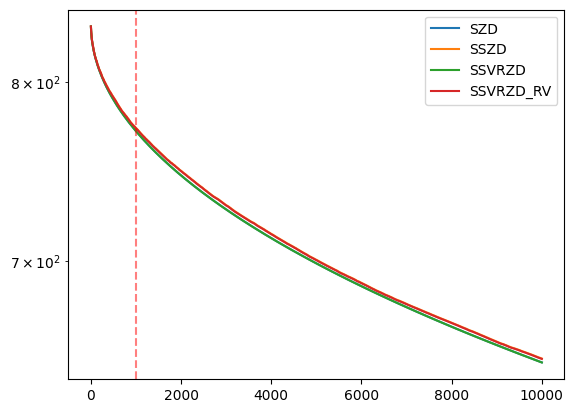

In [76]:
def compute_mean(results):
    results['szd'] = (np.mean(results['szd'], axis=0), np.std(results['szd'], axis=0))
    results['sszd'] = (np.mean(results['sszd'], axis=0), np.std(results['sszd'], axis=0))
    results['ssvrzd_full_iter'] = (np.mean(results['ssvrzd_full_iter'], axis=0), np.std(results['ssvrzd_full_iter'], axis=0))
    results['ssvrzd_only_iter'] = (np.mean(results['ssvrzd_only_iter'], axis=0), np.std(results['ssvrzd_only_iter'], axis=0))

compute_mean(results)    

fig, ax = plt.subplots()

lb, ub = 0, -1

ax.plot(range(len(results['szd'][0][lb:ub])), results['szd'][0][lb:ub], '-', label="SZD")
ax.plot(range(len(results['sszd'][0][lb:ub])), results['sszd'][0][lb:ub], '-', label="SSZD")
ax.plot(range(len(results['ssvrzd_full_iter'][0][lb:ub])), results['ssvrzd_full_iter'][0][lb:ub], '-', label='SSVRZD')
ax.plot(range(len(results['ssvrzd_only_iter'][0][lb:ub])), results['ssvrzd_only_iter'][0][lb:ub], '-', label='SSVRZD_RV')


ax.axvline(num_iters,linestyle='--', color="red", alpha=0.5)

ax.legend()
ax.set_yscale("log")

In [55]:
print(results['ssvrzd_full_iter'][0][:10], results['ssvrzd_only_iter'][0][:10])

[26215087.58852453 14235871.75748869  9755253.35484068  6494751.91872223
  4769972.17307002  3181411.17369423  2536204.43065947  2050213.77259862
  1638631.96590014  1301675.46312766] [26215087.58852453 14235871.75748869  8515000.83893302  6886981.35695108
  5333374.49018029  4666615.11018329  3720644.91846576  3054754.41977679
  2859719.68673838  2668855.96262224]


### TTTT

In [264]:
class SVRG_ZD:
    
    def __init__(self, f, d, l, seed = 12):
        self.d = d
        self.l = l
        self.f = f
        self.rnd_state = np.random.RandomState(seed=seed)
        
    def generate_directions(self):
        Zk = self.rnd_state.randn(self.d, self.l).astype(np.float64)
        Q_k, R_k = np.linalg.qr(Zk, mode="complete")
        diag_R_k = np.diag(R_k)
        D = (diag_R_k / np.abs(diag_R_k)) * np.eye(self.d, self.l, dtype=np.float64)        
        P_k =  np.sqrt(self.d / self.l) * Q_k.dot(D)
        return P_k
        
    def approx_gradient(self, x, z, P, h):
        grad = np.zeros(P.shape[0]) # initialize gradient as [0,...,0] \in \R^d
        fx = self.f(x, z)
        for i in range(P.shape[1]):
            grad += ((self.f(x + h * P[:, i], z) - fx)/h) * P[:, i]
        return grad
        
    def optimize(self, x, alpha, h, sample_z, cb, T = 1000, m = 100):
        for tau in range(1, T + 1): # outer loop
            h_tau = h(tau)
            P_tau = self.generate_directions()
            grad_f = self.approx_gradient(x, None, P_tau, h_tau) # \nabla f(x_\tau)
            x_k = x
            x_next = np.zeros(self.d)
            alpha_tau = alpha(tau)
            for k in range(1, m + 1):
                z_k = sample_z(self.rnd_state)
                P_k = self.generate_directions()
                grad_F = self.approx_gradient(x, z_k, P_k, h(m*(tau - 1) + m))
                grad_F_tau = self.approx_gradient(x, z_k, P_tau, h_tau)
                x_k = x_k - alpha(k) * (grad_F + grad_f - grad_F_tau)
            x = x_k 
            if cb is not None:
                cb(self, x)
        return x
    
    

In [406]:
class SSZD_ALT:
    
    def __init__(self, f, d, l, seed = 12):
        self.d = d
        self.l = l
        self.f = f
        self.rnd_state = np.random.RandomState(seed=seed)
        
    def generate_directions(self):
        Zk = self.rnd_state.randn(self.d, self.l).astype(np.float64)
        Q_k, R_k = np.linalg.qr(Zk, mode="complete")
        diag_R_k = np.diag(R_k)
        D = (diag_R_k / np.abs(diag_R_k)) * np.eye(self.d, self.l, dtype=np.float64)        
        P_k =  np.sqrt(self.d / self.l) * Q_k.dot(D)
        return P_k
        
    def approx_gradient(self, x, z, P, h):
        grad = np.zeros(P.shape[0]) # initialize gradient as [0,...,0] \in \R^d
        fx = self.f(x, z)
        for i in range(P.shape[1]):
            grad += ((self.f(x + h * P[:, i], z) - fx)/h) * P[:, i]
        return grad
        
    def optimize(self, x, alpha, h, sample_z, cb, T = 1000, m = 100, rv = False):
        for tau in range(1, T + 1): # outer loop
            h_tau = h(tau)
            P_tau = self.generate_directions()
            alpha_tau = alpha(tau)
            if (tau - 1) % m == 0:
                grad_f = self.approx_gradient(x, None, P_tau, h_tau) # \nabla f(x_\tau)
                x = x - alpha_tau * grad_f
            else:
                z_tau = sample_z(self.rnd_state)
                grad_F = self.approx_gradient(x, z_tau, P_tau, h_tau)
                x = x - alpha_tau * grad_F
            if cb is not None:
                cb(self, x)
        return x
    
    

In [392]:
class SSZD:
    
    def __init__(self, f, d, l, seed = 12):
        self.d = d
        self.l = l
        self.f = f
        self.rnd_state = np.random.RandomState(seed=seed)
        
    def generate_directions(self):
        Zk = self.rnd_state.randn(self.d, self.l).astype(np.float64)
        Q_k, R_k = np.linalg.qr(Zk, mode="complete")
        diag_R_k = np.diag(R_k)
        D = (diag_R_k / np.abs(diag_R_k)) * np.eye(self.d, self.l, dtype=np.float64)        
        P_k =  np.sqrt(self.d / self.l) * Q_k.dot(D)
        return P_k
        
    def approx_gradient(self, x, z, P, h):
        grad = np.zeros(P.shape[0]) # initialize gradient as [0,...,0] \in \R^d
        fx = self.f(x, z)
        for i in range(P.shape[1]):
            grad += ((self.f(x + h * P[:, i], z) - fx)/h) * P[:, i]
        return grad
        
    def optimize(self, x, alpha, h, sample_z, cb, T = 1000):
        for tau in range(1, T + 1): # outer loop
            h_tau = h(tau)
            P_tau = self.generate_directions()
            grad_F = self.approx_gradient(x, sample_z(self.rnd_state), P_tau, h_tau) # \nabla f(x_\tau)
            x = x - alpha(tau) * grad_F
            if cb is not None:
                cb(self, x)
        return x
    
    

In [393]:
d = 20
rnd_state = np.random.RandomState(12)

w = rnd_state.rand(d, 1)

def generate_data(n_points, w, rnd_state, sigma_noise=0.1):
    X = np.zeros((n_points, d))
    for i in range(d):
        X[:, i] = rnd_state.uniform(-1, 2, size=n_points)
    
    gauss_noise = rnd_state.normal(0, sigma_noise, size=(n_points, 1))

    y = np.dot(X, w) + gauss_noise
    
    return X, y    

n_points = 10000
    
X, y = generate_data(n_points, w, rnd_state, sigma_noise=0.1)

In [394]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)


def mse(y, y_pred):
    return ((y - y_pred)**2).mean()

def target(w, z = None):
    w = w.reshape(-1, 1)
    if z is None:
        X, y = X_train, y_train
    else:
        X, y = z
    y_pred = X.dot(w)
    return mse(y, y_pred)

In [435]:
def sample_z(rnd_state):
    idx = rnd_state.randint(low=0, high=X_train.shape[0])
    return (X_train[idx, :], y_train[idx, :])

l = d

zd = SSZD(target, d, l, seed = 12)
sszd = SSZD(target, d, l, seed = 12)
svrg_zd = SVRG_ZD(target, d, l, seed = 12)
svrg_rv = SSZD_ALT(target, d, l, seed = 12)

In [439]:
w = np.zeros(d) + 200
alpha = lambda k : 0.1 * 1/np.sqrt(k)
h = lambda k : 1/k

#    def optimize(self, x, alpha, h, sample_z, cb, T = 1000, m = 100):


results_zd = [target(w)]
results_sszd = [target(w)]
results_vr = [target(w)]
results_rv = [target(w)]

def cb_sszd(opt, x):
    results_sszd.append(target(x))

def cb_vr(opt, x):
    results_vr.append(target(x))

def cb_rv(opt, x):
    results_rv.append(target(x))

def cb_zd(opt, x):
    results_zd.append(target(x))

T_vr = 100
m = 5

T_sz = T_vr * m
    
w_sszd = sszd.optimize(w, alpha, h, sample_z, cb_sszd, T = T_sz)
w_vr = svrg_zd.optimize(w, alpha, h, sample_z, cb_vr, T = T_vr, m = m)
w_rv = svrg_rv.optimize(w, alpha, h, sample_z, cb_rv, T = T_sz, m = m)
w_zd = zd.optimize(w, alpha, h, lambda k : None, cb_zd, T = T_sz)

In [440]:
results_vr_repl = [results_vr[0]] + [v for v in results_vr[1:] for i in range(m)]

len(results_vr_repl)


501

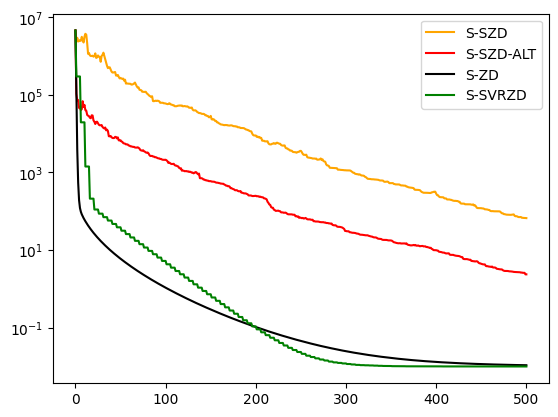

In [443]:
fig, ax = plt.subplots()

ax.plot(range(len(results_sszd)), results_sszd, '-', color='orange', label='S-SZD')
ax.plot(range(len(results_rv)), results_rv, '-', color='red', label='S-SZD-ALT')
ax.plot(range(len(results_zd)), results_zd, '-', color='black', label='S-ZD')
ax.plot(range(len(results_sszd)), results_vr_repl, '-', color='green', label='S-SVRZD')
ax.set_yscale("log")
ax.legend()
